Mapping of Shapley values onto compound structures

In [1]:
import os
os.environ["http_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"
os.environ["https_proxy"] = "http://web-proxy.informatik.uni-bonn.de:3128"

Import libraries

In [2]:
import yaml

import torch

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

from rdkit.Chem.Draw import rdMolDraw2D

from PIL import Image
import imageio.v2 as imageio

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from src import const
from src.molecule_builder import get_bond_order
from src.visualizer import load_molecule_xyz, load_xyz_files
from src.datasets import get_dataloader
from src.lightning import DDPM

from tqdm.auto import tqdm

In [3]:
COORDINATES_FOLDER = "trajectories/zinc_difflinker/zinc_final_test/chains_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition_alternate_viz/"
SHAPLEY_VALUES_FOLDER = "results/shapley_values/"

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

checkpoint = config['CHECKPOINT']
DATA = config['DATA']
prefix = config['PREFIX']
device = config['DEVICE'] if torch.cuda.is_available() else 'cpu'
NUM_SAMPLES = config['NUM_SAMPLES']
SEED_LIST = [42,1240,14085]

model = DDPM.load_from_checkpoint(checkpoint, map_location=device)
model.val_data_prefix = prefix

print(f"Running device: {device}")

if DATA is not None:
    model.data_path = DATA

model = model.eval().to(device)
model.setup(stage='val')
dataloader = get_dataloader(
    model.val_dataset,
    batch_size=1
)

/home/mastropietro/anaconda3/envs/diff_explainer/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
Lightning automatically

Running device: cuda:7


In [4]:
data_list = []
sampled = 0
data_dict = {}
for data in dataloader:
    if sampled < NUM_SAMPLES:
        data_list.append(data)
        sampled += 1

# #print all fragment masks, linker masks, and anchor masks
# for i in range(len(data_list)):
#     data_dict[i] = {}
#     data_dict[i]["fragment_mask"] = data_list[i]['fragment_mask'].squeeze(0)
#     data_dict[i]["linker_mask"] = data_list[i]['linker_mask'].squeeze(0)
#     data_dict[i]["anchors"] = data_list[i]['anchors'].squeeze(0)

In [5]:
#load shapley values

shapley_values_all_dict = {}

for i in range(NUM_SAMPLES):
    shapley_values_all_dict[i] = []
    
    for seed in SEED_LIST:
        shapley_values_seed = []
        with open(f"{SHAPLEY_VALUES_FOLDER}explanations_hausdorff_distance_0.5_seed_{str(seed)}_no_transform_transformation_seed_42_COM_addition/phi_atoms_{i}.txt", "r") as f:
            f.readline()
            f.readline()
            
            for line in f:
                if line == "\n":
                    break
                row = line.strip().split(",")
                shapley_values_seed.append(float(row[1]))
        shapley_values_all_dict[i].append(shapley_values_seed)
        

In [6]:
def arrestomomentum():
    raise KeyboardInterrupt("Debug interrupt.")

def has_bond(atom1, atom2, distance, check_exists=True, margins=const.MARGINS_EDM):
    distance = 100 * distance  # We change the metric

    # Check exists for large molecules where some atom pairs do not have a
    # typical bond length.
    if check_exists:
        if atom1 not in const.BONDS_1:
            return 0
        if atom2 not in const.BONDS_1[atom1]:
            return 0

    # margin1, margin2, margin3, and margin4 have been tuned to maximize stability
    if distance < const.BONDS_1[atom1][atom2] + margins[0]:
        # Check for aromatic bonds
        return 1  # Single
    return 0  # No bond

def get_bond_order_with_aromatic(atom1, atom2, distance, check_exists=True, margins=const.MARGINS_EDM):
    distance = 100 * distance  # We change the metric

    # Check exists for large molecules where some atom pairs do not have a
    # typical bond length.
    if check_exists:
        if atom1 not in const.BONDS_1:
            return 0
        if atom2 not in const.BONDS_1[atom1]:
            return 0

    # margin1, margin2, margin3, and margin4 have been tuned to maximize stability
    if distance < const.BONDS_1[atom1][atom2] + margins[0]:
        # Check for aromatic bonds
        if atom1 in const.BONDS_AROMATIC and atom2 in const.BONDS_AROMATIC[atom1]:
            thr_aromatic = const.BONDS_AROMATIC[atom1][atom2] + margins[3]
            if distance < thr_aromatic:
                return 4  # Aromatic

        # Check if atoms in bonds2 dictionary.
        if atom1 in const.BONDS_2 and atom2 in const.BONDS_2[atom1]:
            thr_bond2 = const.BONDS_2[atom1][atom2] + margins[1]
            if distance < thr_bond2:
                if atom1 in const.BONDS_3 and atom2 in const.BONDS_3[atom1]:
                    thr_bond3 = const.BONDS_3[atom1][atom2] + margins[2]
                    if distance < thr_bond3:
                        return 3  # Triple
                return 2  # Double
        # Check for aromatic bonds
        # if atom1 in const.BONDS_AROMATIC and atom2 in const.BONDS_AROMATIC[atom1]:
        #     thr_aromatic = const.BONDS_AROMATIC[atom1][atom2] + margins[3]
        #     if distance < thr_aromatic:
        #         return 4  # Aromatic
        return 1  # Single
    return 0  # No bond

def draw_sphere_xai(ax, x, y, z, size, color, alpha):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    xs = size * np.outer(np.cos(u), np.sin(v))
    ys = size * np.outer(np.sin(u), np.sin(v)) #* 0.8
    zs = size * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x + xs, y + ys, z + zs, rstride=2, cstride=2, color=color, alpha=alpha)
    
def plot_molecule_xai_border(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=hex_bg_color,
                    alpha=alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        phi_values_array = np.array(phi_values)

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        colors_fragment = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        # Calculate the gradient colors based on phi values
        cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
        norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
        colors_fragment_shadow = cmap(norm(phi_values_array))
        
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment, edgecolors=colors_fragment_shadow, linewidths=5, rasterized=False)

        #draw non-fragment atoms
        colors = colors[fragment_mask_on_cpu == 0]
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.9 * alpha, c=colors, rasterized=False)

def plot_molecule_xai_fill(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                
                # Check if at least one atom is a linker atom
                if fragment_mask[i] == 0 or fragment_mask[j] == 0:
                    edge_color = 'gray'
                    current_alpha = 0.5 * alpha
                else:
                    edge_color = hex_bg_color
                    current_alpha = 0.7 * alpha
                
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=edge_color,
                    alpha=current_alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        phi_values_array = np.array(phi_values)

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        # colors_fragment = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        # Calculate the gradient colors based on phi values
        cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
        norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
        colors_fragment_shadow = cmap(norm(phi_values_array))
        
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment_shadow, edgecolors=colors_fragment_shadow, linewidths=2.5, rasterized=False)

        #draw non-fragment atoms
        # linker_color = np.array([0.5, 0.5, 0.5, 0.7])
        # colors = np.array([[0.5, 0.5, 0.5, 0.7]] * len(colors[fragment_mask_on_cpu == 0]))
        colors = np.array([0.25, 0.63, 0.38, 1])  # Slightly darker emerald green color with alpha 1
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.5 * alpha, color=colors, rasterized=False)

def plot_molecule_linker_focus(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                
                # Check if at least one atom is a fragment atom
                if fragment_mask[i] == 1 or fragment_mask[j] == 1:
                    edge_color = 'gray'
                    current_alpha = 0.5 * alpha
                else:
                    edge_color = hex_bg_color
                    current_alpha = 0.7 * alpha
                
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=edge_color,
                    alpha=current_alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        
        color_fragments = np.array([0.5, 0.5, 0.5, 0.7])
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)
        
        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.3 * alpha, color=color_fragments, rasterized=False)

        #draw non-fragment atoms
        colors = colors[fragment_mask_on_cpu == 0]
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.7 * alpha, c=colors, rasterized=False)

def plot_molecule_fragments_focus(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None, phi_values=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                
                # Check if at least one atom is a linker atom
                if fragment_mask[i] == 0 or fragment_mask[j] == 0:
                    edge_color = 'gray'
                    current_alpha = 0.5 * alpha
                else:
                    edge_color = hex_bg_color
                    current_alpha = 0.7 * alpha
                
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=edge_color,
                    alpha=current_alpha
                )

    

    if spheres_3d:
        
        for i, j, k, s, c, f, phi in zip(x, y, z, radii, colors, fragment_mask, phi_values):
            if f == 1:
                alpha = 1.0
                if phi > 0:
                    c = 'red'

            draw_sphere_xai(ax, i.item(), j.item(), k.item(), 0.5 * s, c, alpha)

    else:
        

        #draw fragments
        fragment_mask_on_cpu = fragment_mask.cpu().numpy()
        color_fragments = colors[fragment_mask_on_cpu == 1]
        x_fragment = x[fragment_mask_on_cpu == 1]
        y_fragment = y[fragment_mask_on_cpu == 1]
        z_fragment = z[fragment_mask_on_cpu == 1]
        areas_fragment = areas[fragment_mask_on_cpu == 1]
        
        
        
        # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)
        
        ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.7 * alpha, c=color_fragments, rasterized=False)

        #draw non-fragment atoms
        # colors = colors[fragment_mask_on_cpu == 0]
        color_linker = np.array([0.5, 0.5, 0.5, 0.7])
        x = x[fragment_mask_on_cpu == 0]
        y = y[fragment_mask_on_cpu == 0]
        z = z[fragment_mask_on_cpu == 0]
        areas = areas[fragment_mask_on_cpu == 0]
        ax.scatter(x, y, z, s=areas, alpha=0.3 * alpha, color=color_linker, rasterized=False)

def plot_molecule(ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom, fragment_mask=None):
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]
    # Hydrogen, Carbon, Nitrogen, Oxygen, Flourine

    idx2atom = const.GEOM_IDX2ATOM if is_geom else const.IDX2ATOM

    colors_dic = np.array(const.COLORS)
    radius_dic = np.array(const.RADII)
    area_dic = 1500 * radius_dic ** 2

    areas = area_dic[atom_type]
    radii = radius_dic[atom_type]
    colors = colors_dic[atom_type]

    if fragment_mask is None:
        fragment_mask = torch.ones(len(x))

    for i in range(len(x)):
        for j in range(i + 1, len(x)):
            p1 = np.array([x[i], y[i], z[i]])
            p2 = np.array([x[j], y[j], z[j]])
            dist = np.sqrt(np.sum((p1 - p2) ** 2))
            atom1, atom2 = idx2atom[atom_type[i]], idx2atom[atom_type[j]]
            draw_edge_int = get_bond_order(atom1, atom2, dist)
            line_width = (3 - 2) * 2 * 2
            draw_edge = draw_edge_int > 0
            if draw_edge:
                if draw_edge_int == 4:
                    linewidth_factor = 1.5
                else:
                    linewidth_factor = 1
                linewidth_factor *= 0.5
                
                edge_color = hex_bg_color
                
                ax.plot(
                    [x[i], x[j]], [y[i], y[j]], [z[i], z[j]],
                    linewidth=line_width * linewidth_factor * 2,
                    c=edge_color,
                    alpha=0.7 * alpha
                )


    #draw fragments
    fragment_mask_on_cpu = fragment_mask.cpu().numpy()
    colors_fragment = colors[fragment_mask_on_cpu == 1]
    x_fragment = x[fragment_mask_on_cpu == 1]
    y_fragment = y[fragment_mask_on_cpu == 1]
    z_fragment = z[fragment_mask_on_cpu == 1]
    areas_fragment = areas[fragment_mask_on_cpu == 1]
    
    
    # ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.9 * alpha, c=colors_fragment)

    ax.scatter(x_fragment, y_fragment, z_fragment, s=areas_fragment, alpha=0.7 * alpha, c=colors_fragment, rasterized=False)

    #draw non-fragment atoms
    # linker_color = np.array([0.5, 0.5, 0.5, 0.7])
    # colors = np.array([[0.5, 0.5, 0.5, 0.7]] * len(colors[fragment_mask_on_cpu == 0]))
    colors_linker = colors[fragment_mask_on_cpu == 0]
    x = x[fragment_mask_on_cpu == 0]
    y = y[fragment_mask_on_cpu == 0]
    z = z[fragment_mask_on_cpu == 0]
    areas = areas[fragment_mask_on_cpu == 0]
    ax.scatter(x, y, z, s=areas, alpha=0.7 * alpha, color=colors_linker, rasterized=False)

def plot_data3d_xai(positions, atom_type, is_geom, camera_elev=0, camera_azim=0, save_path=None, spheres_3d=False,
                bg='black', alpha=1., fragment_mask=None, phi_values=None, mapping = "border"):
    black = (0, 0, 0)
    white = (1, 1, 1)
    hex_bg_color = '#FFFFFF' if bg == 'black' else '#000000' #'#666666'

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_aspect('auto')
    ax.view_init(elev=camera_elev, azim=camera_azim)
    if bg == 'black':
        ax.set_facecolor(black)
    else:
        ax.set_facecolor(white)
    ax.xaxis.pane.set_alpha(0)
    ax.yaxis.pane.set_alpha(0)
    ax.zaxis.pane.set_alpha(0)
    ax._axis3don = False

    if bg == 'black':
        ax.w_xaxis.line.set_color("black")
    else:
        ax.w_xaxis.line.set_color("white")

    if mapping == "border":
        plot_molecule_xai_border(
            ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
        )
    elif mapping == "fill":
        plot_molecule_xai_fill(
            ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
        )
    elif mapping == "linker":
        plot_molecule_linker_focus(
            ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
        )
    elif mapping == "fragments":
        plot_molecule_fragments_focus(
            ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask, phi_values=phi_values
        )
    elif mapping is None:
        plot_molecule(
            ax, positions, atom_type, alpha, spheres_3d, hex_bg_color, is_geom=is_geom, fragment_mask=fragment_mask
        )
    else:
        raise ValueError(f"Unknown mapping: {mapping}")

    max_value = positions.abs().max().item()
    axis_lim = min(40, max(max_value / 1.5 + 0.3, 3.2))
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)
    ax.set_zlim(-axis_lim, axis_lim)
    dpi = 300 if spheres_3d else 300 #it was 120 and 50

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi)
        # plt.savefig(save_path, bbox_inches='tight', pad_inches=0.0, dpi=dpi, transparent=True)

        if spheres_3d:
            img = imageio.imread(save_path)
            img_brighter = np.clip(img * 1.4, 0, 255).astype('uint8')
            imageio.imsave(save_path, img_brighter)
    else:
        plt.show()
    plt.close()

def visualize_chain_xai(
        path, spheres_3d=False, bg="black", alpha=1.0, wandb=None, mode="chain", is_geom=False, fragment_mask=None, phi_values=None, mapping = "border"
):
    files = load_xyz_files(path)
    save_paths = []

    # Fit PCA to the final molecule – to obtain the best orientation for visualization
    positions, one_hot, charges = load_molecule_xyz(files[-1], is_geom=is_geom)
    pca = PCA(n_components=3)
    pca.fit(positions)
    
    for i in range(len(files)):
        file = files[i]

        positions, one_hot, charges = load_molecule_xyz(file, is_geom=is_geom)
        atom_type = torch.argmax(one_hot, dim=1).numpy()

        # Transform positions of each frame according to the best orientation of the last frame
        positions = pca.transform(positions)
        positions = torch.tensor(positions)

        fn = file[:-4] + '.png'
        plot_data3d_xai(
            positions, atom_type,
            save_path=fn,
            spheres_3d=spheres_3d,
            alpha=alpha,
            bg=bg,
            camera_elev=90,
            camera_azim=90,
            is_geom=is_geom,
            fragment_mask=fragment_mask,
            phi_values=phi_values,
            mapping = mapping
        )
        save_paths.append(fn)

    imgs = [imageio.imread(fn) for fn in save_paths]
    dirname = os.path.dirname(save_paths[0])
    gif_path = dirname + '/output.gif'
    imageio.mimsave(gif_path, imgs, subrectangles=True)

    if wandb is not None:
        wandb.log({mode: [wandb.Video(gif_path, caption=gif_path)]})

In [6]:
start=0
for data_index, data in enumerate(tqdm(data_list)):
    phi_values_for_viz = shapley_values_all_dict[data_index][0]
    
    for i in range(len(data['positions'])):
        name = str(i + start)
        visualize_chain_xai(
            COORDINATES_FOLDER + str(name) + "/",
            spheres_3d=False,
            alpha=1.0,
            bg='white',
            is_geom=model.is_geom,
            fragment_mask=data['fragment_mask'][i].squeeze(),
            phi_values=phi_values_for_viz,
            mapping="fragments" # "border", "fill", "linker", "fragments", None
        )
        
    start += len(data['positions'])

  0%|          | 0/30 [00:00<?, ?it/s]

NameError: name 'visualize_chain_xai' is not defined

Molecular graph visualization (real molecules)

In [ ]:
# Visualize molecules as molecular graphs with no highlighting
for data_index, data in enumerate(data_list):
    for i in range(len(data['positions'])):
        # Convert positions and atom types to an RDKit molecule
        atom_types = torch.argmax(data['one_hot'][i], dim=1).cpu().numpy()
        mol = Chem.RWMol()
        atom_map = {}

        # Add atoms to the molecule
        for idx, atom_type in enumerate(atom_types):
            atom = Chem.Atom(const.IDX2ATOM[atom_type])
            atom_idx = mol.AddAtom(atom)
            atom_map[idx] = atom_idx

        # Add bonds based on positions and bond order
        positions = data['positions'][i].cpu().numpy()
        for idx1 in range(len(positions)):
            for idx2 in range(idx1 + 1, len(positions)):
                dist = np.linalg.norm(positions[idx1] - positions[idx2])
                bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
                if bond_order > 0:
                    mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    img = Draw.MolToImage(
        mol,
        size=(800, 800),
        kekulize=True,
    )
    img.show()

    # Save the image in the "structures" subfolder
    output_dir = os.path.join(COORDINATES_FOLDER, "original")
    os.makedirs(output_dir, exist_ok=True)
    img.save(os.path.join(output_dir, f"molecule_{data_index}.png"), dpi=(300, 300))

In [ ]:
# Visualize molecules as molecular graphs highlighting linker atoms
for data_index, data in enumerate(data_list):
    for i in range(len(data['positions'])):
        # Convert positions and atom types to an RDKit molecule
        atom_types = torch.argmax(data['one_hot'][i], dim=1).cpu().numpy()
        mol = Chem.RWMol()
        atom_map = {}

        # Add atoms to the molecule
        for idx, atom_type in enumerate(atom_types):
            atom = Chem.Atom(const.IDX2ATOM[atom_type])
            atom_idx = mol.AddAtom(atom)
            atom_map[idx] = atom_idx

        # Add bonds based on positions and bond order
        positions = data['positions'][i].cpu().numpy()
        for idx1 in range(len(positions)):
            for idx2 in range(idx1 + 1, len(positions)):
                dist = np.linalg.norm(positions[idx1] - positions[idx2])
                bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
                if bond_order > 0:
                    mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight linker atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
    highlight_atoms = [idx for idx, mask in enumerate(fragment_mask) if mask == 0]
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms or bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())

    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    img = Draw.MolToImage(
        mol,
        size=(800, 800),
        kekulize=True,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        # highlightColor=(0.56, 0.93, 0.56, 0.7)  # Light emerald green color with 70% transparency
        highlightColor=(0.25, 0.63, 0.38, 0.7),  # Slightly darker emerald green color with alpha 0.7
    )
    # img.show()

    # Save the image in the "structures" subfolder
    output_dir = os.path.join(COORDINATES_FOLDER, "structures")
    os.makedirs(output_dir, exist_ok=True)
    img.save(os.path.join(output_dir, f"molecule_{data_index}.png"), dpi=(300, 300))

Molecular graph visualization (generated molecules)

In [ ]:
# Visualize generated molecules as molecular graphs with no highlighting
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"


for data_index, data in enumerate(data_list):
    
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=model.is_geom)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()

    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])


    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    img = Draw.MolToImage(
        mol,
        size=(800, 800),
        kekulize=True,
    )
    # img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "noxai")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))


In [ ]:
# Visualize generated molecules as molecular graphs 
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"


for data_index, data in enumerate(data_list):
    
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=model.is_geom)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()

    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight linker atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
    highlight_atoms = [idx for idx, mask in enumerate(fragment_mask) if mask == 0]
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms or bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())

    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    img = Draw.MolToImage(
        mol,
        size=(800, 800),
        kekulize=True,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        highlightColor=(0.25, 0.63, 0.38, 0.7)  # Slightly darker emerald green color with alpha 0.7
    )
    # img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "generations")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))


Molecural graph with atom importance

In [ ]:


# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=model.is_geom)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight fragment atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    # bond_colors = {}
    # for bond in mol.GetBonds():
    #     begin_idx = bond.GetBeginAtomIdx()
    #     end_idx = bond.GetEndAtomIdx()
    #     if begin_idx in highlight_colors and end_idx in highlight_colors:
    #         # Use the colors of the two connected atoms
    #         color1 = tuple(highlight_colors[begin_idx][:3])  # Extract RGB values for atom 1
    #         color2 = tuple(highlight_colors[end_idx][:3])  # Extract RGB values for atom 2
    #         bond_colors[bond.GetIdx()] = (color1, color2)  # Assign a tuple of two colors
    #uncomment for averaging colors
    bond_colors = {}
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if begin_idx in highlight_colors and end_idx in highlight_colors:
            # Average the colors of the two connected atoms
            color1 = np.array(highlight_colors[begin_idx][:3])
            color2 = np.array(highlight_colors[end_idx][:3])
            averaged_color = tuple((color1 + color2) / 2)
            bond_colors[bond.GetIdx()] = averaged_color
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    # print("Atoms colors:", atom_colors)
    # # Generate random colors for atoms
    # random.seed(42)  # For reproducibility
    # atom_colors = {idx: (random.random(), random.random(), random.random()) for idx in highlight_atoms}
    # Create a 2D drawer with Cairo backend

    # Update highlight colors for linker atoms and bonds to green
    # highlight_linker_atoms = [idx for idx, mask in enumerate(fragment_mask) if mask == 0]
    # highlight_atoms.extend(highlight_linker_atoms)
    # linker_color = (0.25, 0.63, 0.38)
    # highlight_linker_colors = {idx: linker_color for idx in highlight_linker_atoms}  # Linker color
    # atom_colors.update(highlight_linker_colors)  # Linker color
    
    
    # # Update bond colors for linker bonds to green
    # highlight_bonds.extend([bond.GetIdx() for bond in mol.GetBonds() if bond.GetBeginAtomIdx() in highlight_linker_atoms or bond.GetEndAtomIdx() in highlight_linker_atoms])
    # for bond in mol.GetBonds():
    #     begin_idx = bond.GetBeginAtomIdx()
    #     end_idx = bond.GetEndAtomIdx()
    #     if fragment_mask[begin_idx] == 0 or fragment_mask[end_idx] == 0:
    #         bond_colors[bond.GetIdx()] = linker_color
            
    drawer = rdMolDraw2D.MolDraw2DCairo(800, 800)

    # Prepare molecule for drawing
    rdMolDraw2D.PrepareMolForDrawing(mol)

    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    # Draw the molecule with highlighted atoms and bonds
    drawer.DrawMolecule(
        mol,
        highlightAtoms=highlight_atoms,
        highlightBonds=highlight_bonds,
        highlightAtomColors=atom_colors,
        highlightBondColors=bond_colors,
        )
    

    # Convert the drawing to a PNG image
    png_data = drawer.GetDrawingText()
    with open("temp_image.png", "wb") as f:
        f.write(png_data)

    # Load the PNG image using PIL
    img = Image.open("temp_image.png")
    
    img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "mapping")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))

Use rdkit heatmaps

[13:21:09] Molecule does not have explicit Hs. Consider calling AddHs()


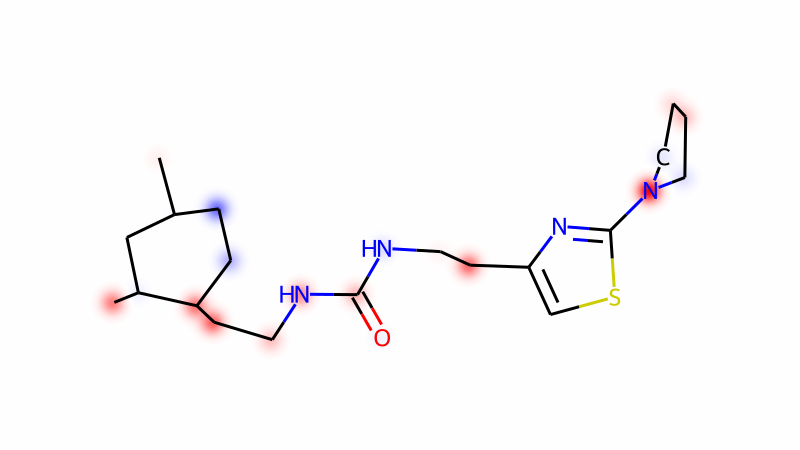

[13:21:13] Molecule does not have explicit Hs. Consider calling AddHs()
[13:21:13] Explicit valence for atom # 24 N, 4, is greater than permitted


AtomValenceException: Explicit valence for atom # 24 N, 4, is greater than permitted

<Figure size 432x288 with 0 Axes>

In [ ]:
# from rdkit_heatmaps import mapvalues2mol
# from rdkit_heatmaps.utils import transform2png
# from rdkit.Geometry import Point3D

# # Visualize generated molecules as molecular graphs
# generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

# for data_index, data in enumerate(data_list):
#     phi_values = shapley_values_all_dict[data_index][0]
#     # Load generated molecule positions and atom types
#     generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
#     positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=model.is_geom)
    
#     atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
#     # Convert positions and atom types to an RDKit molecule
#     mol = Chem.RWMol()
#     # mol = Draw.PrepareMolForDrawing(mol)
#     atom_map = {}

#     # Add atoms to the molecule
#     for idx, atom_type in enumerate(atom_types):
#         atom = Chem.Atom(const.IDX2ATOM[atom_type])
#         atom_idx = mol.AddAtom(atom)
#         atom_map[idx] = atom_idx
    
#     # Add bonds based on positions and bond order
#     for idx1 in range(len(positions)):
#         for idx2 in range(idx1 + 1, len(positions)):
#             dist = np.linalg.norm(positions[idx1] - positions[idx2])
#             bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
#             if bond_order > 0:
#                 mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

#     # Highlight fragment atoms and edges
#     # Assign 3D coordinates to the molecule
    
#     mol.UpdatePropertyCache(strict=False)
#     # mol = Chem.AddHs(mol)
#     AllChem.EmbedMolecule(mol, AllChem.ETKDG())  # Use the ETKDG method for 3D coordinate generation

#     fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
#     # Calculate the gradient colors based on phi values
#     phi_values_array = np.array(phi_values)
    
#     cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
#     norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
#     highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
#     atom_phi_values = {idx: phi_values_array[idx] for idx, mask in enumerate(fragment_mask) if mask == 1}
#     #reverse atom_phi_values
#     atom_phi_values = {idx: -phi for idx, phi in atom_phi_values.items()}
#     highlight_atoms = list(highlight_colors.keys())
#     # Pad atom_phi_values with 0 to match the total number of atoms
#     total_atoms = len(atom_types)
#     for idx in range(total_atoms):
#         if idx not in atom_phi_values:
#             atom_phi_values[idx] = 0.0
#     highlight_bonds = []
#     for bond in mol.GetBonds():
#         if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
#             highlight_bonds.append(bond.GetIdx())
#     # Assign bond colors based on the colors of the connected atoms
#     # bond_colors = {}
#     # for bond in mol.GetBonds():
#     #     begin_idx = bond.GetBeginAtomIdx()
#     #     end_idx = bond.GetEndAtomIdx()
#     #     if begin_idx in highlight_colors and end_idx in highlight_colors:
#     #         # Use the colors of the two connected atoms
#     #         color1 = tuple(highlight_colors[begin_idx][:3])  # Extract RGB values for atom 1
#     #         color2 = tuple(highlight_colors[end_idx][:3])  # Extract RGB values for atom 2
#     #         bond_colors[bond.GetIdx()] = (color1, color2)  # Assign a tuple of two colors
#     #uncomment for averaging colors
    
            
#     # drawer = rdMolDraw2D.MolDraw2DCairo(800, 800)

#     # Prepare molecule for drawing
#     # rdMolDraw2D.PrepareMolForDrawing(mol)

#     # draw_options = drawer.drawOptions()
#     # draw_options.useBWAtomPalette()
#     # Draw the molecule with highlighted atoms and bonds
#     # Generate a similarity map from the weights (phi_values_array)
#     # Set Shapley values of 0 to linker atoms
#     # Pad Shapley values with 0 to match the number of atoms
#     plt.clf()
#     canvas = mapvalues2mol(mol, atom_phi_values, None, atom_width=0.2, bond_length=0.5, bond_width=0.5) #TBD: only one direction for edges? bonds weights is wrt rdkit bonds order?

#     img_expl = transform2png(canvas.GetDrawingText())
#     # drawer.FinishDrawing()
    
#     # Save the molecule with the similarity map as a PNG image
#     output_generated_dir = os.path.join(COORDINATES_FOLDER, "maps")
#     os.makedirs(output_generated_dir, exist_ok=True)
#     output_file = os.path.join(output_generated_dir, f"molecule_with_similarity_map_{data_index}.png")

#     img_expl.save(output_file, dpi = (300,300))
#     img_expl.show()
    

In [36]:
atom_types.shape

(26,)

Visualization with atom mapping and edge double coloring

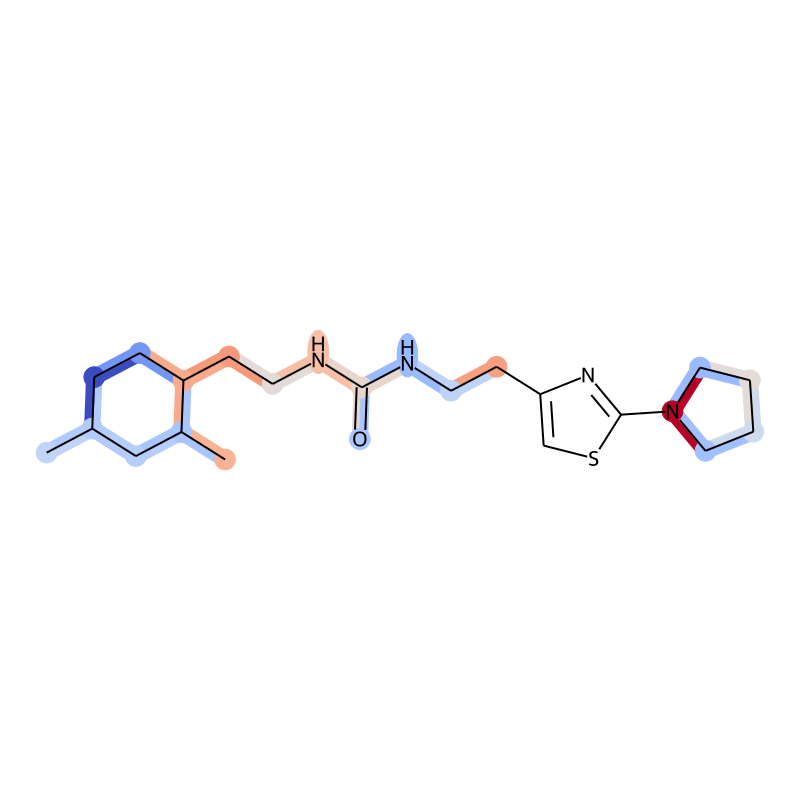

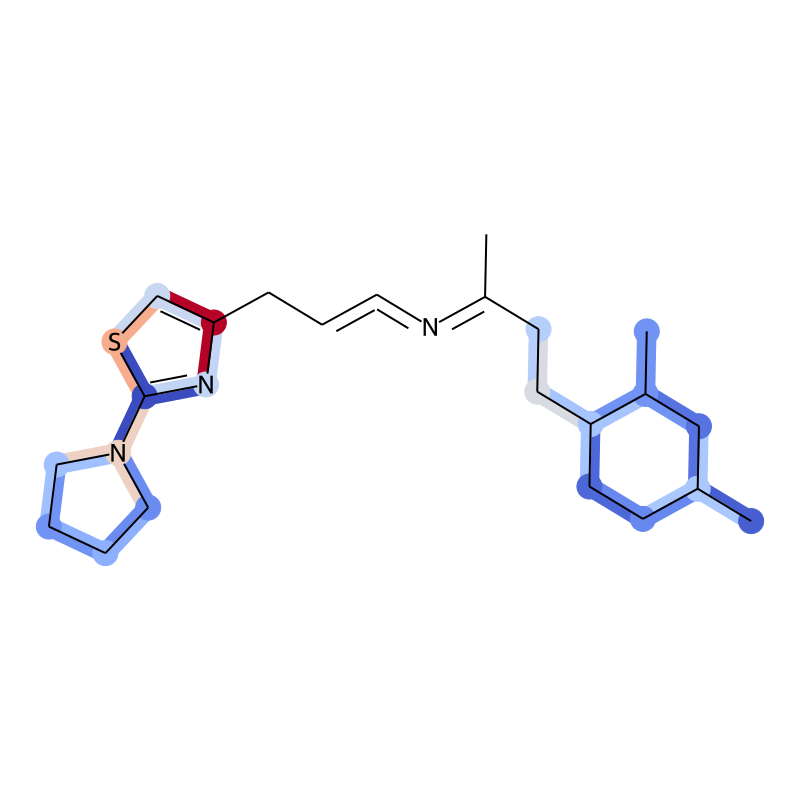

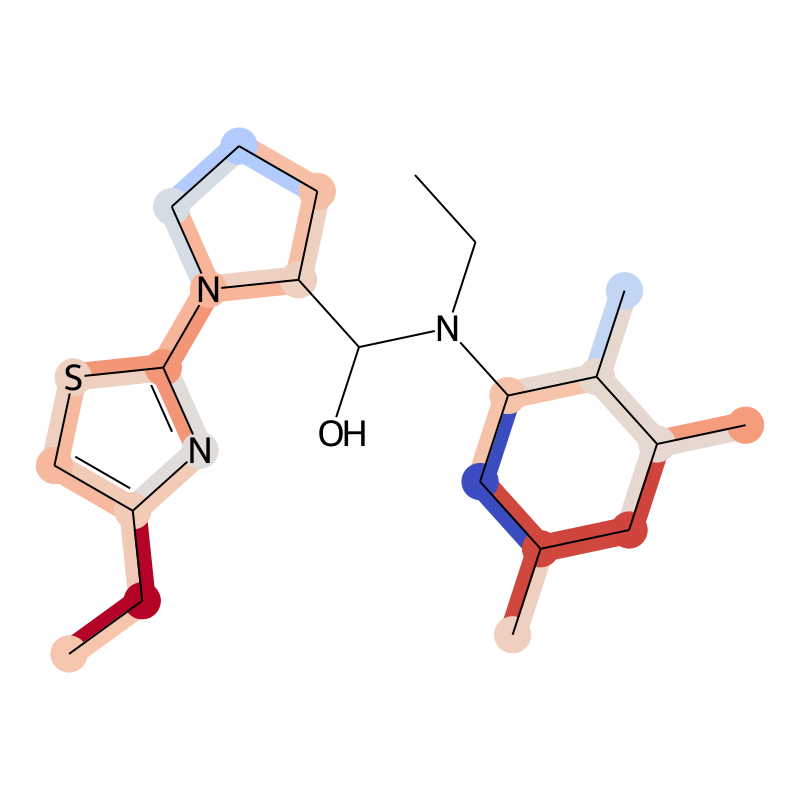

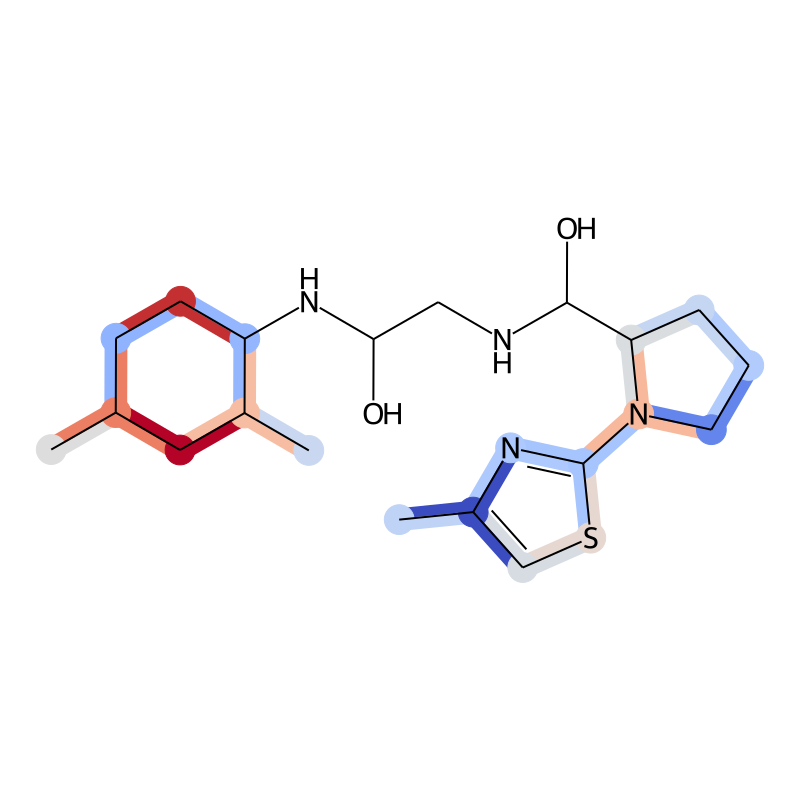

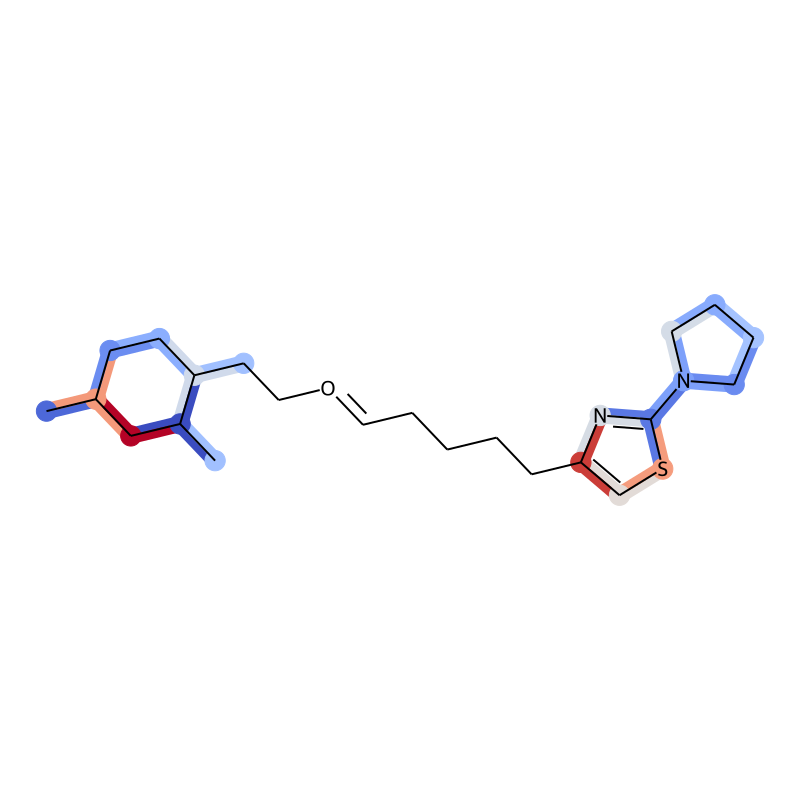

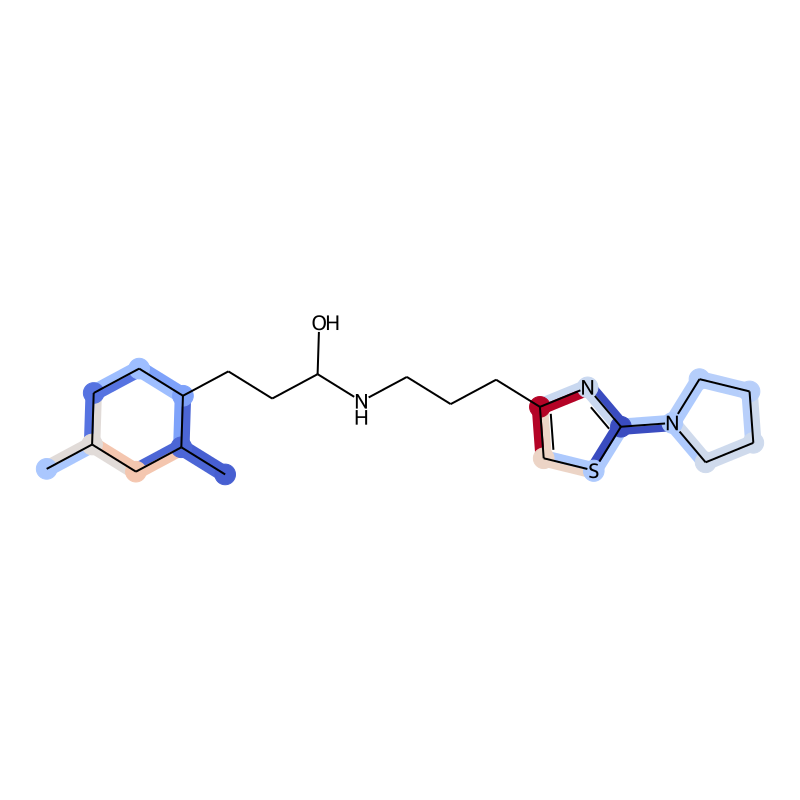

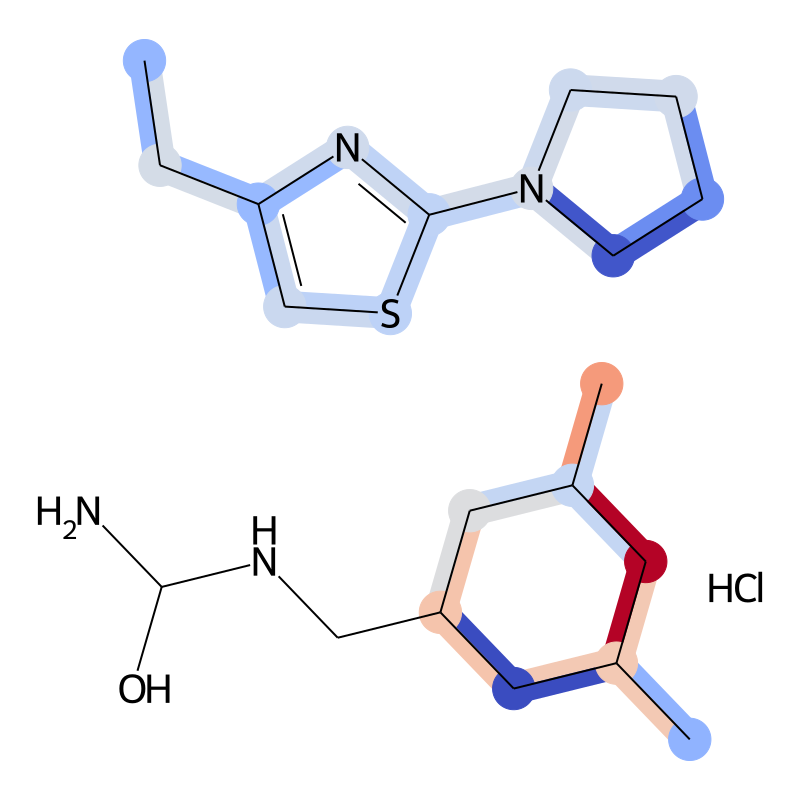

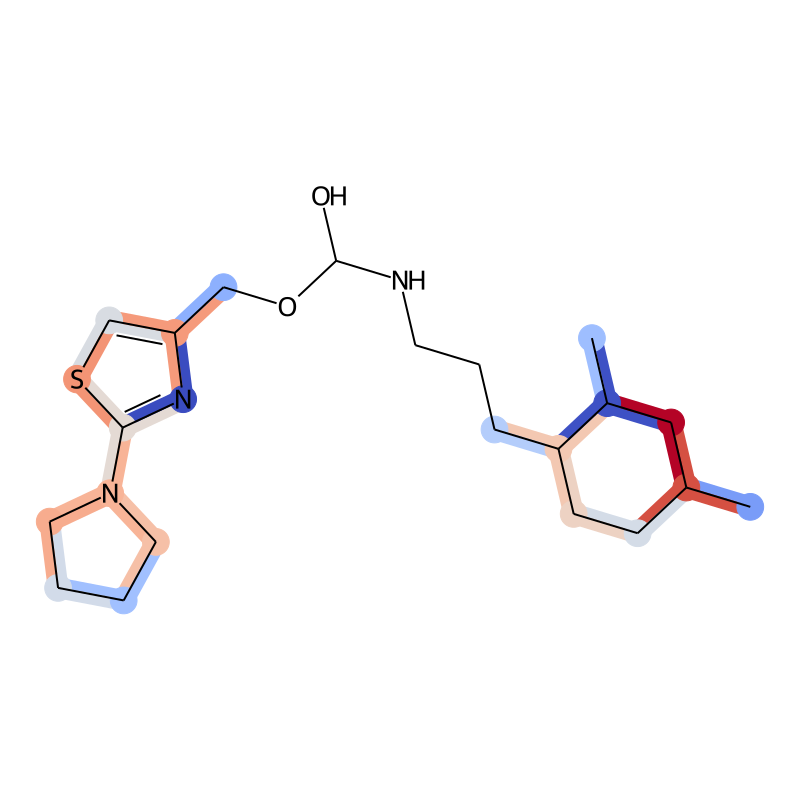

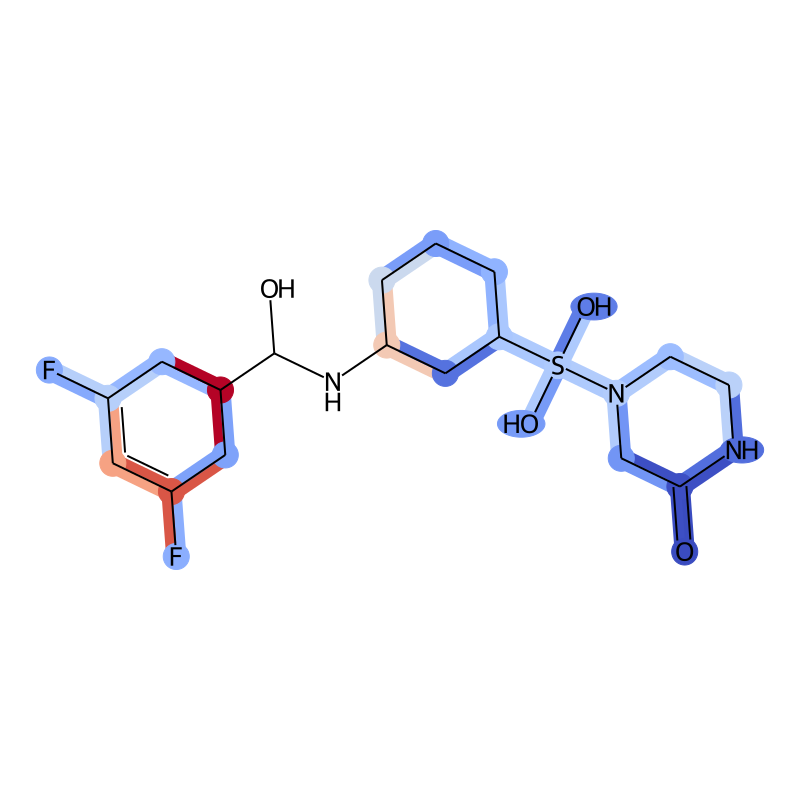

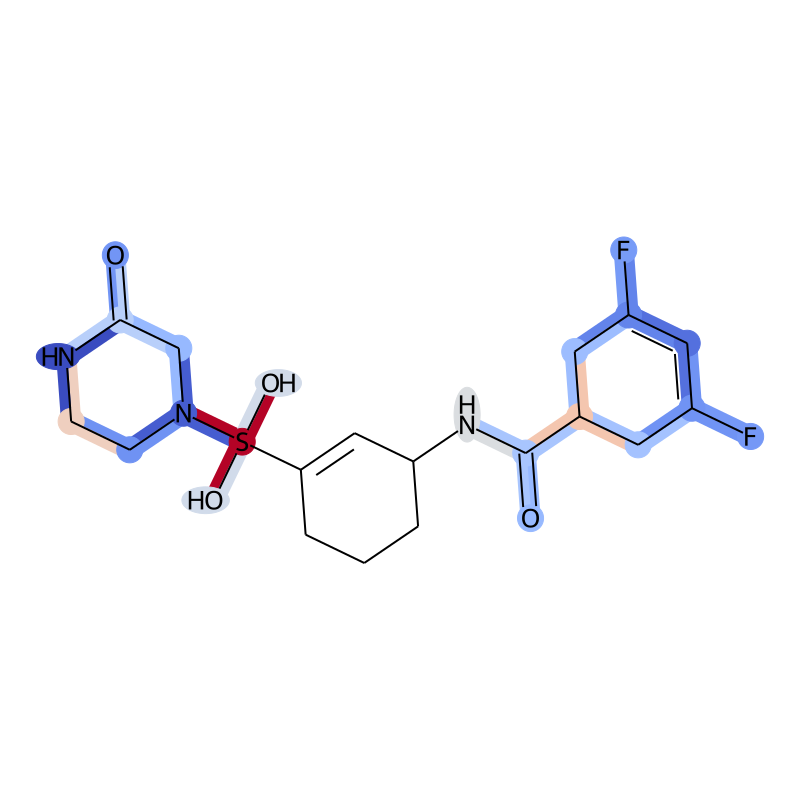

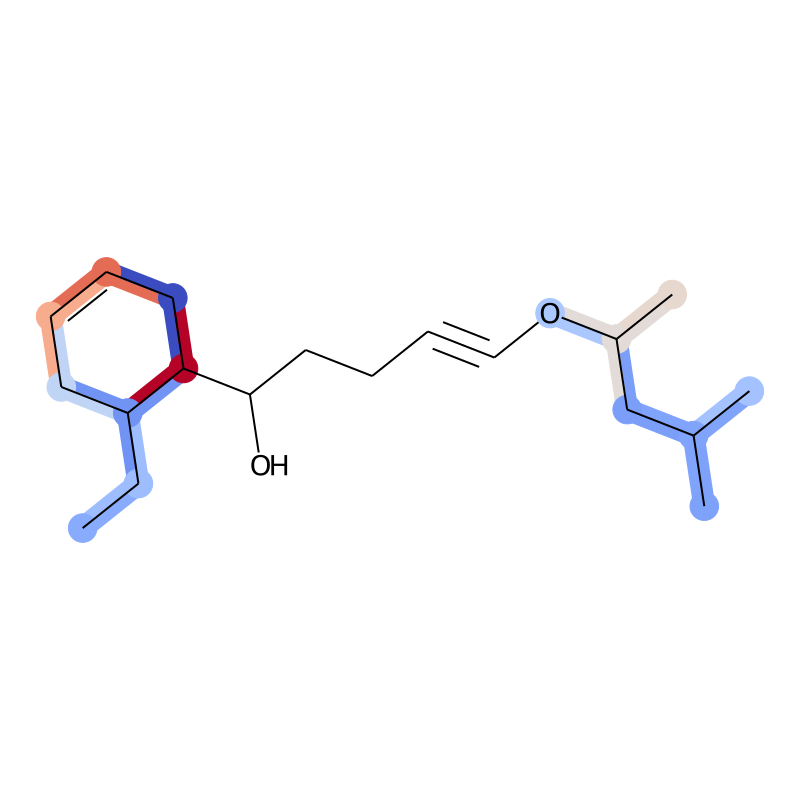

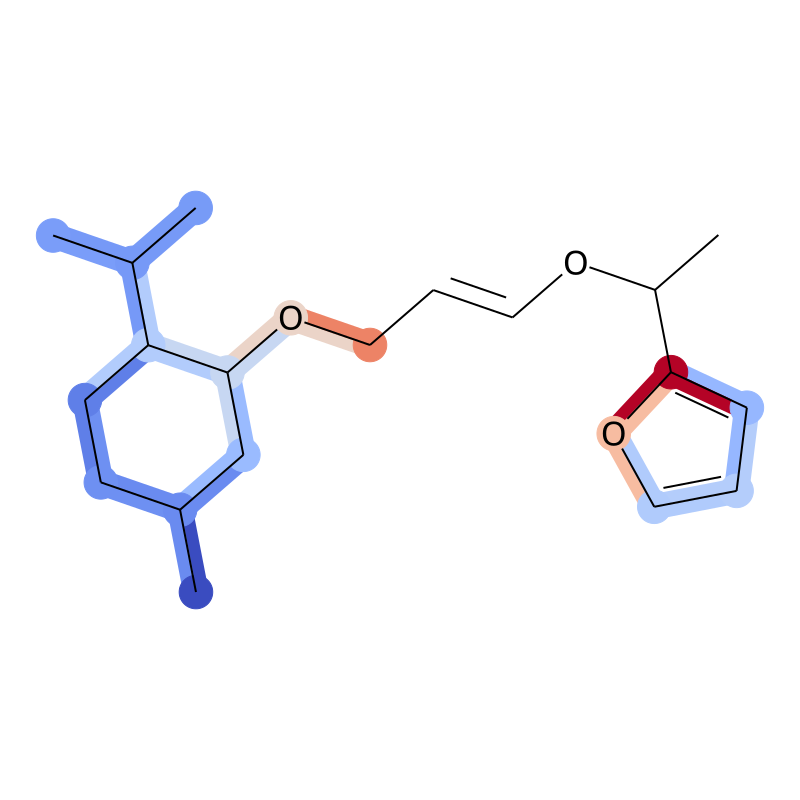

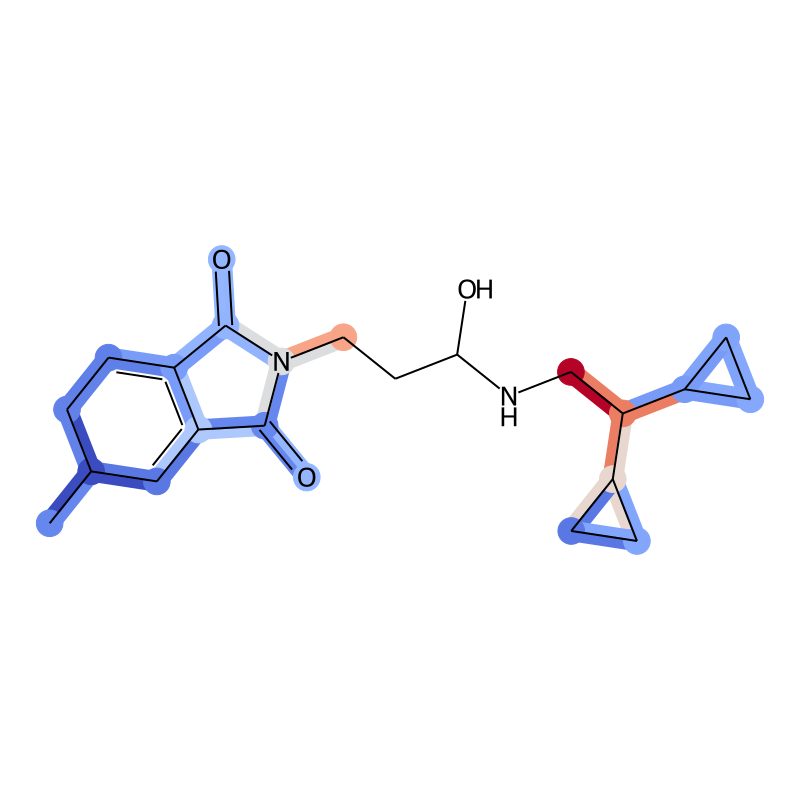

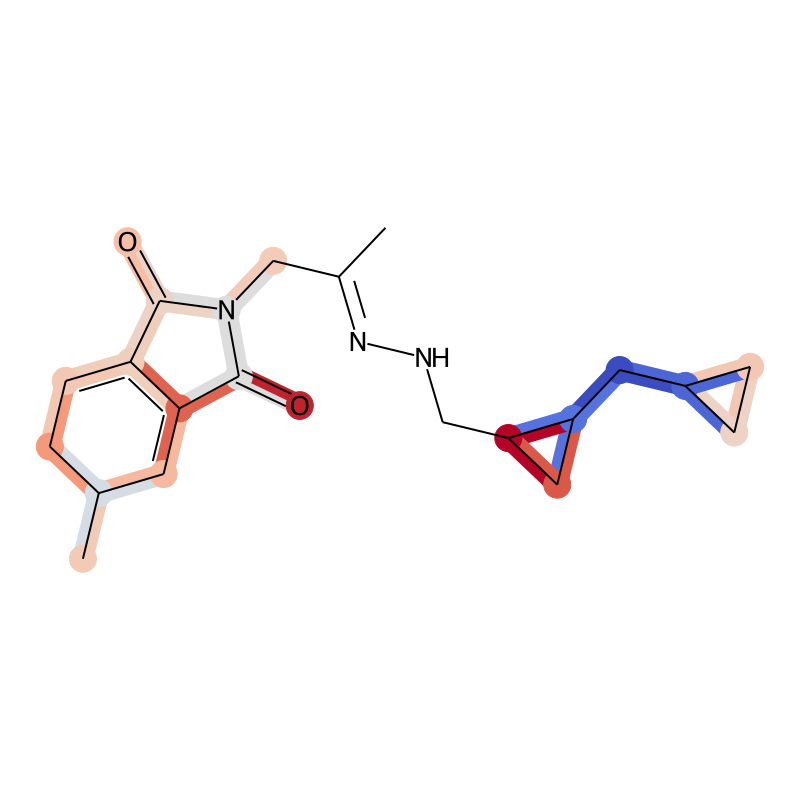

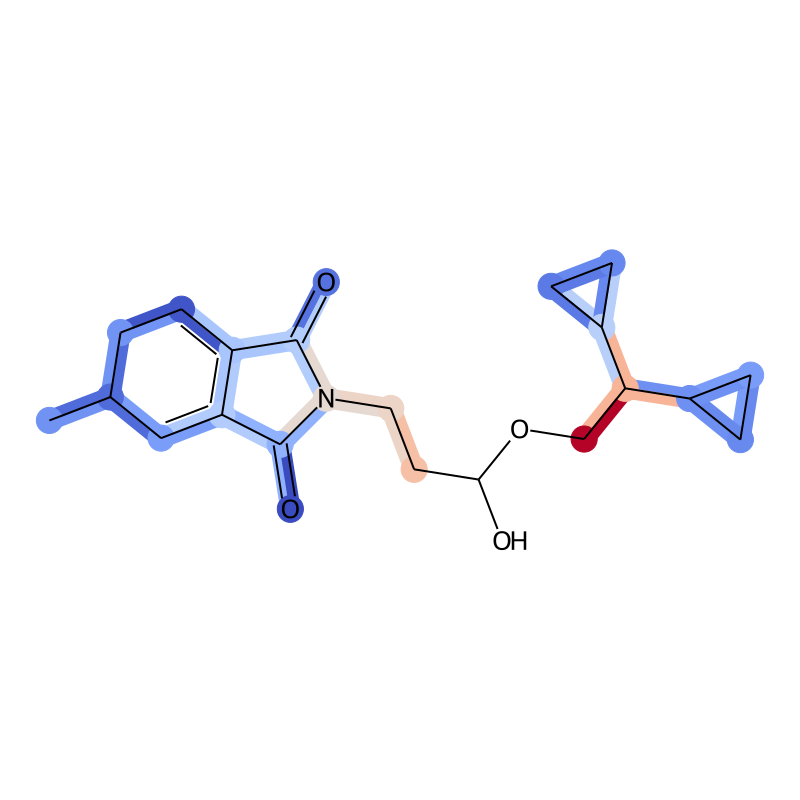

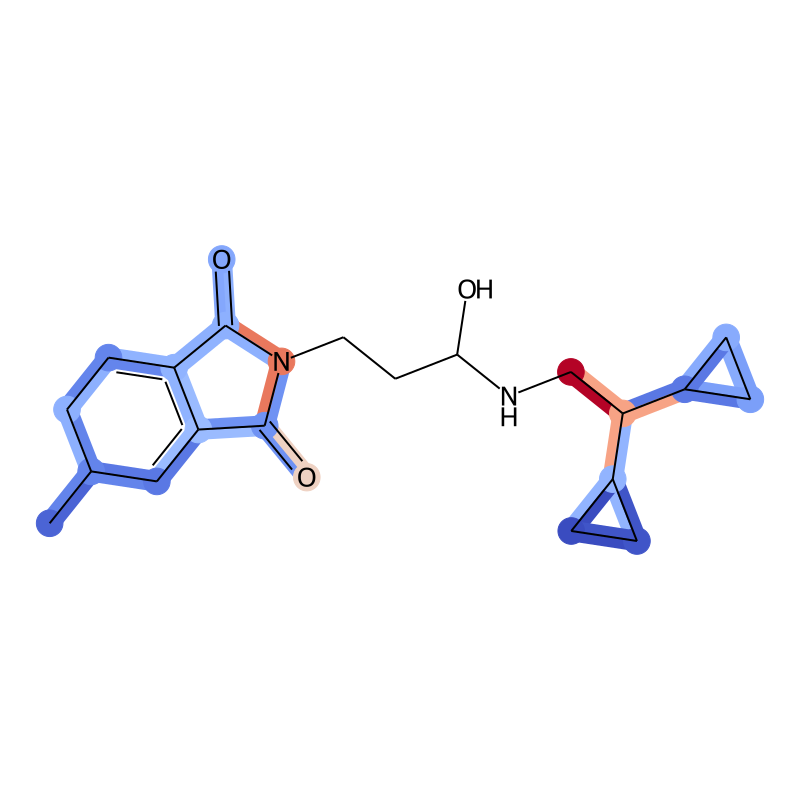

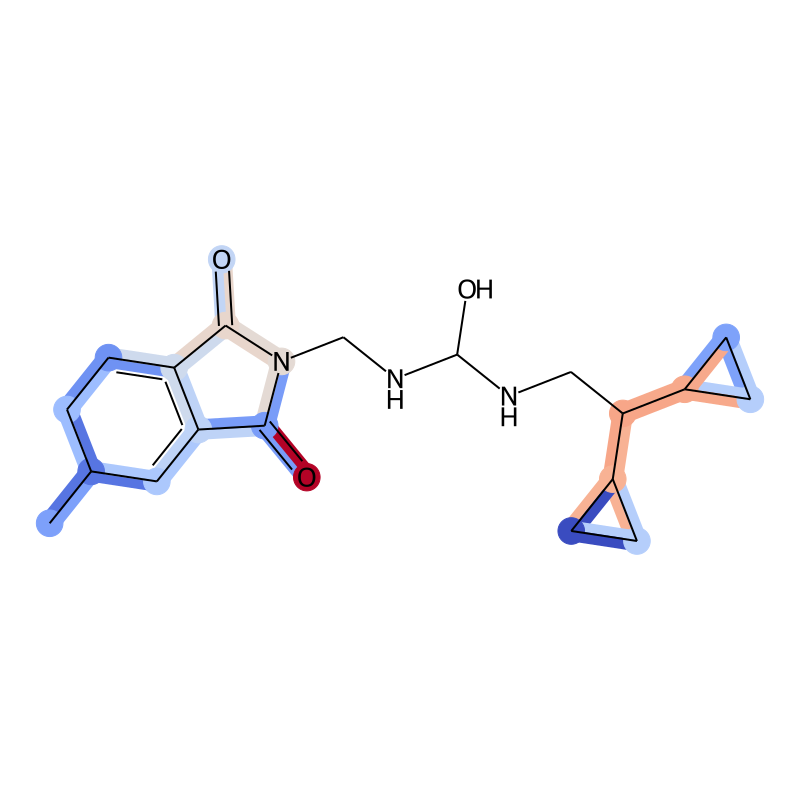

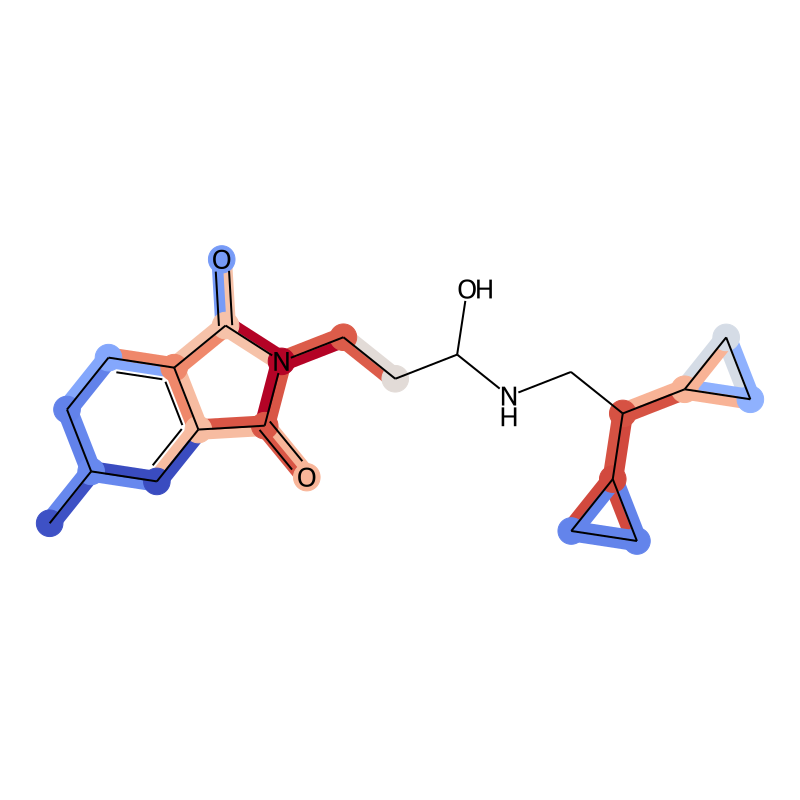

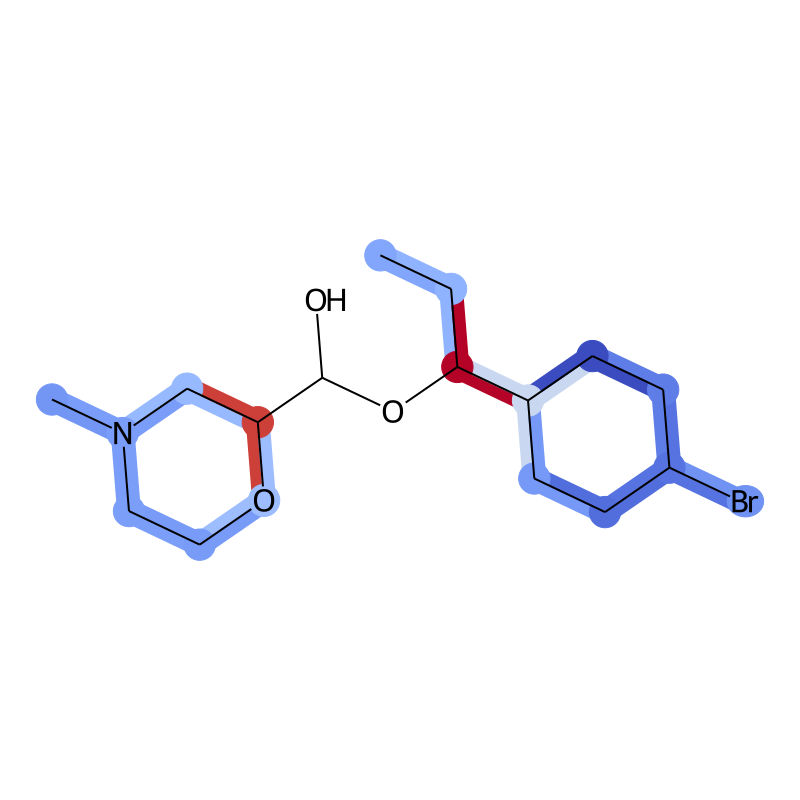

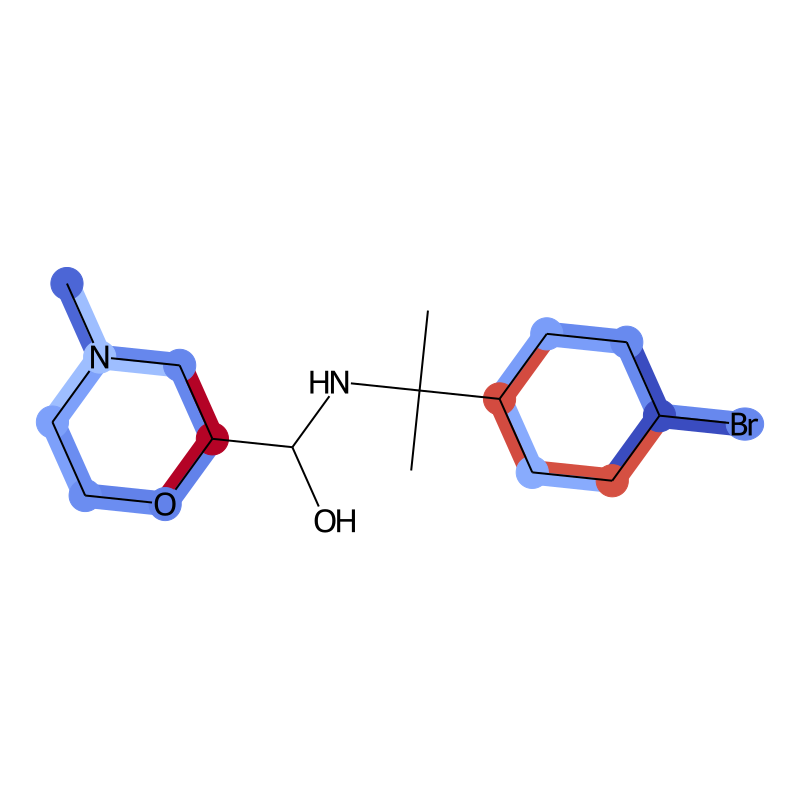

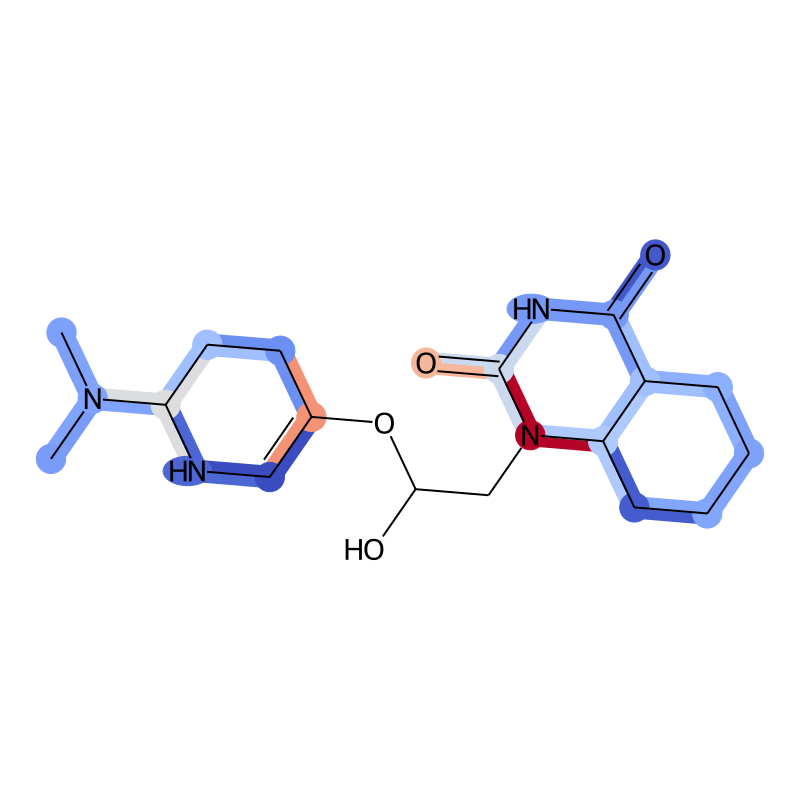

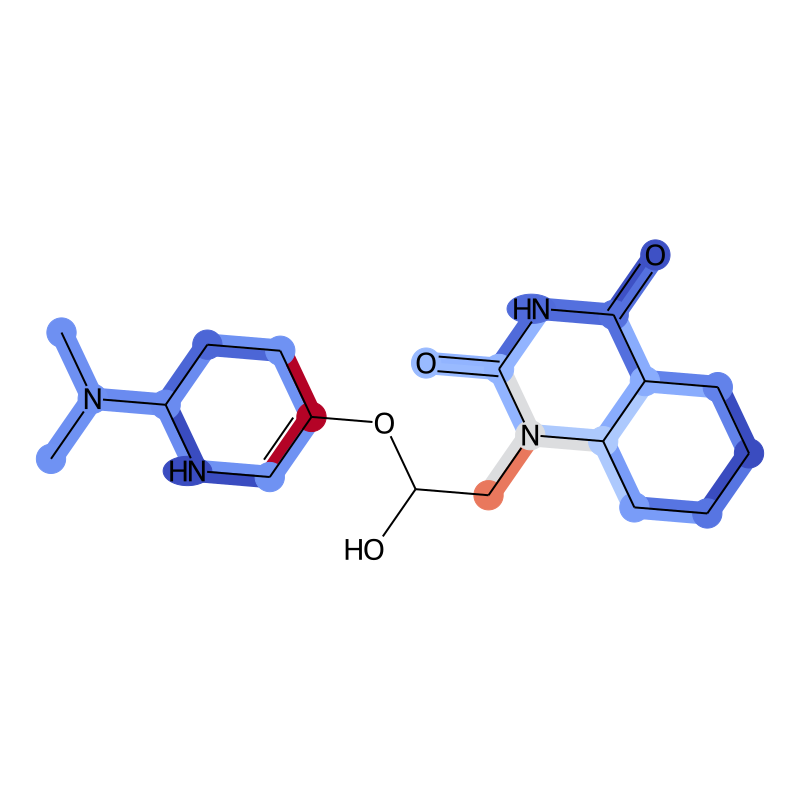

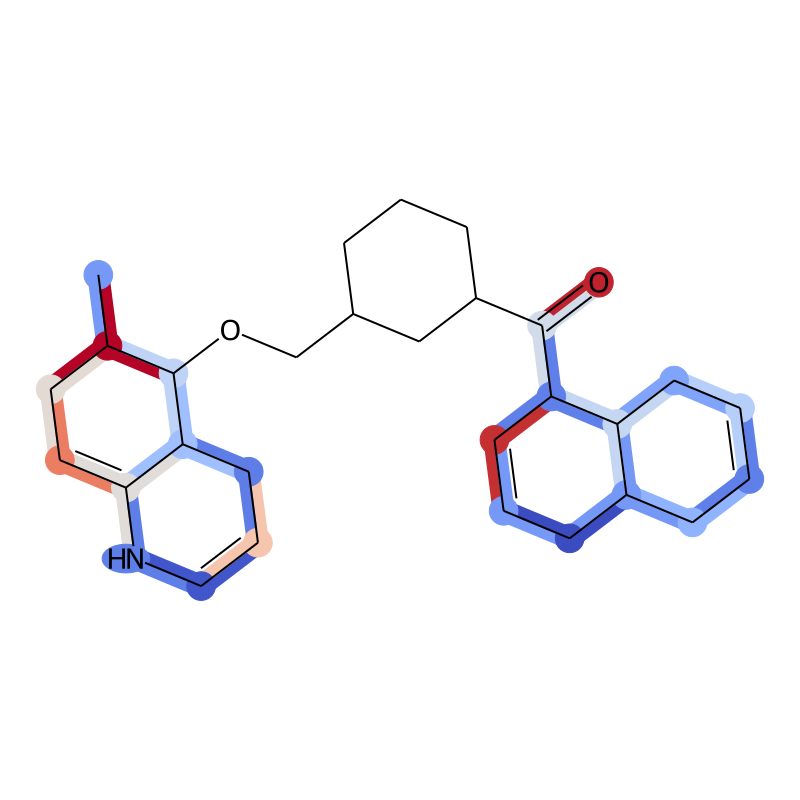

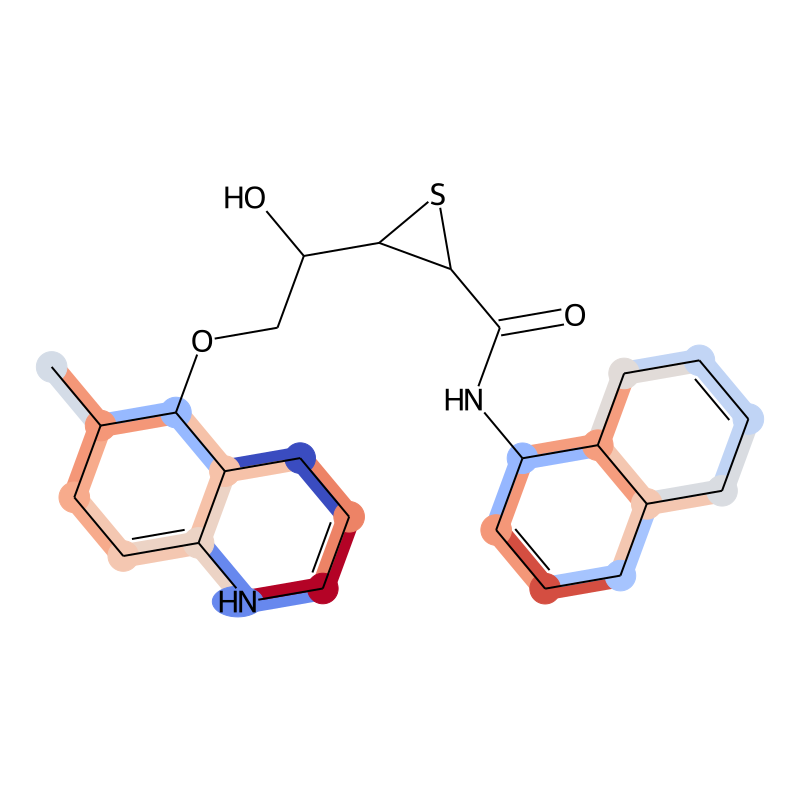

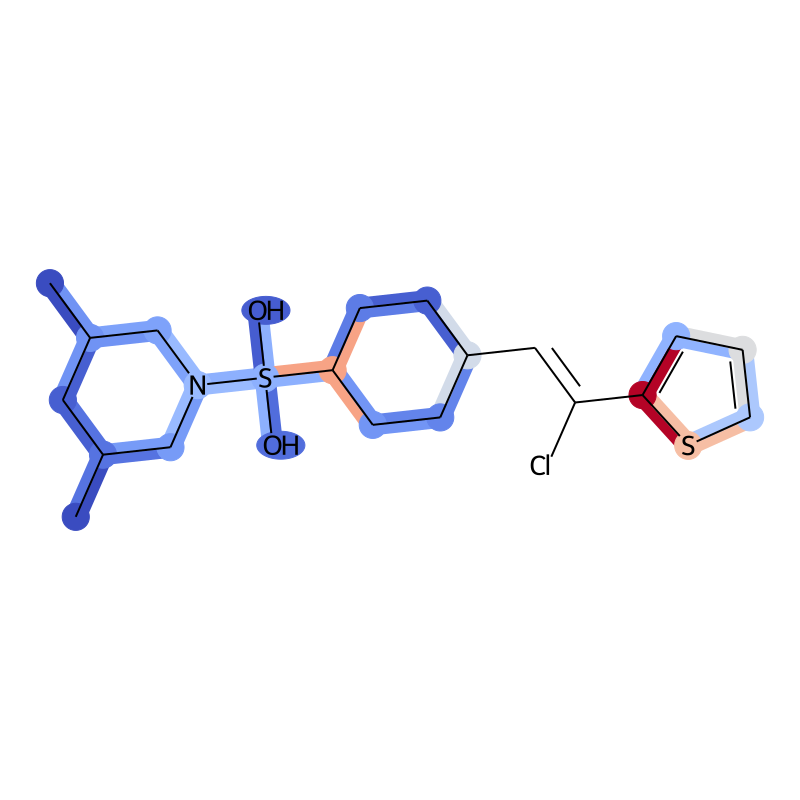

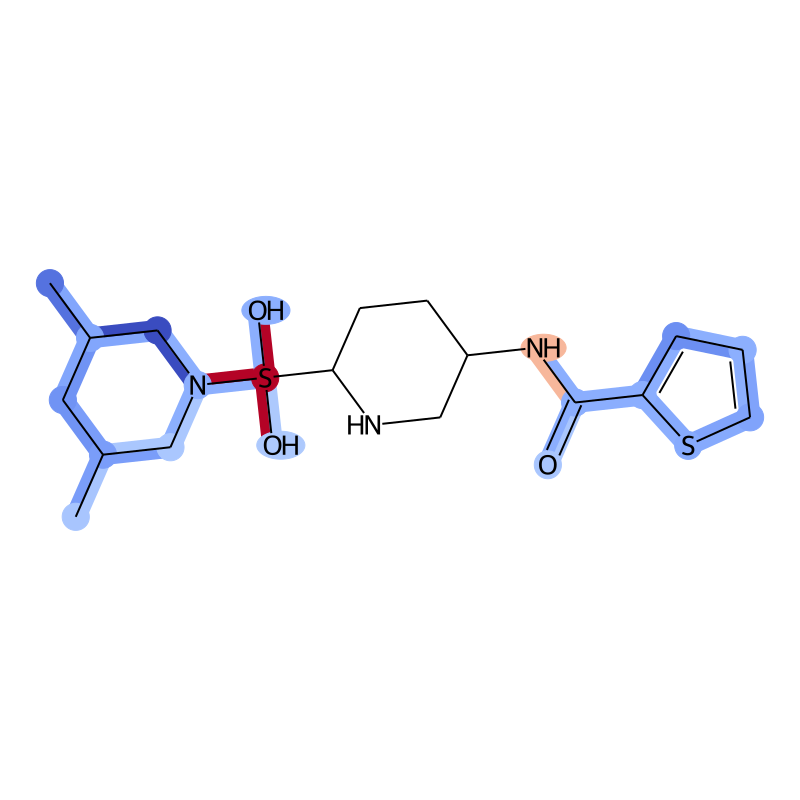

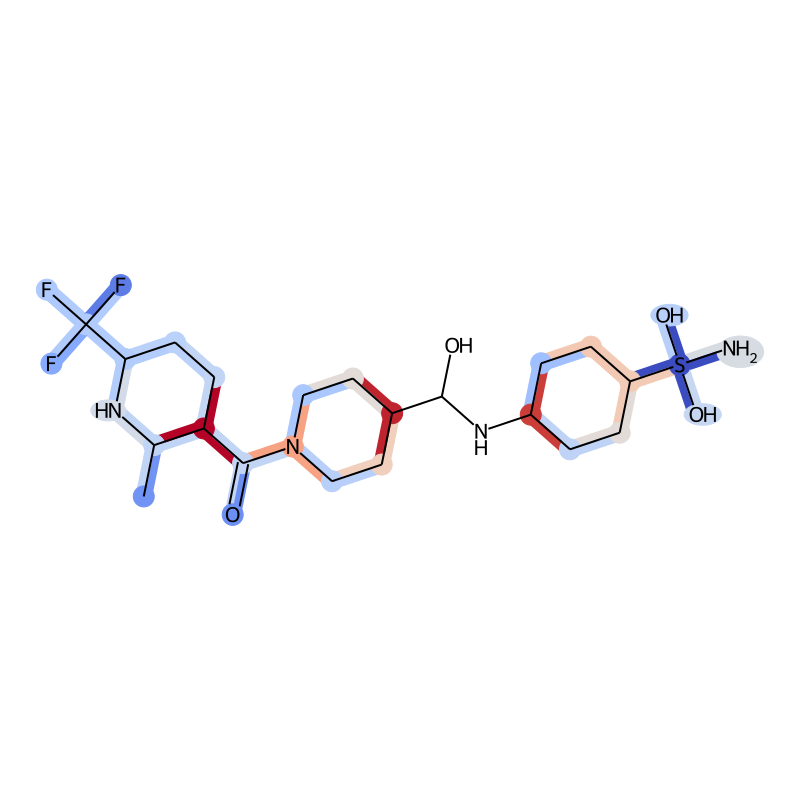

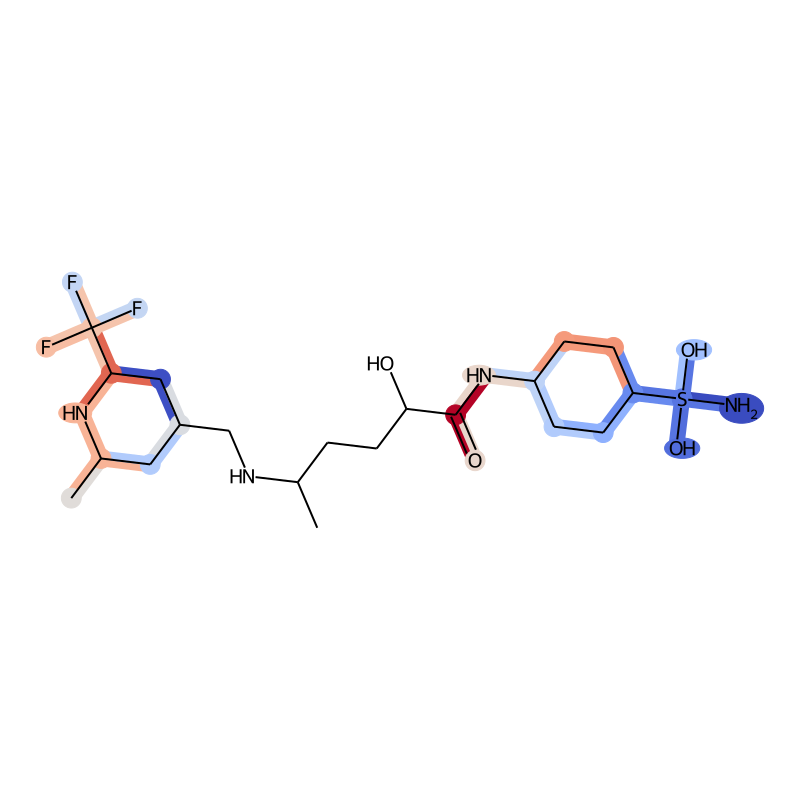

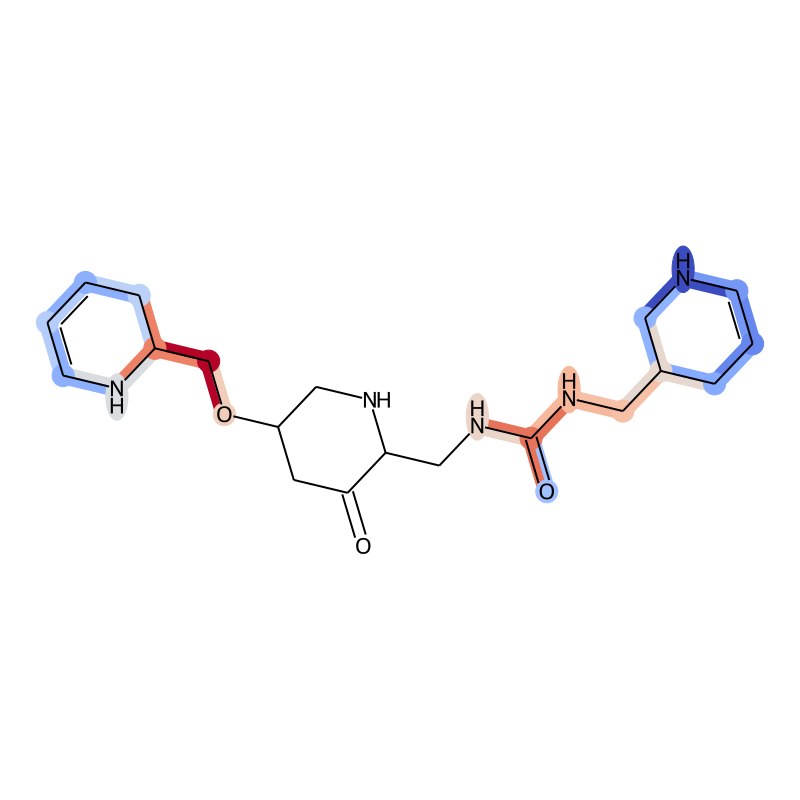

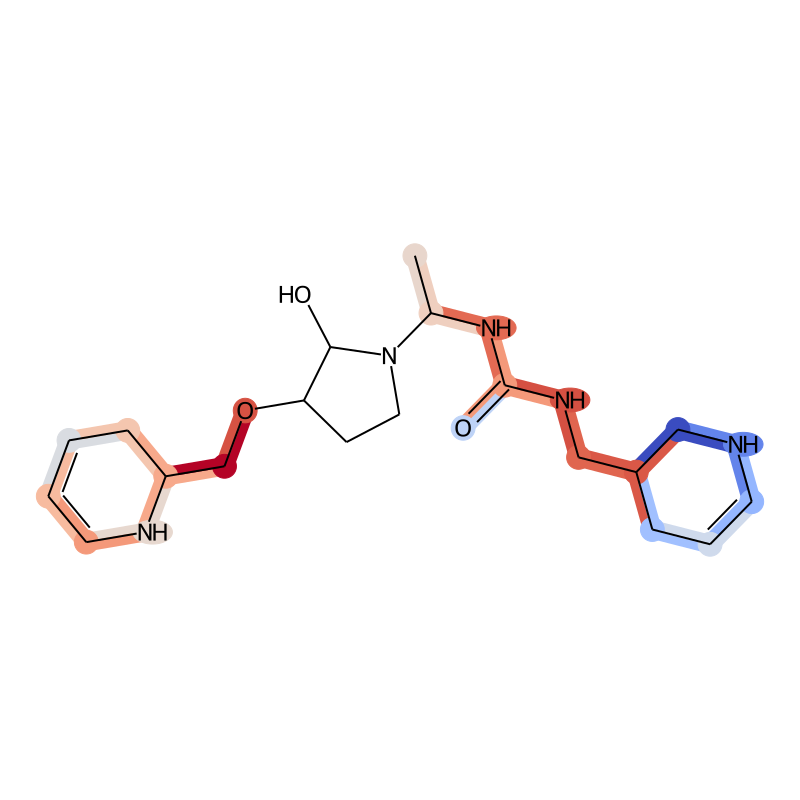

In [67]:
from collections import defaultdict
# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=False)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            if bond_order > 0:
                mol.AddBond(atom_map[idx1], atom_map[idx2], Chem.BondType.values[bond_order])

    # Highlight fragment atoms and edges
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    bond_colors = {}
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if begin_idx in highlight_colors and end_idx in highlight_colors:
            # Use the colors of the two connected atoms
            color1 = tuple(map(float, highlight_colors[begin_idx][:3]))  # Extract RGB values for atom 1
            color2 = tuple(map(float, highlight_colors[end_idx][:3]))  # Extract RGB values for atom 2 # Extract RGB values for atom 2
            bond_colors[bond.GetIdx()] = (color1, color2)  # Assign a tuple of two colors
    #uncomment for averaging colors
    # bond_colors = {}
    # for bond in mol.GetBonds():
    #     begin_idx = bond.GetBeginAtomIdx()
    #     end_idx = bond.GetEndAtomIdx()
    #     if begin_idx in highlight_colors and end_idx in highlight_colors:
    #         # Average the colors of the two connected atoms
    #         color1 = np.array(highlight_colors[begin_idx][:3])
    #         color2 = np.array(highlight_colors[end_idx][:3])
    #         averaged_color = tuple((color1 + color2) / 2)
    #         bond_colors[bond.GetIdx()] = averaged_color
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    # atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    atom_colors = {idx: list(map(float, color[:3])) for idx, color in highlight_colors.items()}  # Convert to lists of floats
    atom_colors = {key: [tuple(value)] for key, value in atom_colors.items()}
    bond_colors = {key: list(value) for key, value in bond_colors.items()}
    # Use DrawMoleculeWithHighlights for visualization
    drawer = Draw.MolDraw2DCairo(800, 800)
    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    drawer.DrawMoleculeWithHighlights(
        mol,
        "",  # Legend
        atom_colors,  # Atom colors (highlight_atom_map)
        bond_colors,  # Bond colors (highlight_bond_map)
        {},  # Atom radii
        {}  # Bond linewidth multipliers
        # confId=-1  # Default conformer ID
    )
    drawer.FinishDrawing()
    # Convert the drawing to a PNG image
    png_data = drawer.GetDrawingText()
    with open("temp_image.png", "wb") as f:
        f.write(png_data)

    # Load the PNG image using PIL
    img = Image.open("temp_image.png")
    
    img.show()
    
    # img.show()
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "mappingnoaverage")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    # img.save(output_file, dpi=(300, 300))

Visualization with atom importance, no edges and linker highligthed

Aromatic bonds: [7, 8, 9, 10, 12, 15, 16, 17, 22, 23, 24, 25, 26, 27]
Aromatic rings: [[6, 20, 18, 9, 8, 7], [22, 21, 24, 25, 23]]


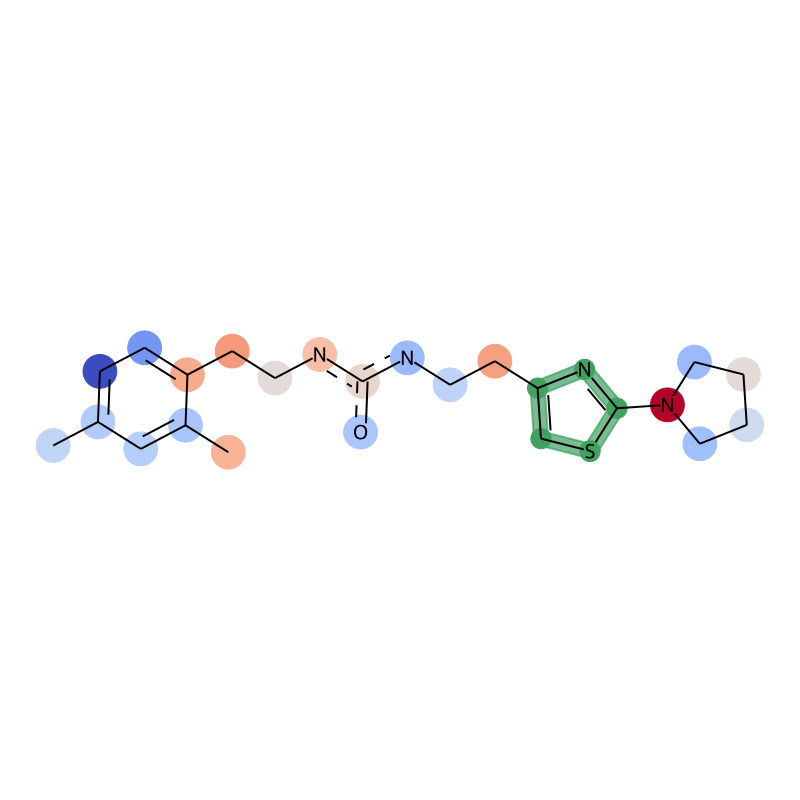

Aromatic bonds: [1, 2, 3, 4, 6, 10, 11, 12, 13, 14, 15, 21, 24, 25, 26, 27]
Aromatic rings: [[1, 9, 7, 4, 3, 2], [10, 11, 12, 18, 19]]


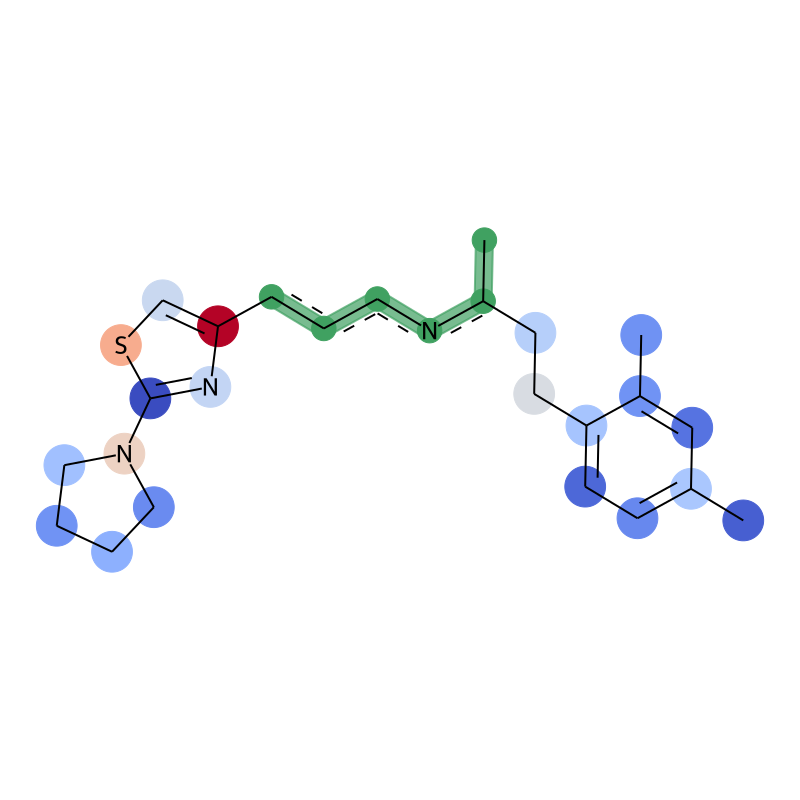

Aromatic bonds: [1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 14, 21, 27]
Aromatic rings: [[1, 8, 6, 4, 3, 2], [9, 10, 11, 17, 18]]


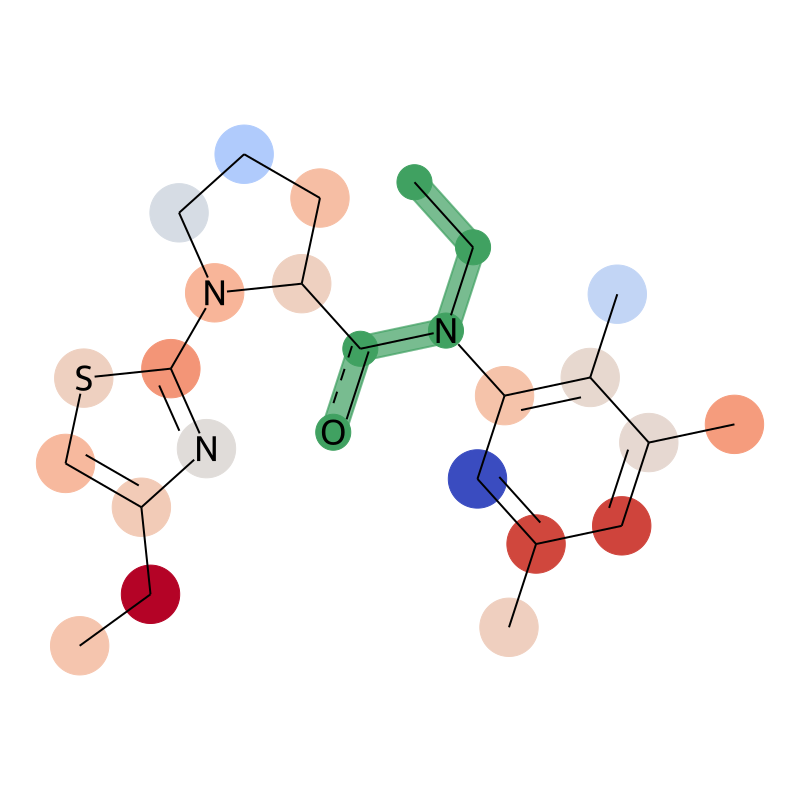

Aromatic bonds: [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 20, 23, 27]
Aromatic rings: [[1, 7, 5, 4, 3, 2], [8, 9, 10, 16, 17]]


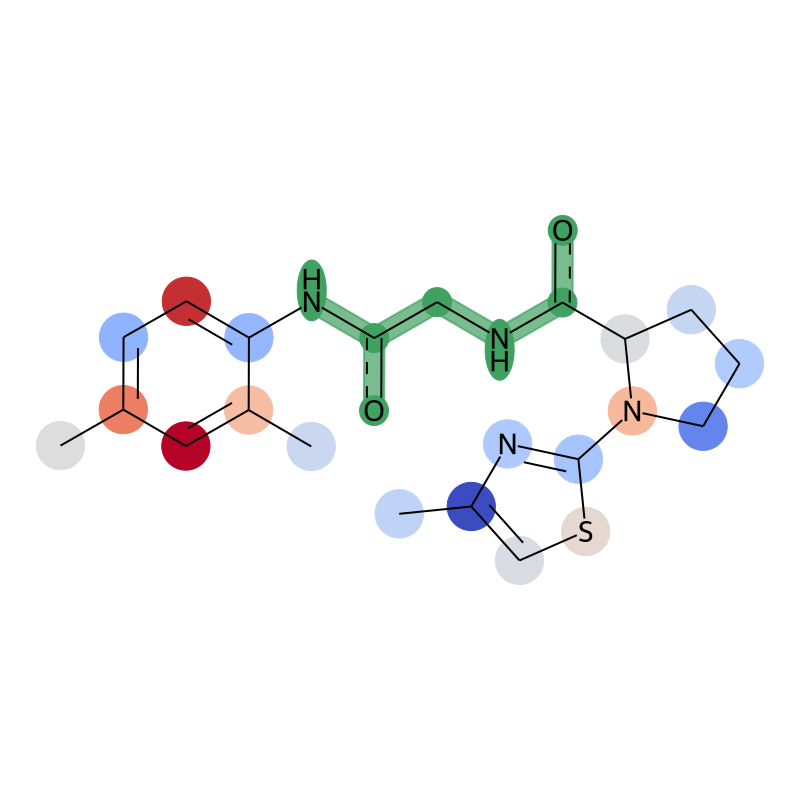

Aromatic bonds: [1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 20, 24, 25, 26]
Aromatic rings: [[1, 8, 6, 4, 3, 2], [9, 10, 11, 17, 18]]


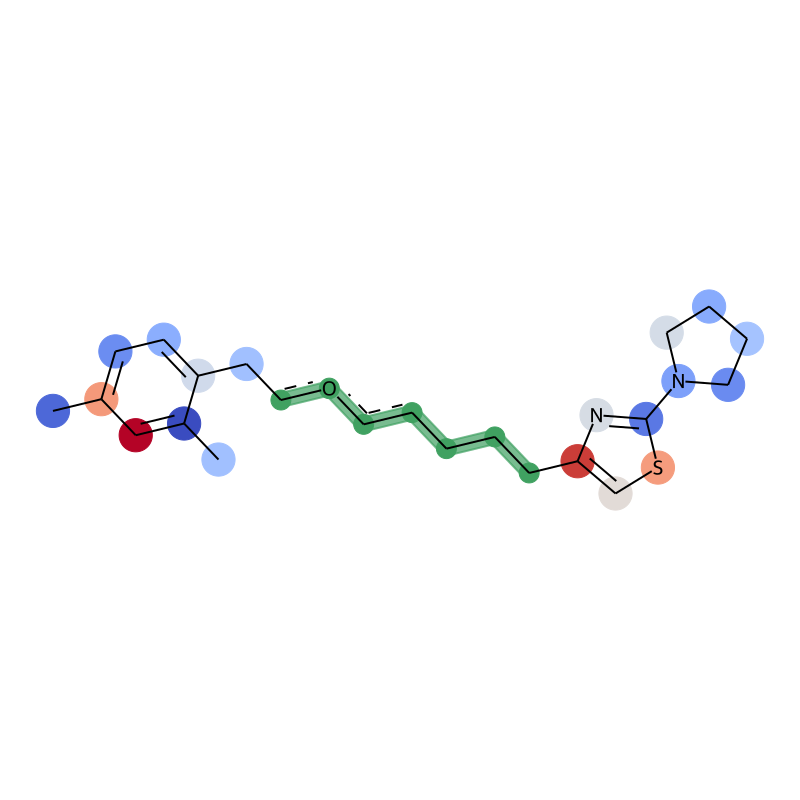

Aromatic bonds: [1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 19, 21]
Aromatic rings: [[1, 7, 5, 4, 3, 2], [8, 9, 10, 16, 17]]


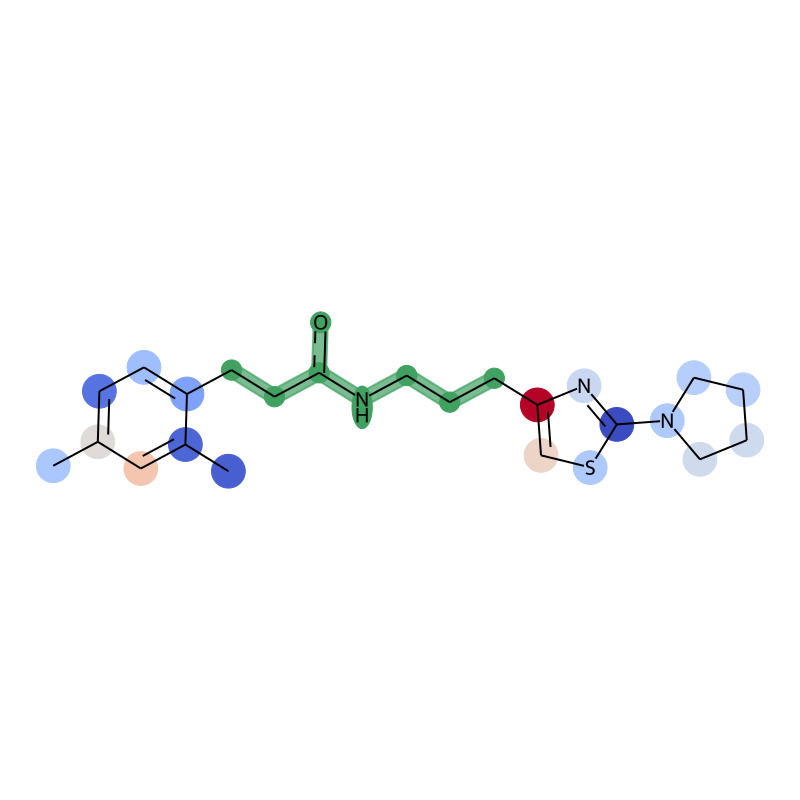

Aromatic bonds: [1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 19, 22, 25]
Aromatic rings: [[1, 7, 5, 4, 3, 2], [8, 9, 10, 16, 17]]


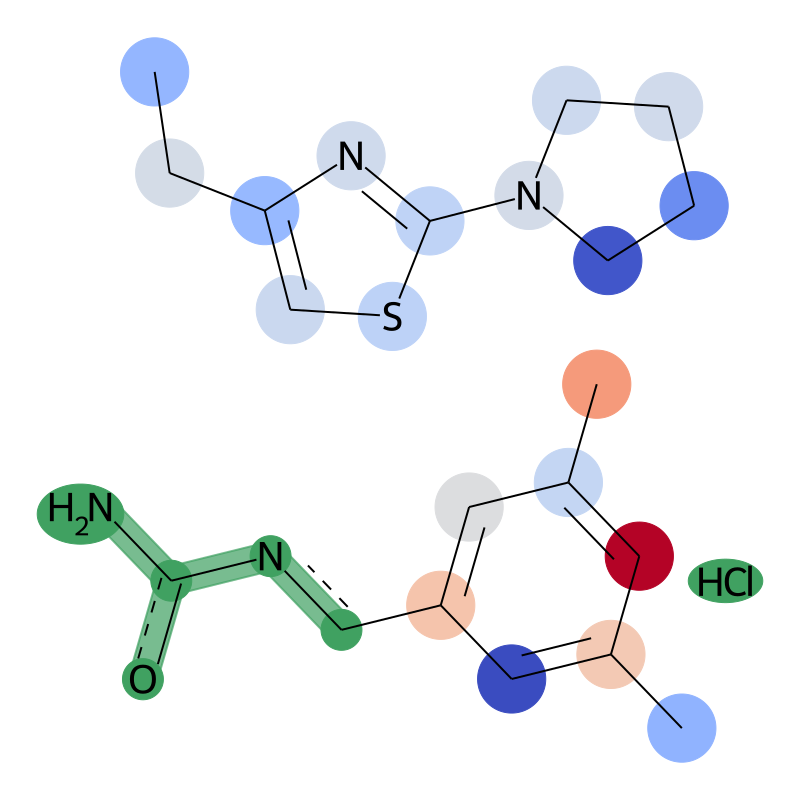

Aromatic bonds: [1, 2, 3, 4, 6, 9, 10, 11, 12, 13, 14, 20, 22, 23, 25]
Aromatic rings: [[1, 8, 6, 4, 3, 2], [9, 10, 11, 17, 18]]


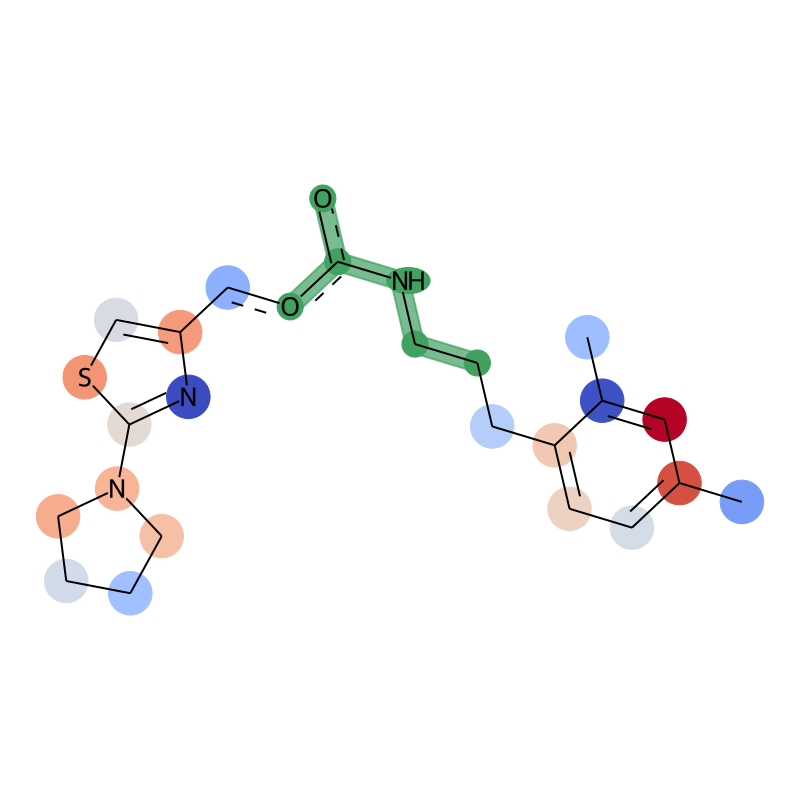

Aromatic bonds: [1, 2, 3, 5, 6, 7, 9, 11, 17, 18, 19, 20, 21, 22, 23, 27, 28]
Aromatic rings: [[1, 7, 6, 5, 3, 2], [16, 17, 18, 19, 20, 15]]


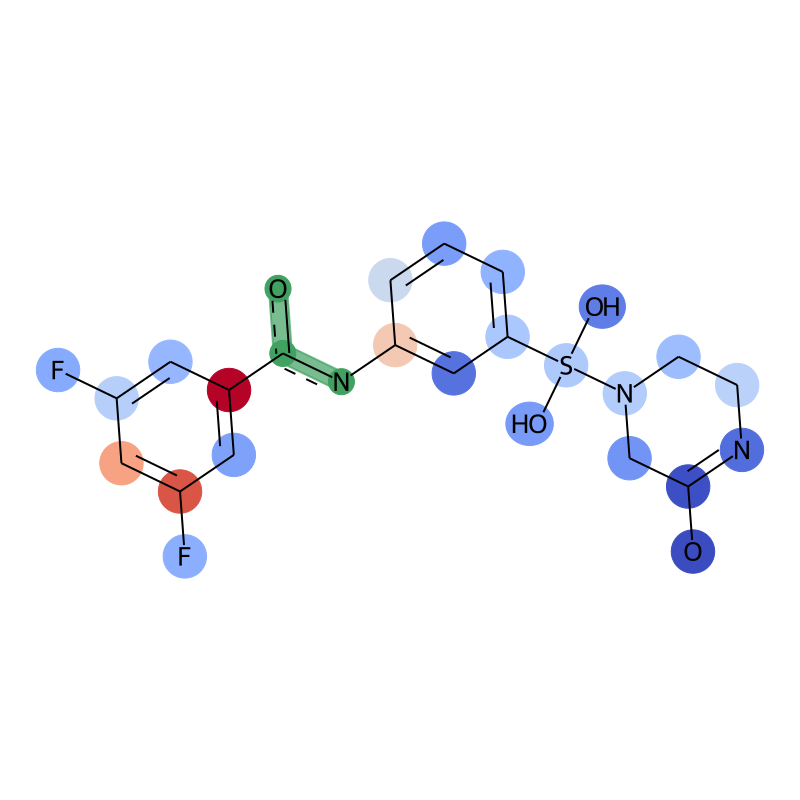

Aromatic bonds: [0, 1, 4, 5, 6, 8, 9, 11, 12, 14, 20, 23, 24, 25, 26, 27, 28]
Aromatic rings: [[4, 5, 7, 8, 10, 3], [22, 25, 24, 23, 26, 21]]


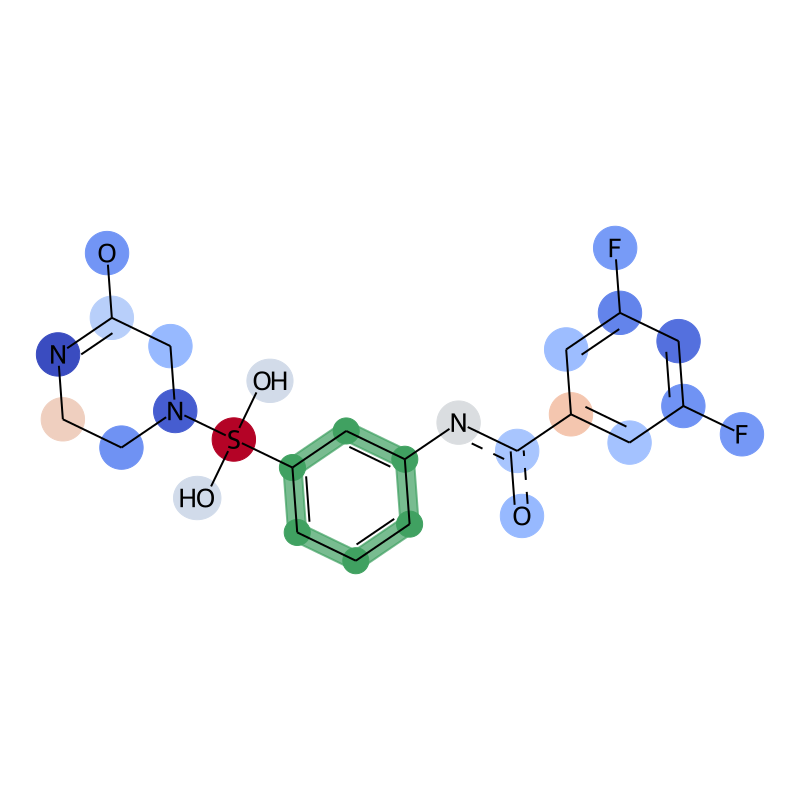

Aromatic bonds: [2, 3, 4, 5, 6, 7, 14, 15, 16, 17, 18]
Aromatic rings: [[2, 7, 6, 5, 4, 3]]


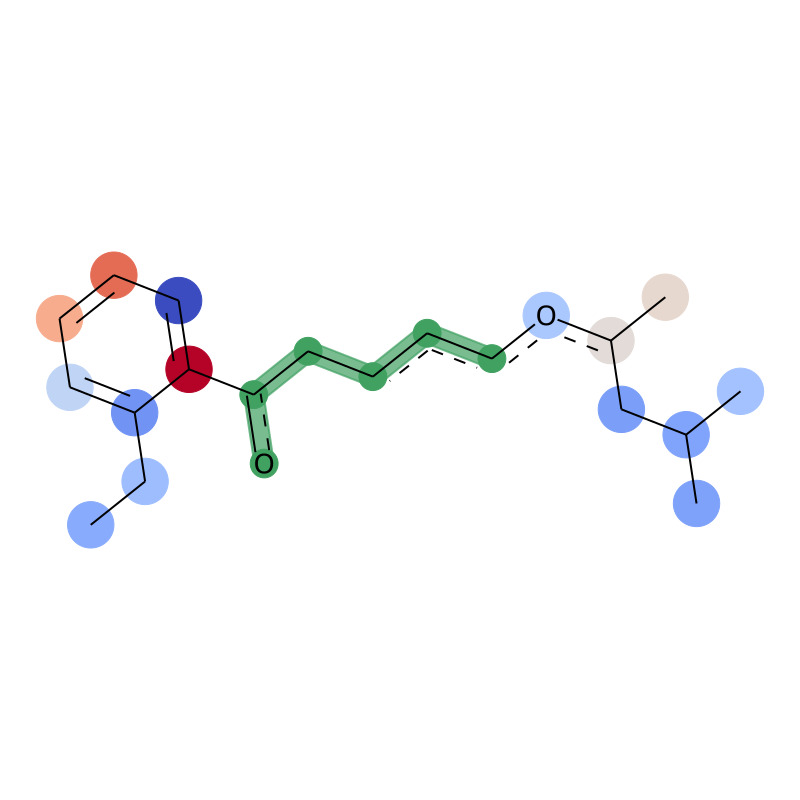

Aromatic bonds: [1, 2, 3, 4, 6, 9, 10, 11, 13, 14, 15, 17, 18, 20, 22]
Aromatic rings: [[1, 11, 8, 4, 3, 2], [12, 13, 14, 15, 16]]


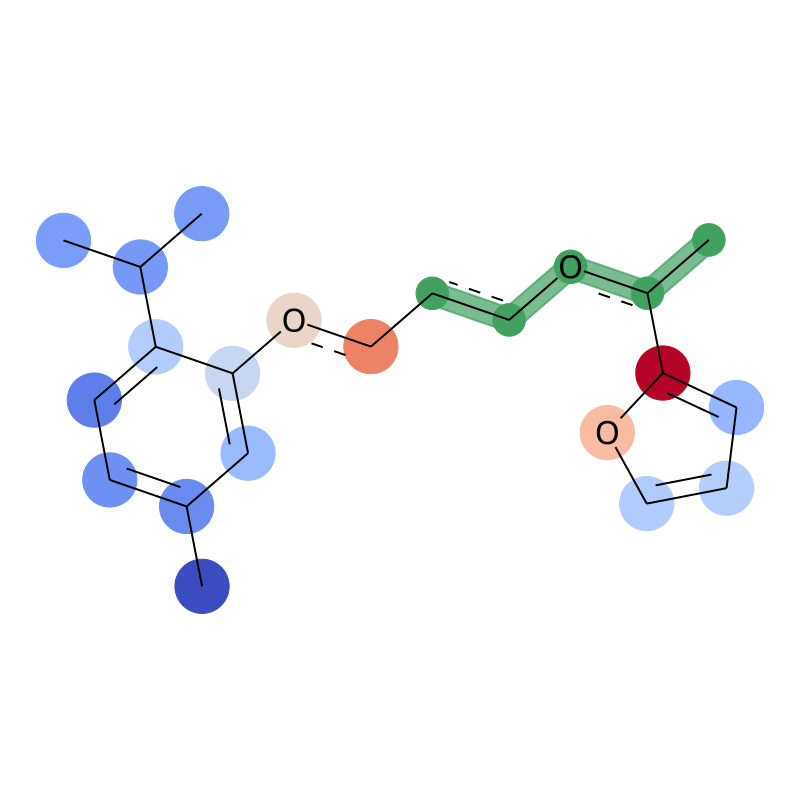

Aromatic bonds: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 27]
Aromatic rings: [[9, 14, 13, 12, 11, 10], [15, 13, 12, 19, 17]]


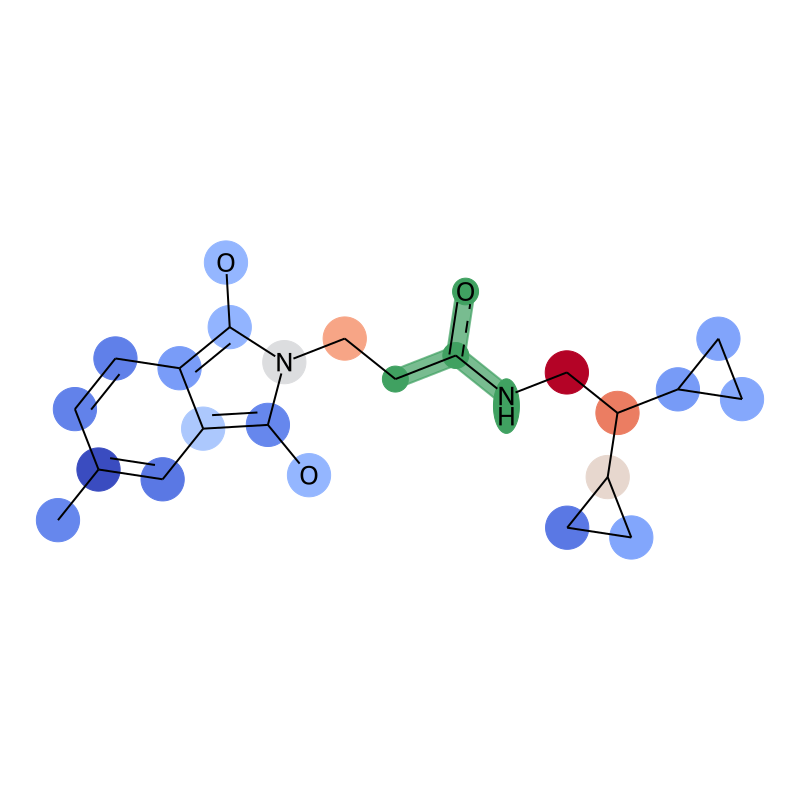

Aromatic bonds: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 24, 25]
Aromatic rings: [[8, 13, 12, 11, 10, 9], [14, 12, 11, 18, 16]]


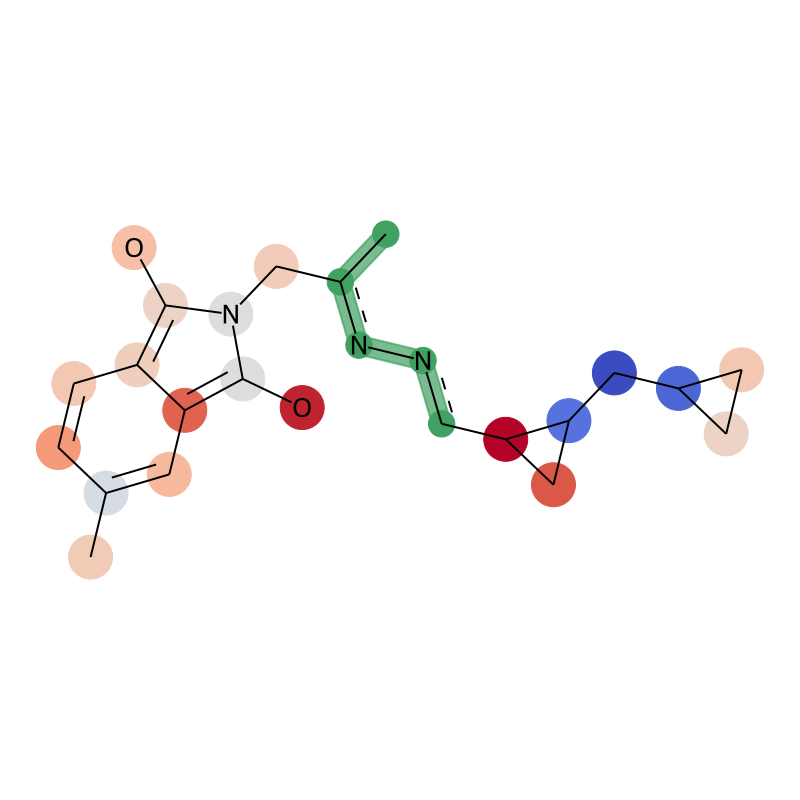

Aromatic bonds: [6, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 26, 27]
Aromatic rings: [[9, 14, 13, 12, 11, 10], [15, 13, 12, 20, 17]]


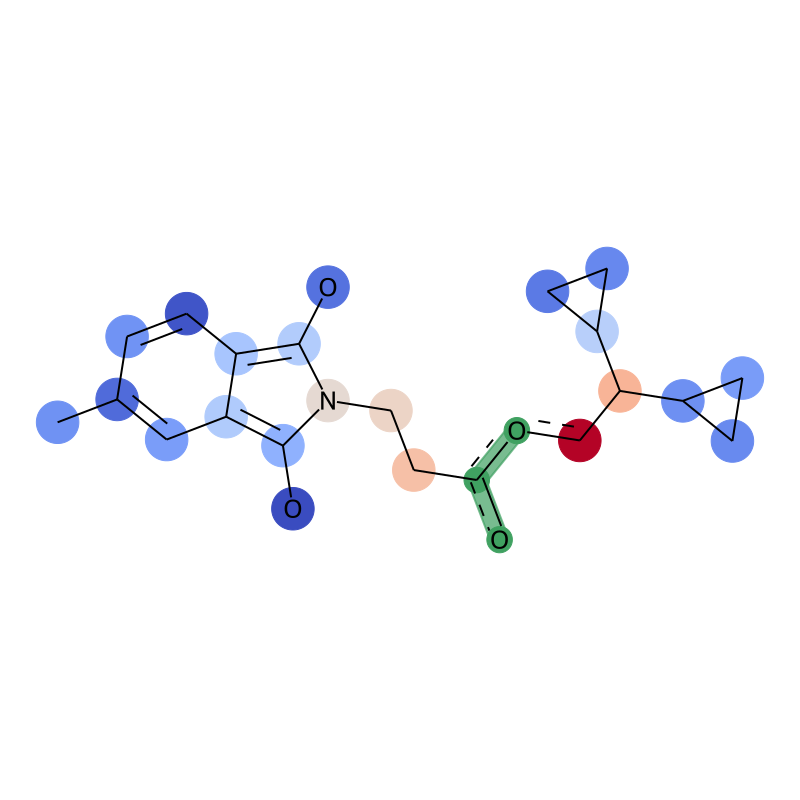

Aromatic bonds: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 25]
Aromatic rings: [[9, 14, 13, 12, 11, 10], [15, 13, 12, 18, 17]]


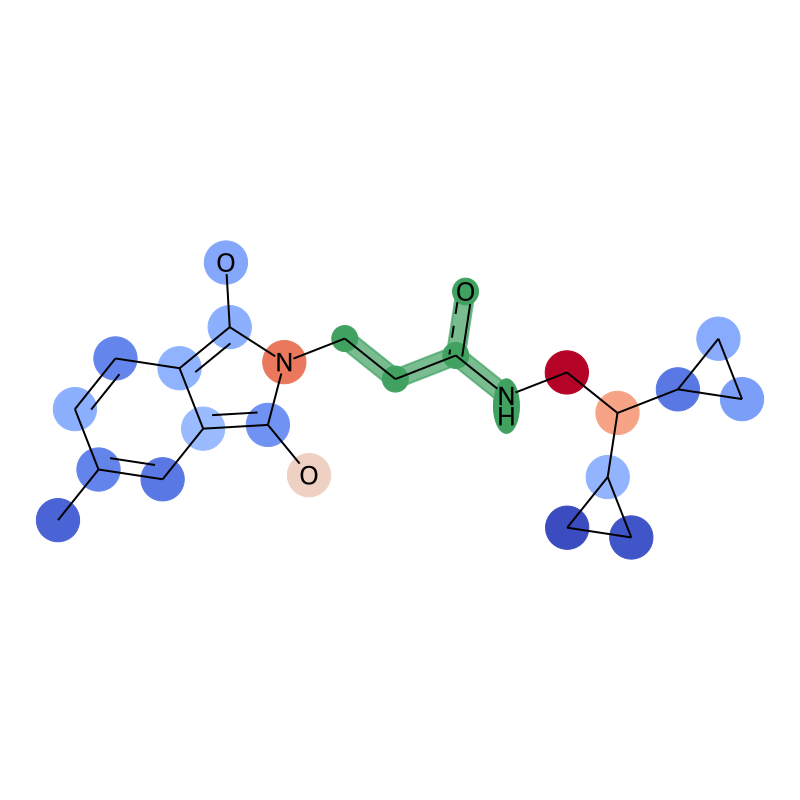

Aromatic bonds: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24]
Aromatic rings: [[8, 13, 12, 11, 10, 9], [14, 12, 11, 17, 16]]


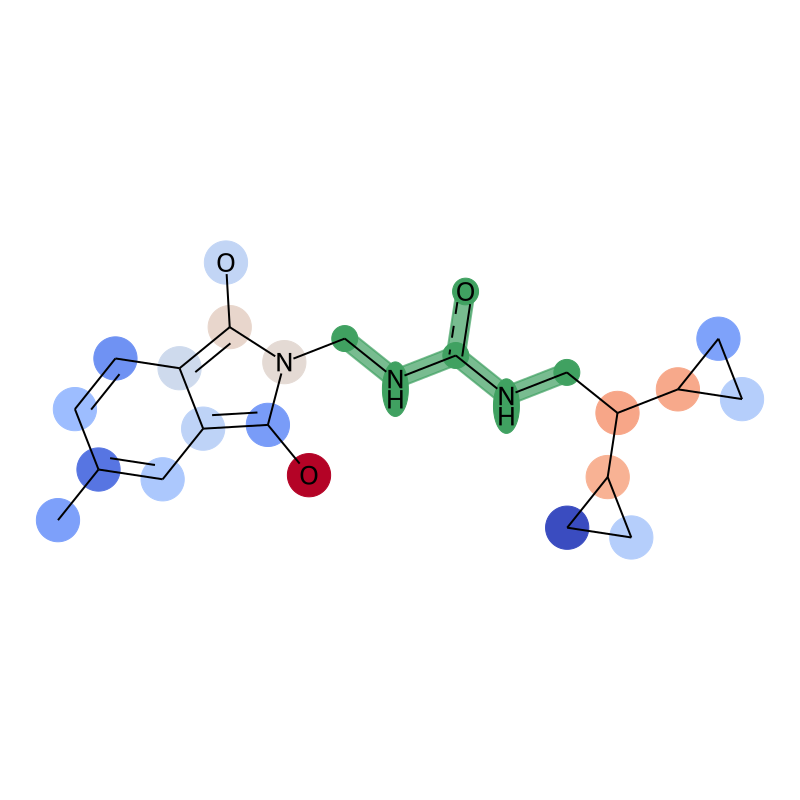

Aromatic bonds: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 24, 26]
Aromatic rings: [[8, 13, 12, 11, 10, 9], [14, 12, 11, 19, 16]]


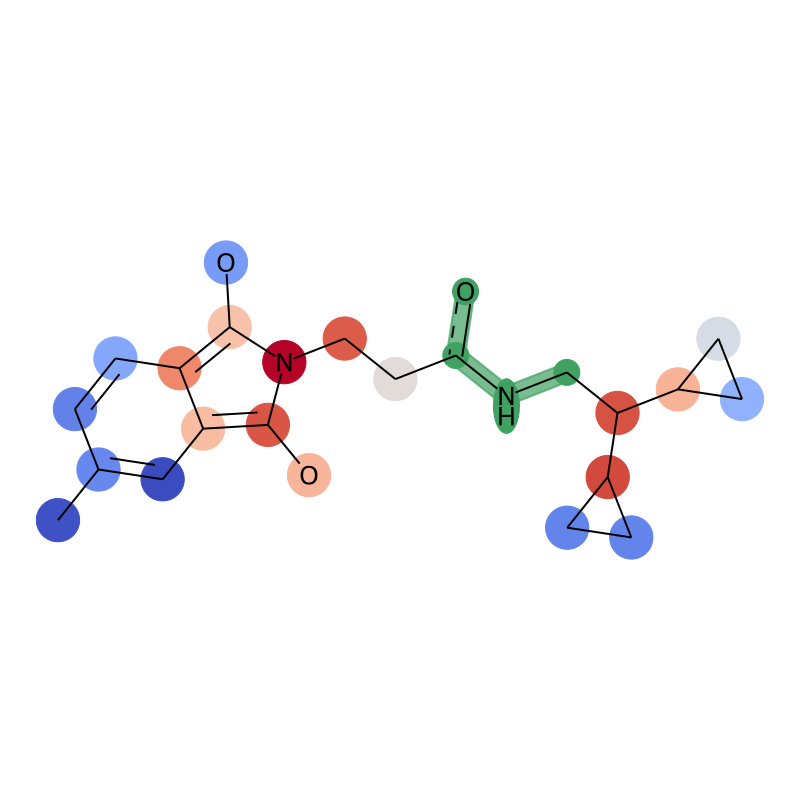

Aromatic bonds: [3, 4, 5, 6, 7, 9, 10, 19, 20]
Aromatic rings: [[4, 5, 6, 8, 9, 3]]


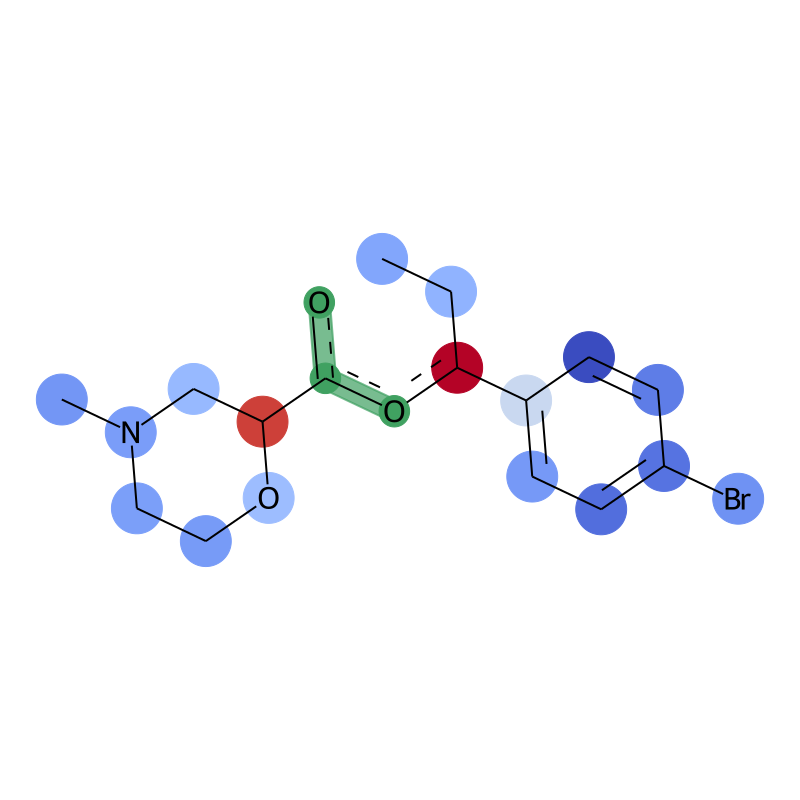

Aromatic bonds: [1, 2, 3, 4, 5, 7, 17]
Aromatic rings: [[1, 6, 5, 4, 3, 2]]


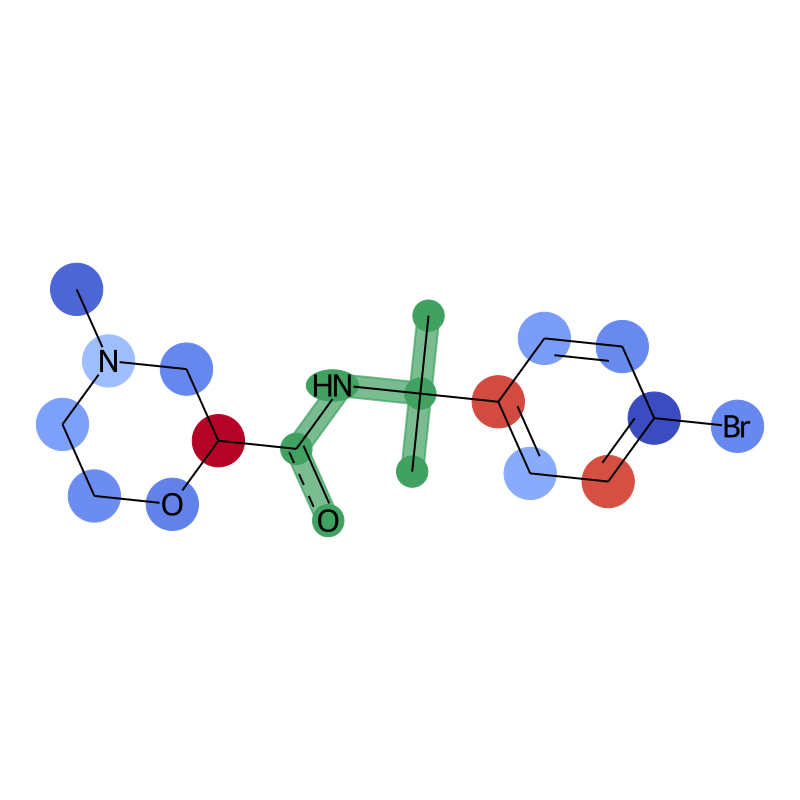

Aromatic bonds: [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25]
Aromatic rings: [[3, 8, 7, 6, 5, 4], [16, 17, 18, 19, 20, 15]]
Error while drawing molecule with highlights: Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16 17 18 19 20
Aromatic bonds: [3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 26]
Aromatic rings: [[3, 8, 7, 6, 5, 4], [17, 18, 19, 20, 21, 16]]
Error while drawing molecule with highlights: Can't kekulize mol.  Unkekulized atoms: 10 11 12 16 17 18 19 20 21
Aromatic bonds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29]
Aromatic rings: [[1, 10, 9, 4, 3, 2], [5, 6, 7, 8, 9, 4], [14, 15, 16, 17, 22, 13], [18, 19, 20, 21, 22, 17]]


[16:45:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 15 16 17 18 19 20
[16:45:21] Can't kekulize mol.  Unkekulized atoms: 10 11 12 16 17 18 19 20 21


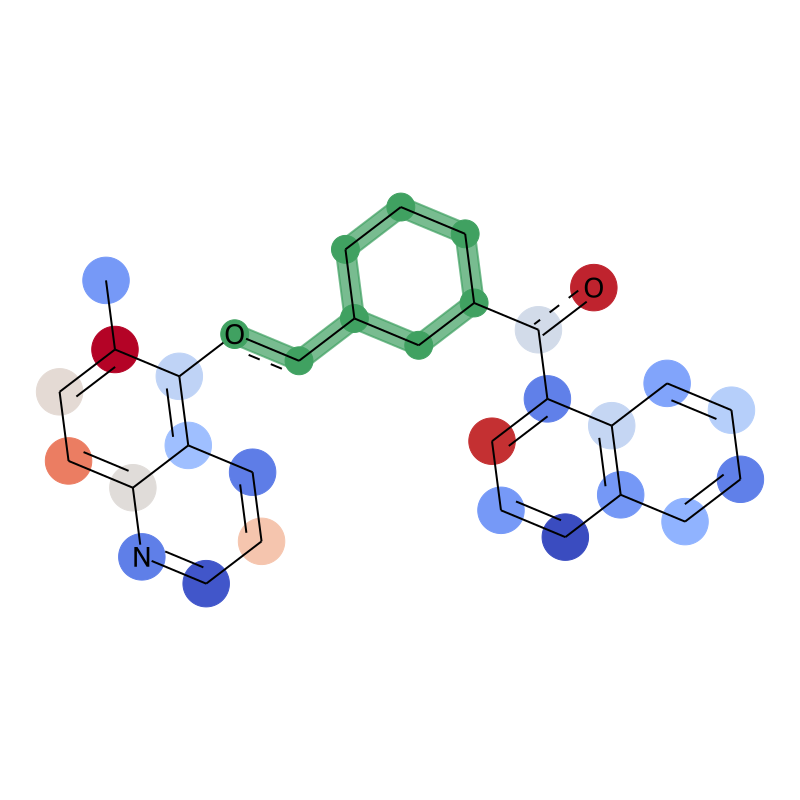

Aromatic bonds: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 28, 30, 34]
Aromatic rings: [[1, 10, 9, 4, 3, 2], [5, 6, 7, 8, 9, 4], [11, 20, 19, 14, 13, 12], [15, 16, 17, 18, 19, 14]]
Error while drawing molecule with highlights: Can't kekulize mol.  Unkekulized atoms: 21 26
Aromatic bonds: [11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 24, 26]
Aromatic rings: [[11, 12, 13, 14, 15, 10], [17, 18, 19, 20, 21]]


[16:45:21] Can't kekulize mol.  Unkekulized atoms: 21 26


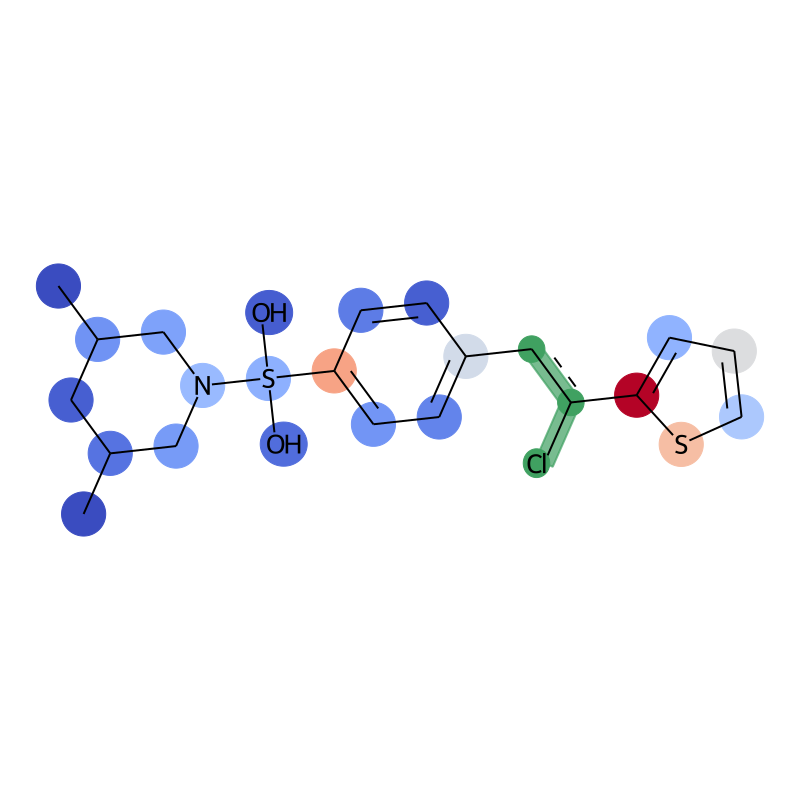

Aromatic bonds: [11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
Aromatic rings: [[15, 14, 18, 17, 16], [19, 24, 21, 22, 20, 23]]


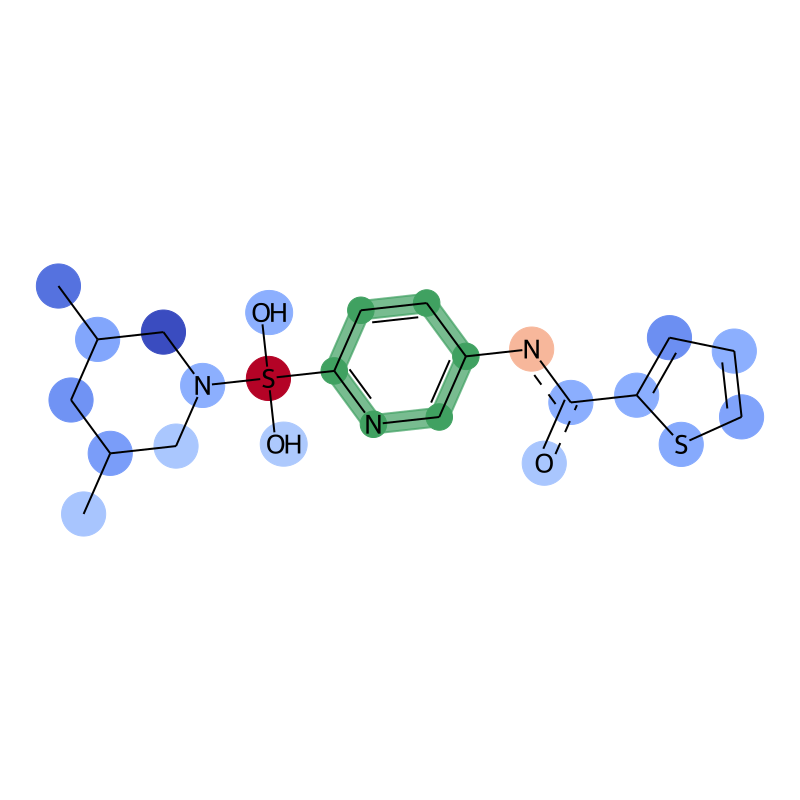

Aromatic bonds: [1, 2, 3, 5, 9, 10, 12, 13, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Aromatic rings: [[1, 10, 9, 8, 3, 2], [23, 28, 27, 26, 25, 24]]


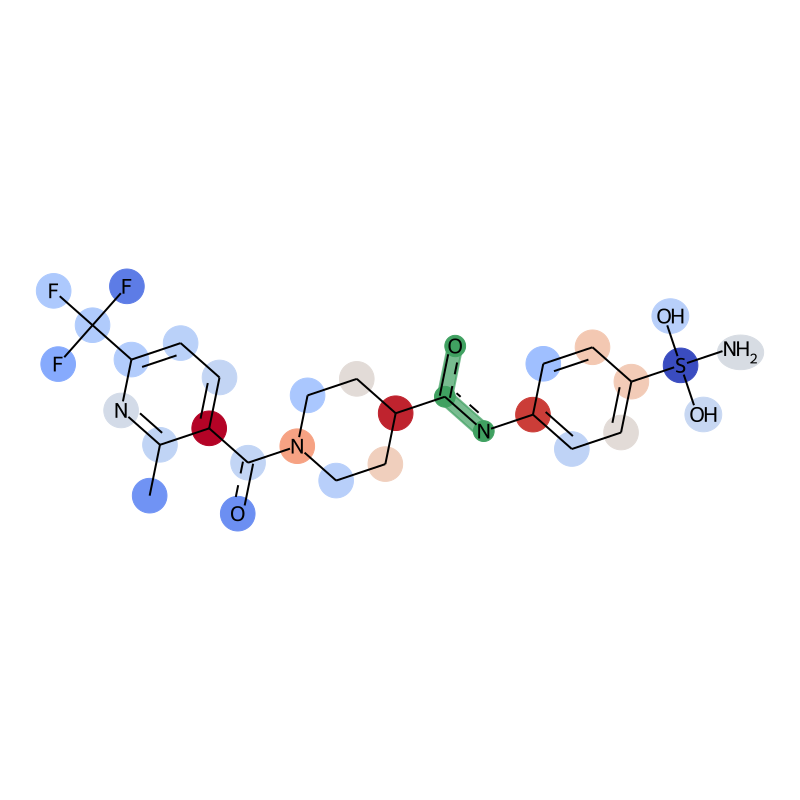

Aromatic bonds: [1, 2, 3, 5, 9, 10, 15, 16, 17, 18, 19, 21, 22, 23, 25, 30]
Aromatic rings: [[1, 10, 9, 8, 3, 2], [15, 23, 22, 18, 17, 16]]


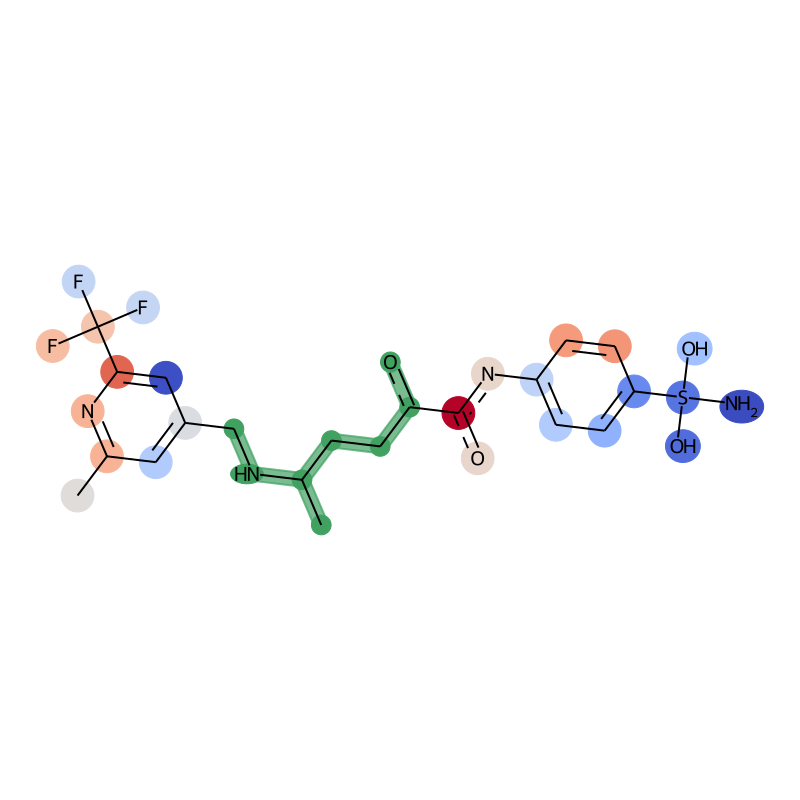

Aromatic bonds: [0, 1, 2, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 19, 20, 22, 26]
Aromatic rings: [[5, 6, 7, 8, 9, 4], [11, 18, 17, 14, 13, 12]]
Error while drawing molecule with highlights: Can't kekulize mol.  Unkekulized atoms: 19 23 26
Aromatic bonds: [3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 22, 27]
Aromatic rings: [[8, 9, 10, 11, 12, 7], [13, 20, 19, 16, 15, 14]]
Error while drawing molecule with highlights: Can't kekulize mol.  Unkekulized atoms: 25


[16:45:22] Can't kekulize mol.  Unkekulized atoms: 19 23 26
[16:45:22] Can't kekulize mol.  Unkekulized atoms: 25


In [9]:
from rdkit.Chem import SanitizeFlags
from rdkit.Chem.rdMolDescriptors import CalcNumRings
# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=False)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = get_bond_order_with_aromatic(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            
            if bond_order > 0:
                bond_type = const.BOND_DICT[bond_order]
                mol.AddBond(atom_map[idx1], atom_map[idx2], bond_type)
                # # Make aromatic bonds explicit
                
                if bond_type == Chem.rdchem.BondType.AROMATIC:
                    
                    bond = mol.GetBondBetweenAtoms(atom_map[idx1], atom_map[idx2])
                    bond.SetIsAromatic(True)

    
    

    # Highlight fragment atoms and edges
    
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    bond_colors = {}
   
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    # Chem.SanitizeMol(
    #     mol,
    #     sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ (SanitizeFlags.SANITIZE_PROPERTIES | SanitizeFlags.SANITIZE_KEKULIZE)
    # )  # Perform sanitization to detect aromaticity
    try:
        Chem.SanitizeMol(
            mol,
            sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ (SanitizeFlags.SANITIZE_KEKULIZE)
        )
    except Exception as e:
        print(f"Sanitization warning: {e}")
        continue
    # Detect aromatic bonds
    aromatic_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBondType() == Chem.BondType.AROMATIC:
            aromatic_bonds.append(bond.GetIdx())
            # bond.SetIsAromatic(True)

    # Detect aromatic rings
    aromatic_rings = []
    for ring in Chem.GetSymmSSSR(mol):  # Get all rings
        ring_bonds = [mol.GetBondBetweenAtoms(ring[i], ring[(i + 1) % len(ring)]).GetIdx() for i in range(len(ring))]
        if all(mol.GetBondWithIdx(bond_idx).GetIsAromatic() for bond_idx in ring_bonds):
            aromatic_rings.append(list(ring))

    print(f"Aromatic bonds: {aromatic_bonds}")
    print(f"Aromatic rings: {aromatic_rings}")
    # atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    atom_colors = {idx: list(map(float, color[:3])) for idx, color in highlight_colors.items()}  # Convert to lists of floats
    atom_colors = {key: [tuple(value)] for key, value in atom_colors.items()}
    # Draw linker bonds and atoms in emerald green
    emerald_green = (0.25, 0.63, 0.38, 0.7)  # RGB for emerald green
    linker_mask = data['linker_mask'][0].cpu().numpy()
    
    # Update atom colors for linker atoms
    for idx, mask in enumerate(linker_mask):
        if mask == 1:
            atom_colors[idx] = [emerald_green[:3]]  # Set emerald green for linker atoms
    
    # Update bond colors for linker bonds
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if linker_mask[begin_idx] == 1 and linker_mask[end_idx] == 1:
            bond_colors[bond.GetIdx()] = [emerald_green]  # Set emerald green for linker bonds
    # Use DrawMoleculeWithHighlights for visualization
    atom_radii = {idx: 0.5 for idx in range(len(positions))}  # Default atom radius
    # Set radius 0.3 for linker atoms
    for idx, mask in enumerate(linker_mask):
        if mask == 1:
            atom_radii[idx] = 0.3
    
    drawer = Draw.MolDraw2DCairo(800, 800)
    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    draw_options.kekulize = False
    try:
        drawer.DrawMoleculeWithHighlights(
            mol,
            "",  # Legend
            atom_colors,  # Atom colors (highlight_atom_map)
            bond_colors,  # Bond colors (highlight_bond_map)
            atom_radii,  # Atom radii
            {}  # Bond linewidth multipliers
            # kekulize=False  # Avoid kekulization
        )

        drawer.FinishDrawing()
        # Convert the drawing to a PNG image
        png_data = drawer.GetDrawingText()
        with open("temp_image.png", "wb") as f:
            f.write(png_data)

        # Load the PNG image using PIL
        img = Image.open("temp_image.png")
        
        img.show()
        
        
        output_generated_dir = os.path.join(COORDINATES_FOLDER, "mergednokekule")
        os.makedirs(output_generated_dir, exist_ok=True)
        # Save the image in the "generated_structures" subfolder
        output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
        img.save(output_file, dpi=(300, 300))
        
    except Exception as e:
        print(f"Error while drawing molecule with highlights: {e}")

    

Drawing with single bonds

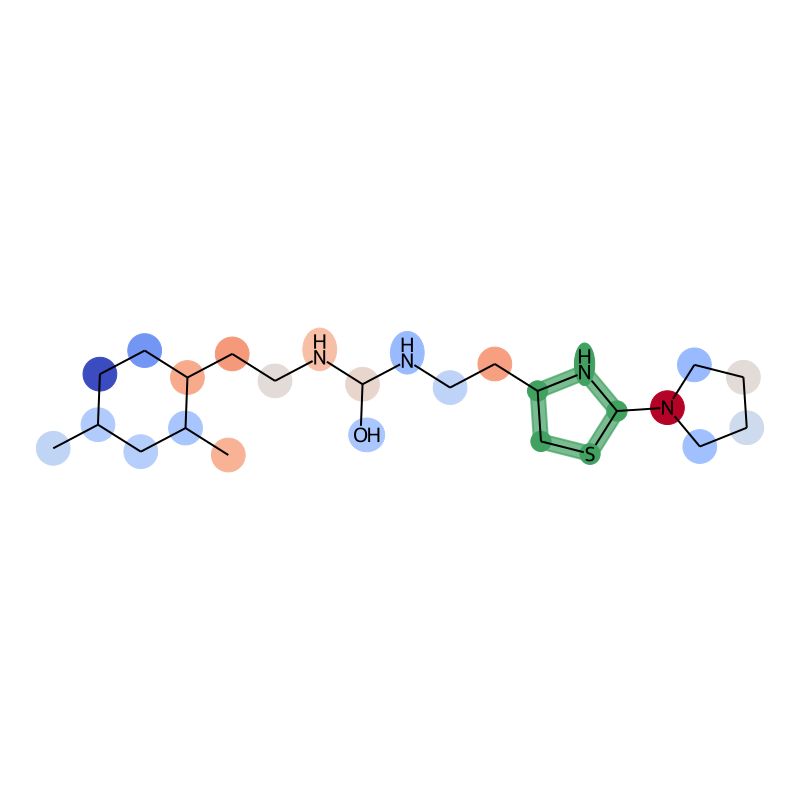

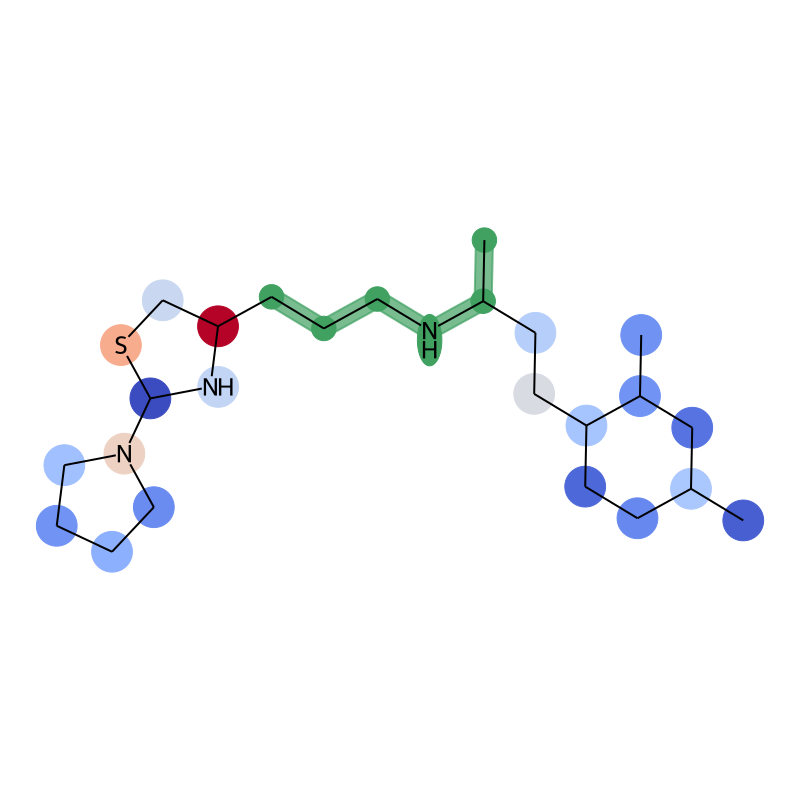

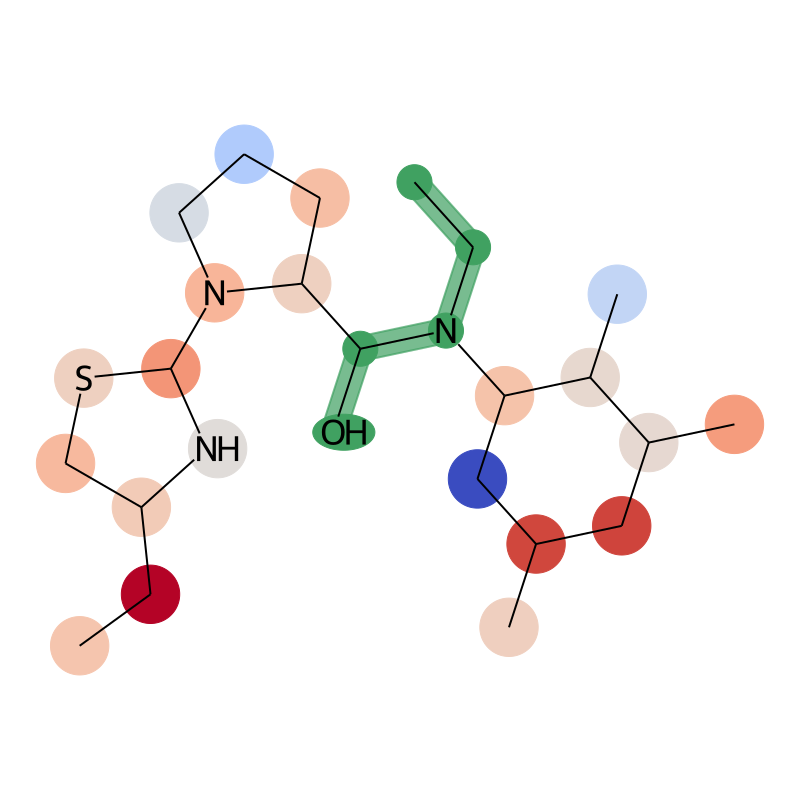

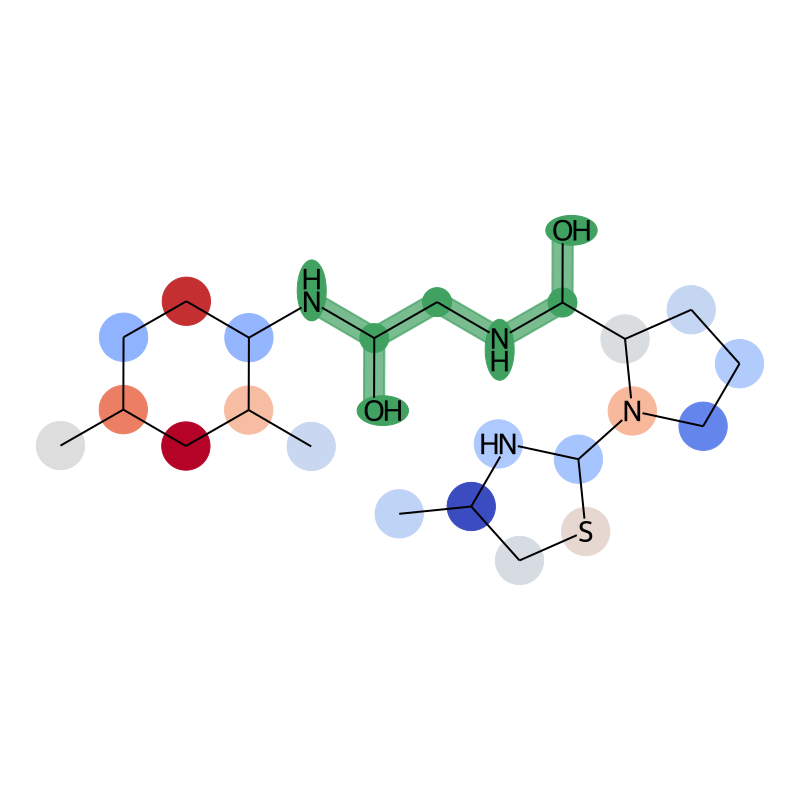

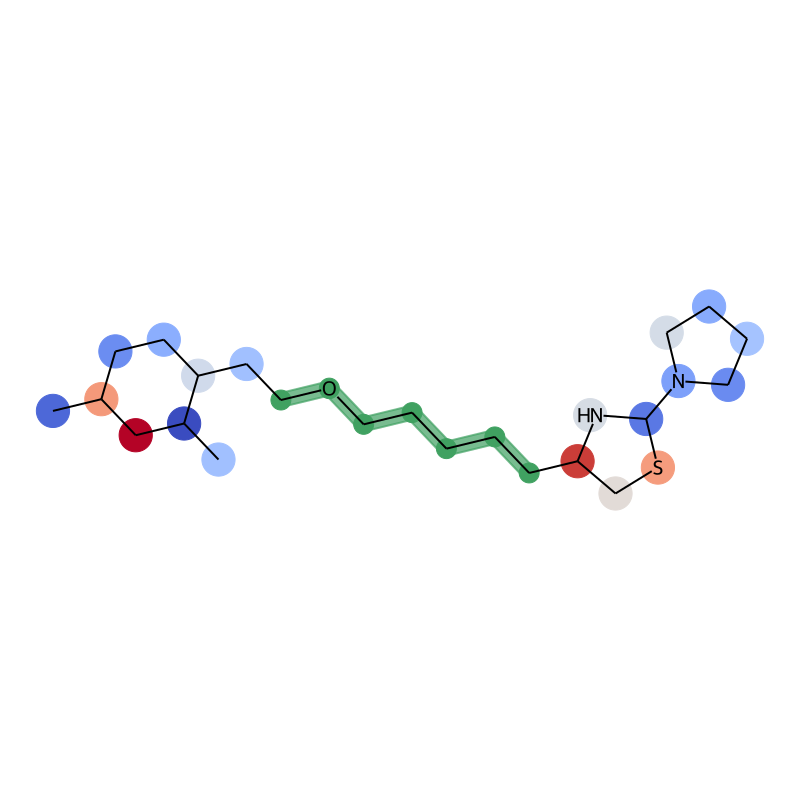

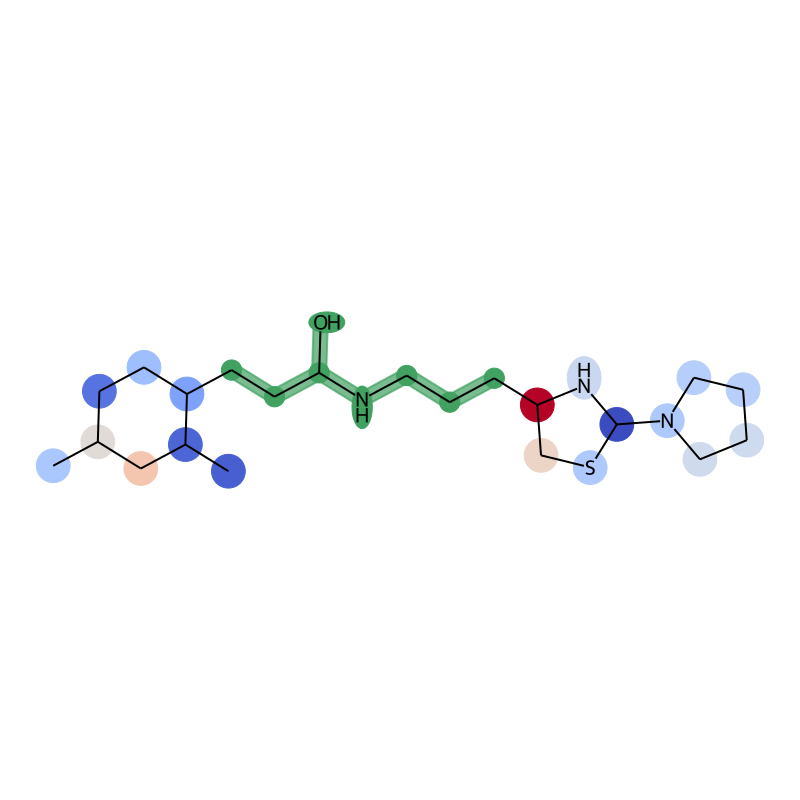

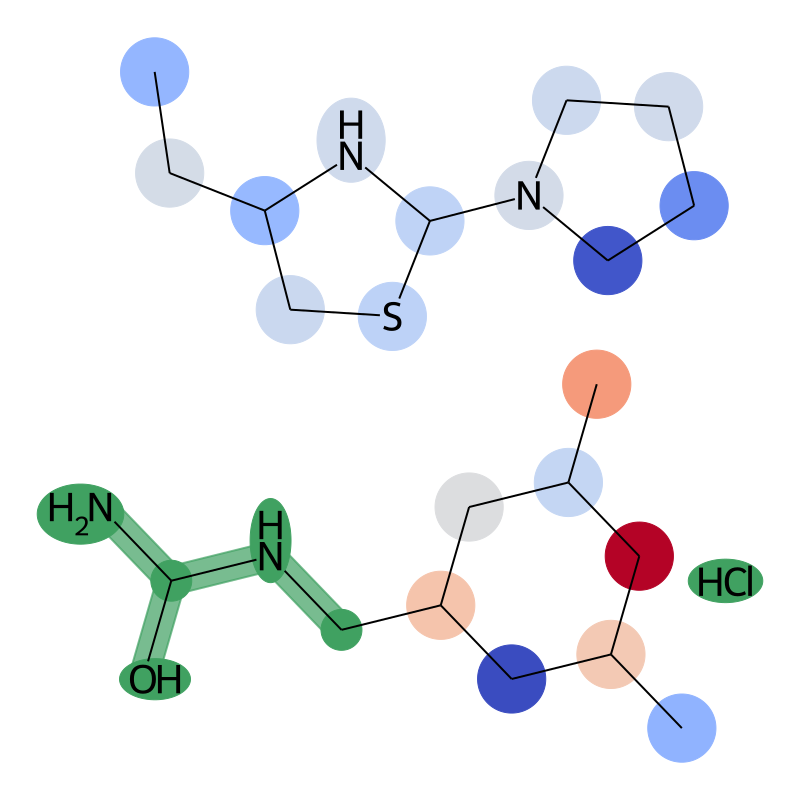

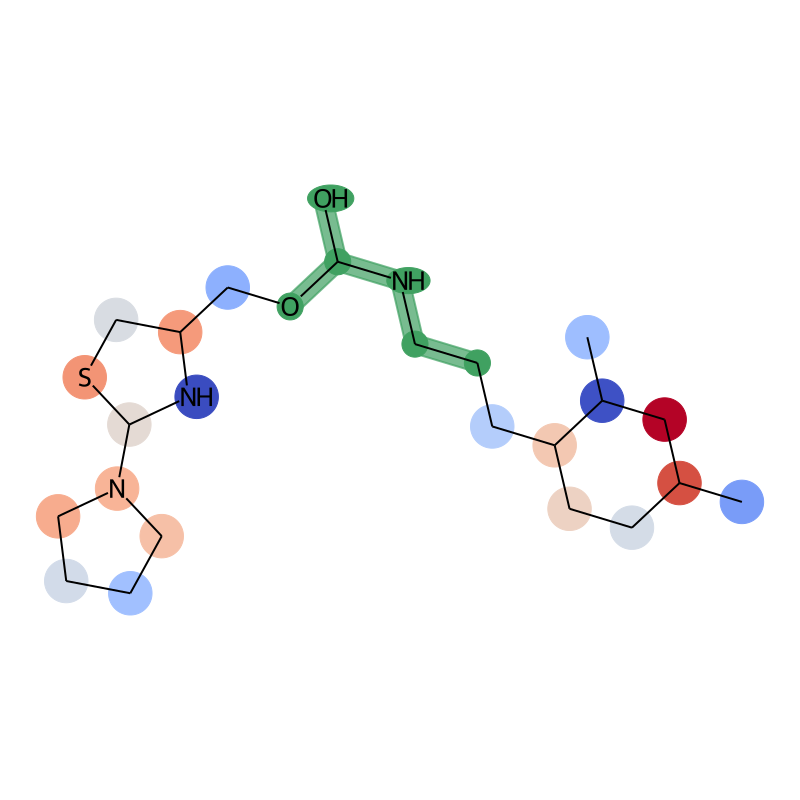

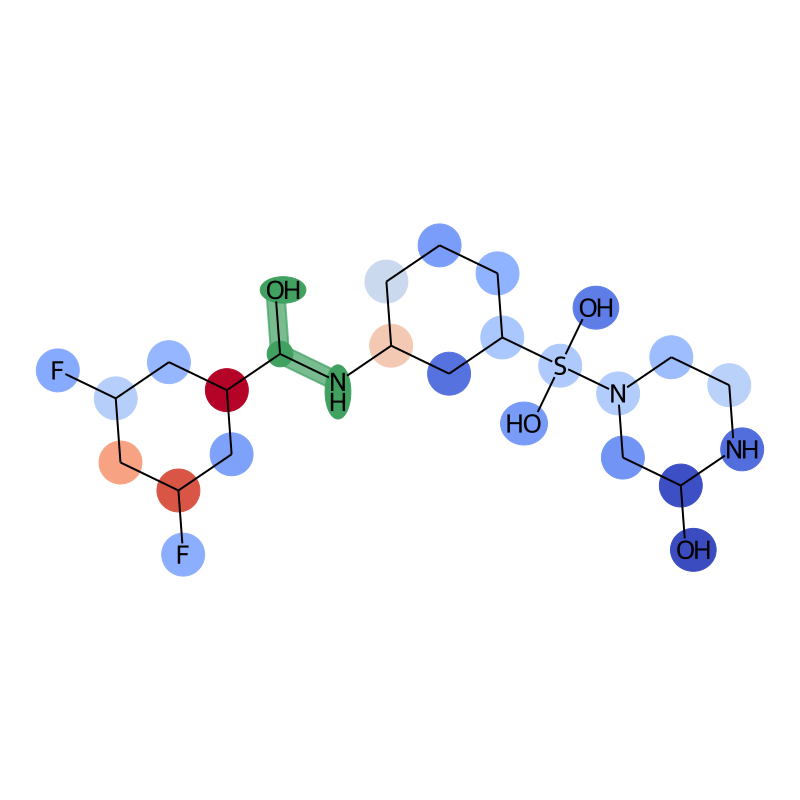

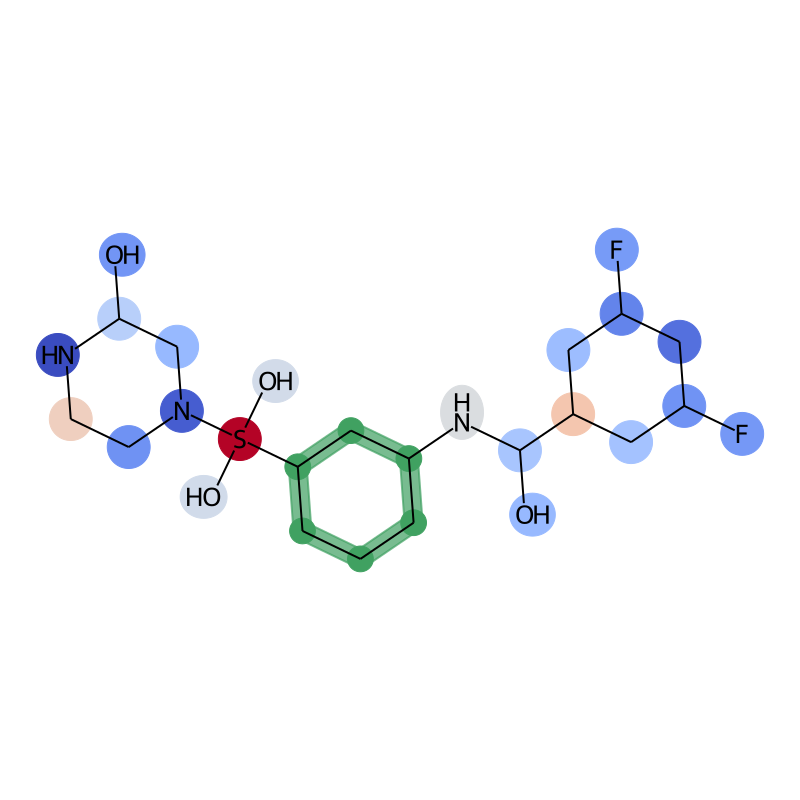

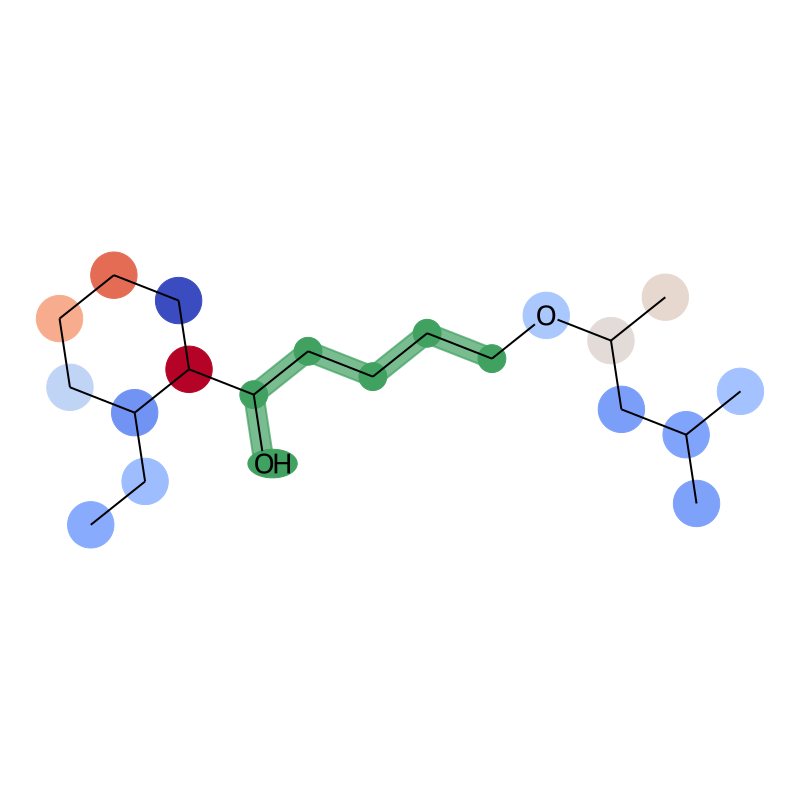

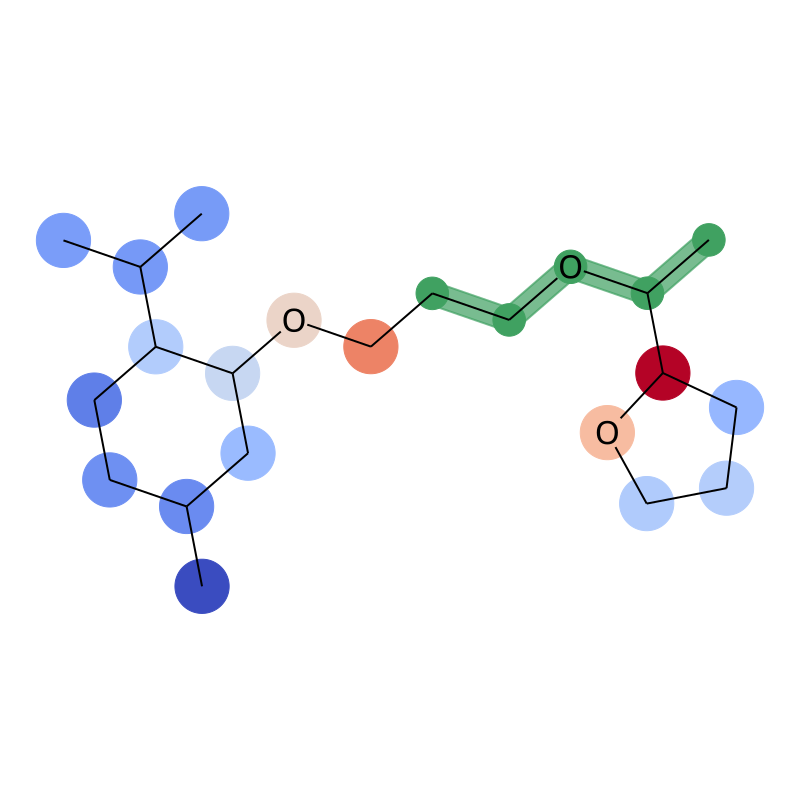

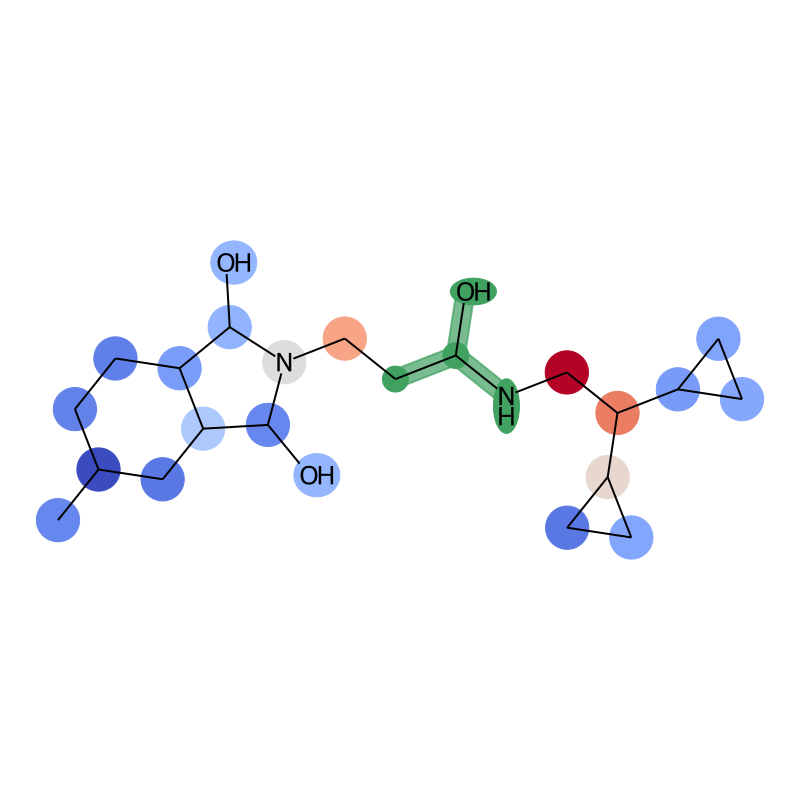

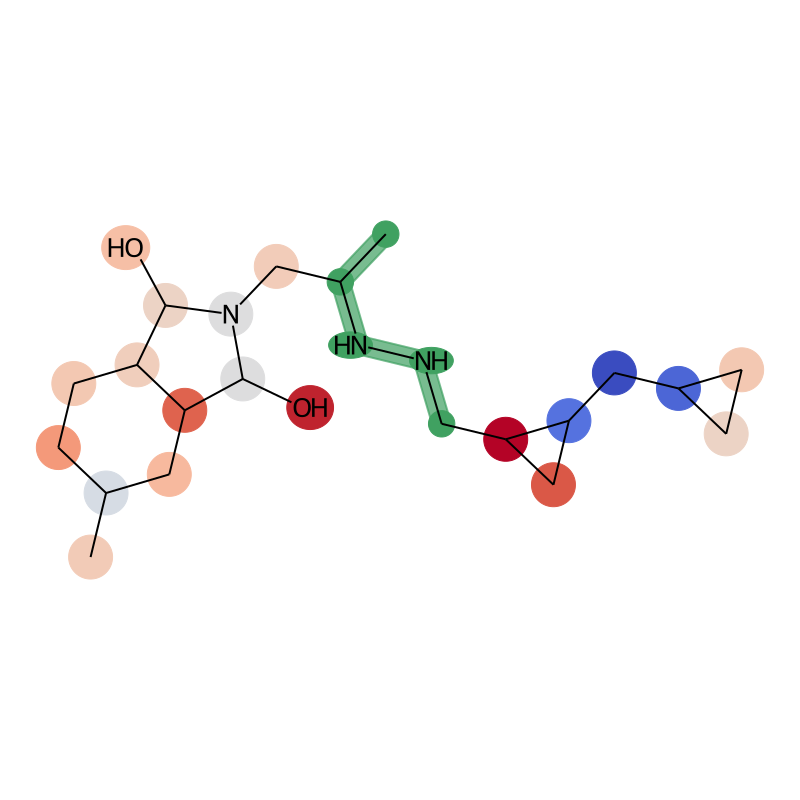

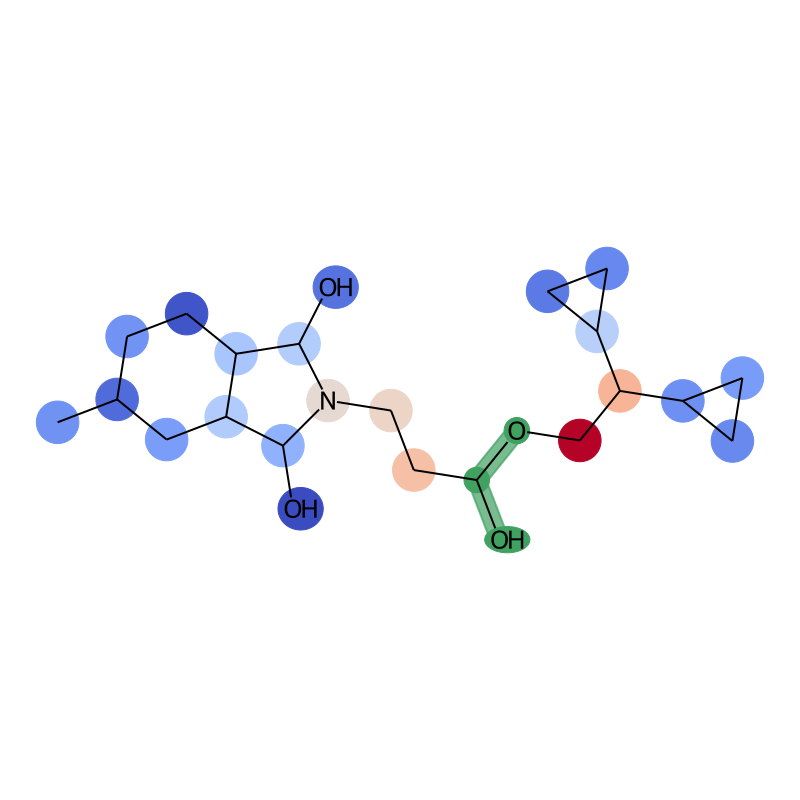

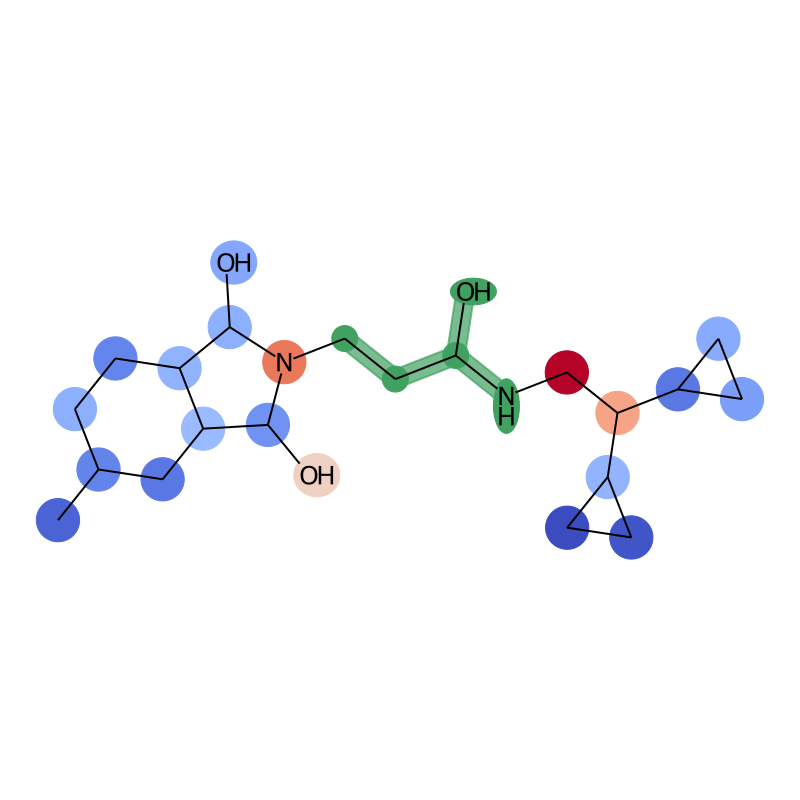

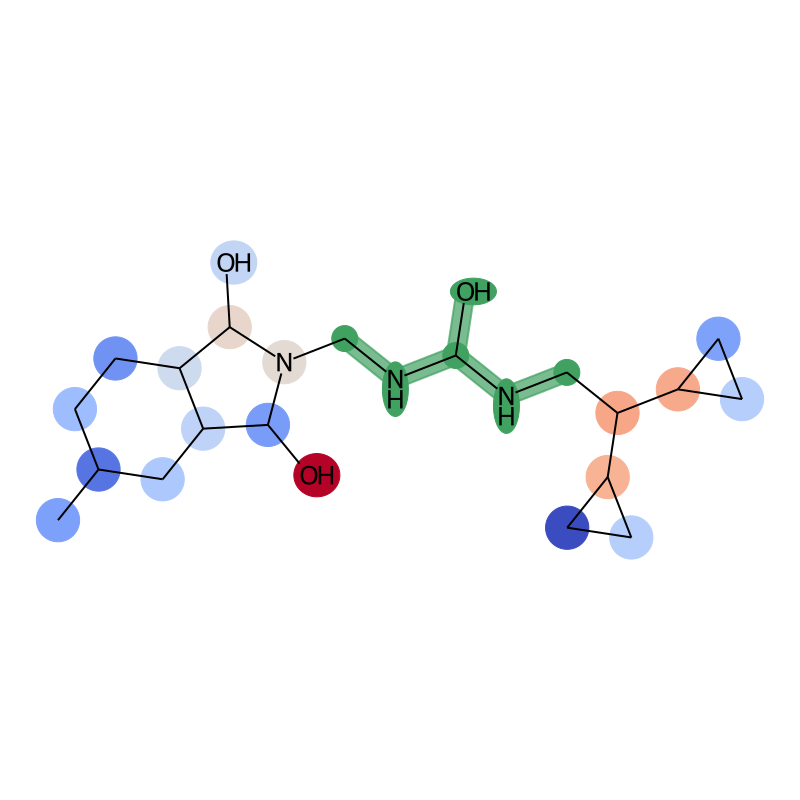

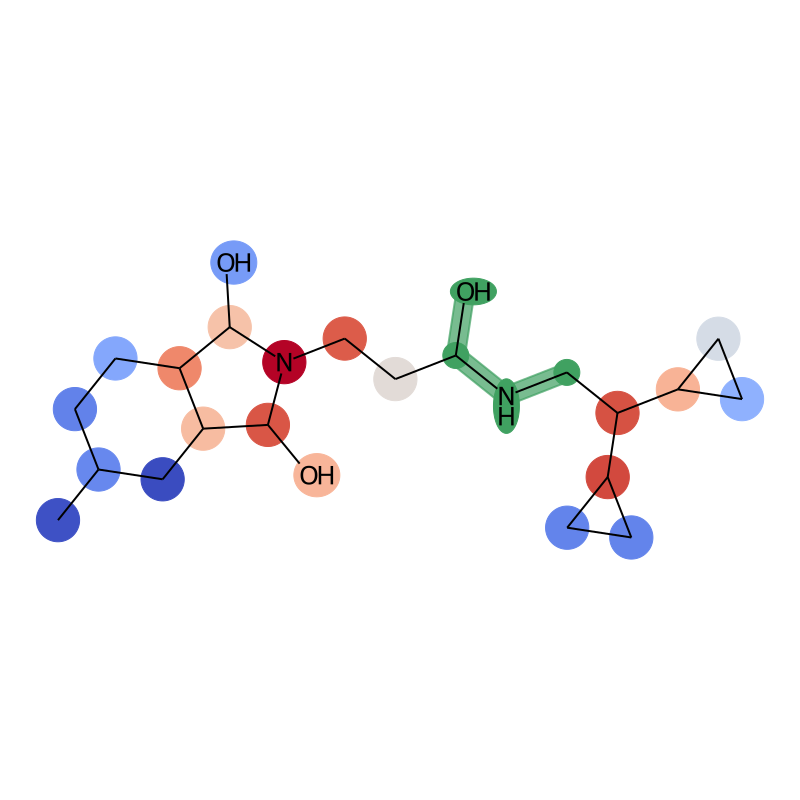

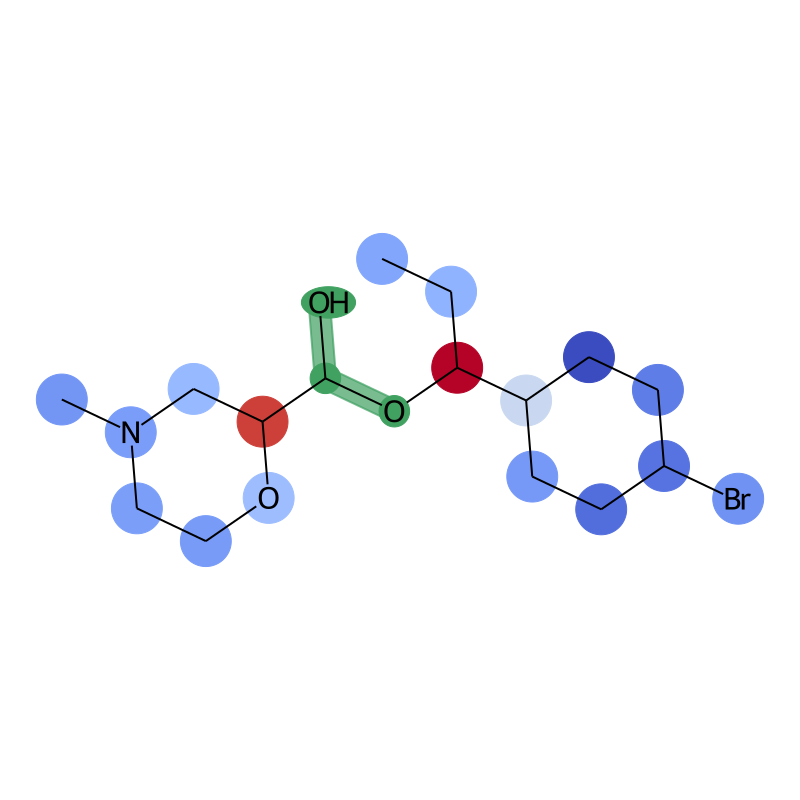

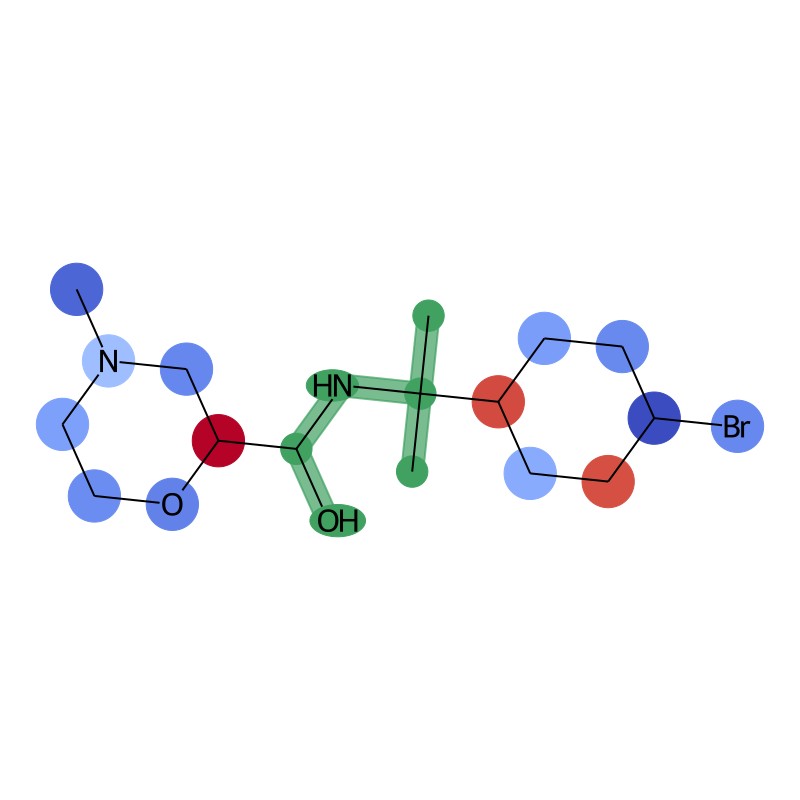

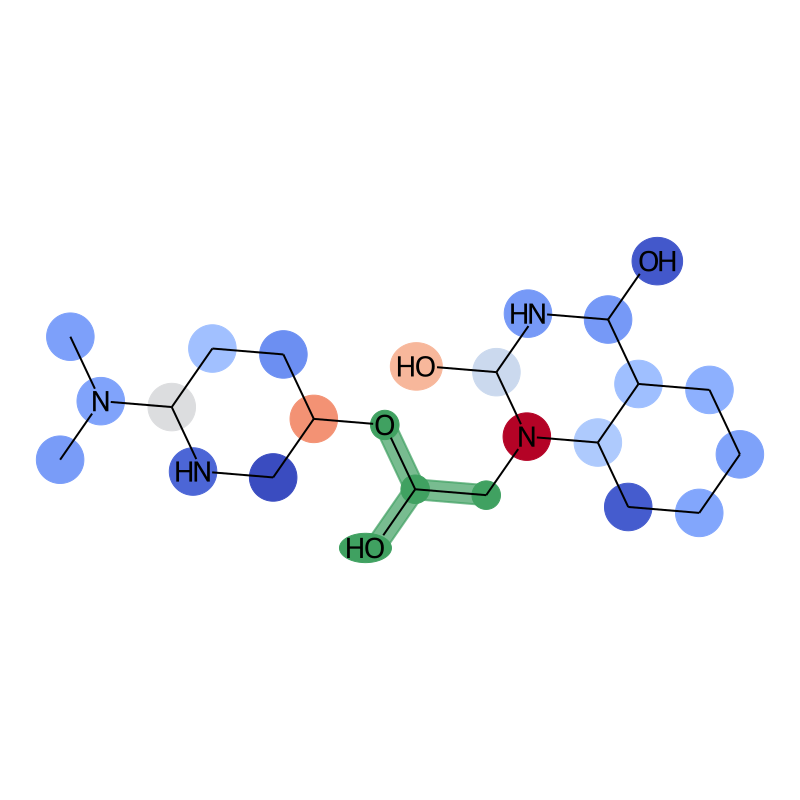

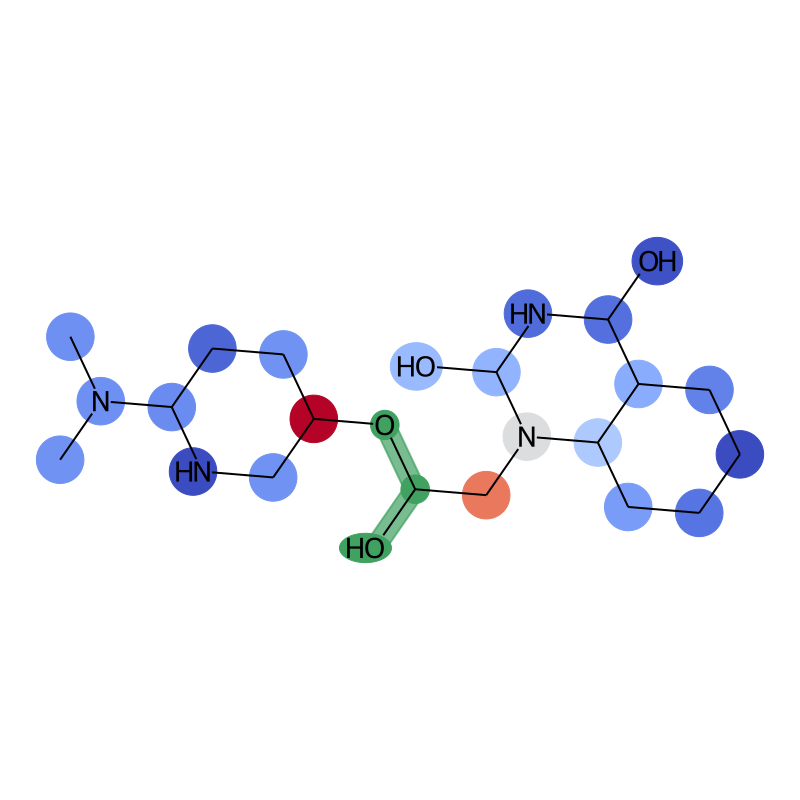

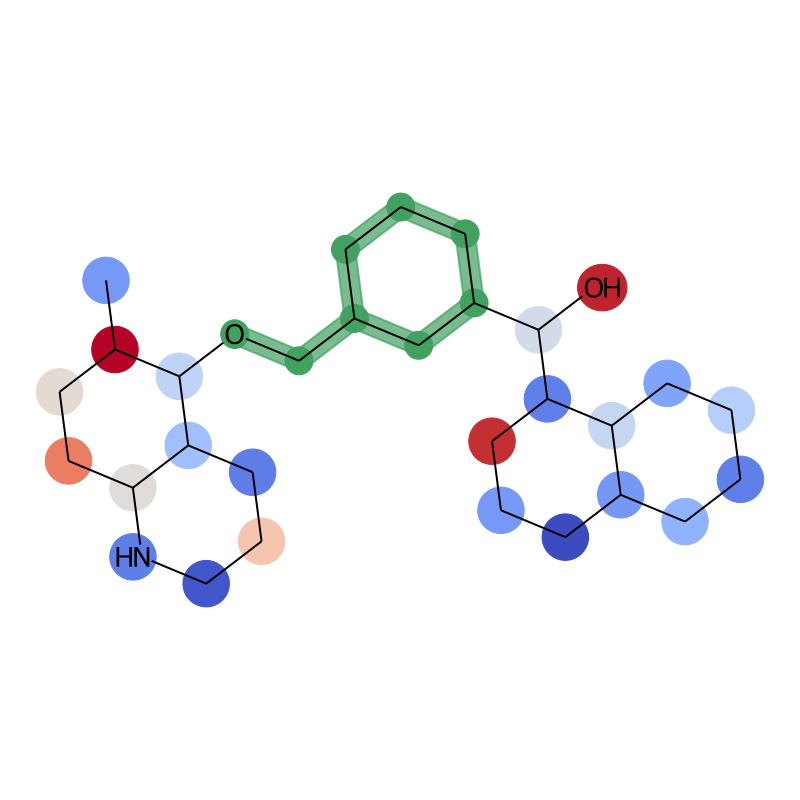

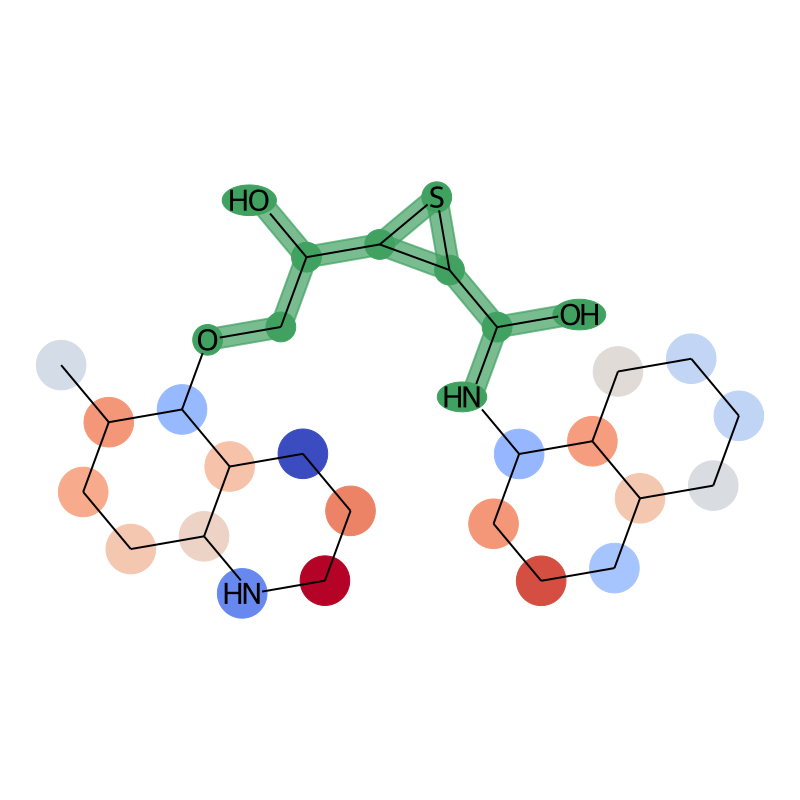

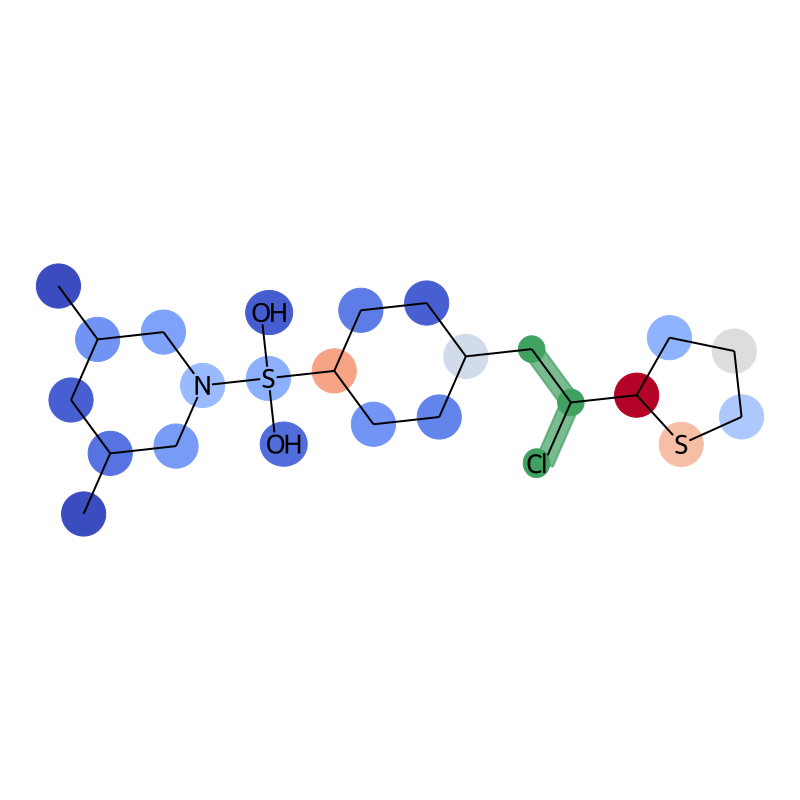

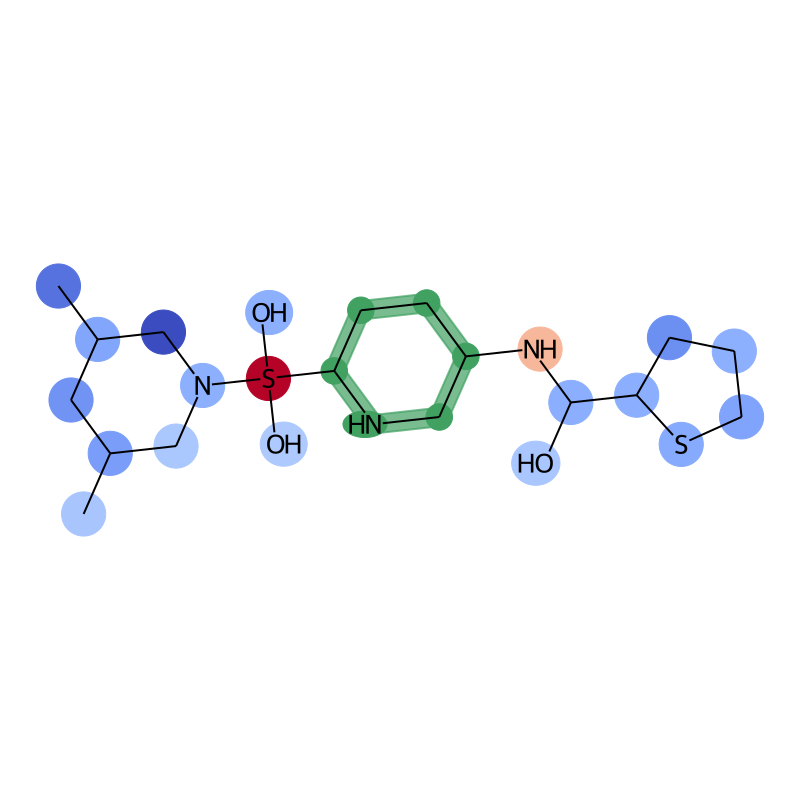

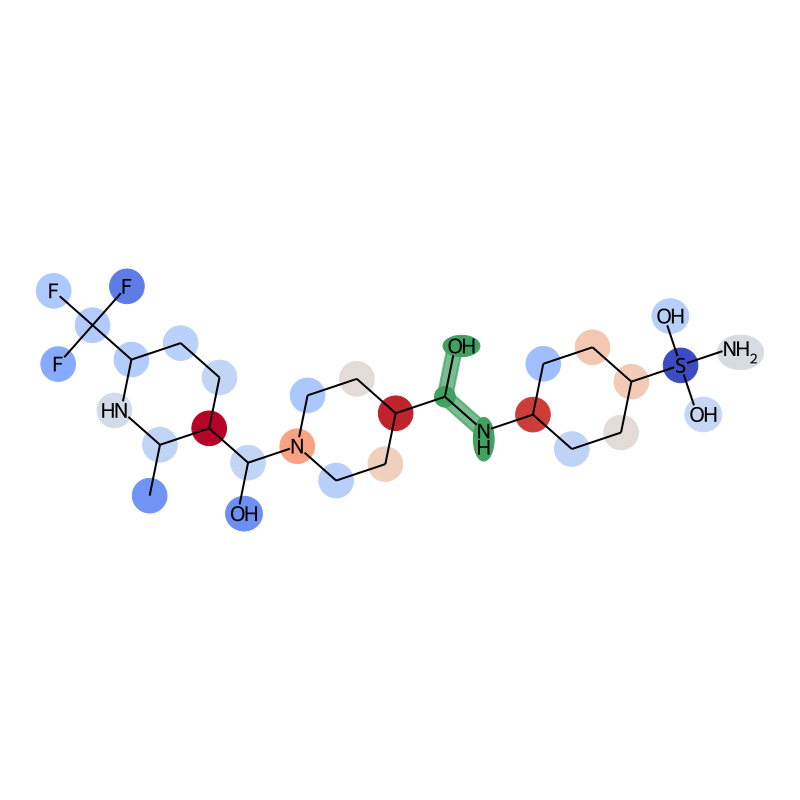

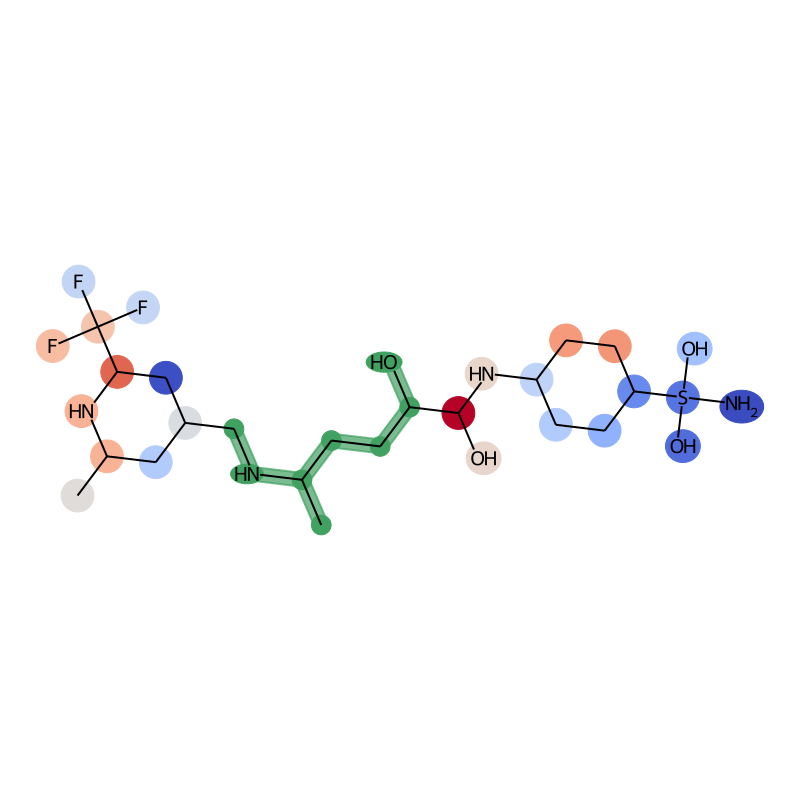

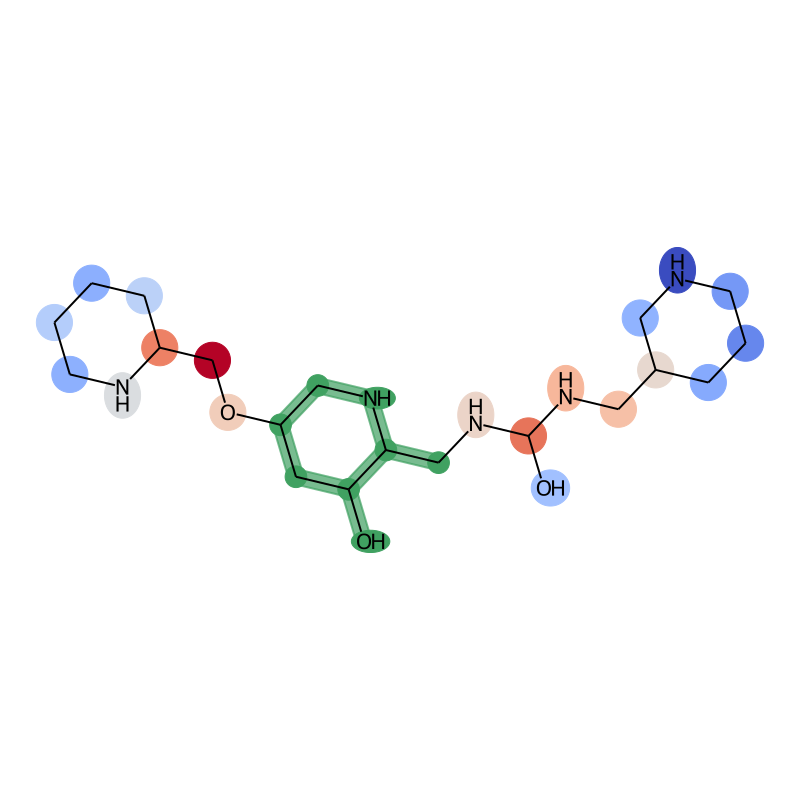

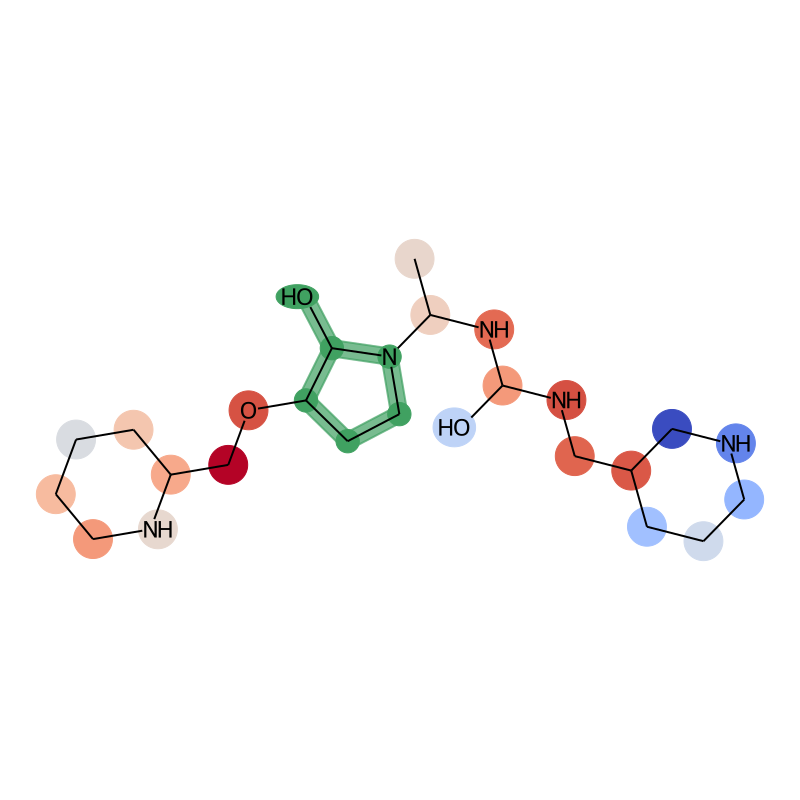

In [7]:
from rdkit.Chem import SanitizeFlags
from rdkit.Chem.rdMolDescriptors import CalcNumRings
# Visualize generated molecules as molecular graphs
generated_folder = "trajectories/zinc_difflinker/zinc_final_test/final_states_hausdorff_distance_0.5_seed_42_no_transform_transformation_seed_42_COM_addition"

for data_index, data in enumerate(data_list):
    phi_values = shapley_values_all_dict[data_index][0]
    # Load generated molecule positions and atom types
    generated_file = os.path.join(generated_folder, f"{data_index}_pred_.xyz")
    positions, one_hot, _ = load_molecule_xyz(generated_file, is_geom=False)
    
    atom_types = torch.argmax(one_hot, dim=1).cpu().numpy()
   
    # Convert positions and atom types to an RDKit molecule
    mol = Chem.RWMol()
    atom_map = {}

    # Add atoms to the molecule
    for idx, atom_type in enumerate(atom_types):
        atom = Chem.Atom(const.IDX2ATOM[atom_type])
        atom_idx = mol.AddAtom(atom)
        atom_map[idx] = atom_idx

    # Add bonds based on positions and bond order
    for idx1 in range(len(positions)):
        for idx2 in range(idx1 + 1, len(positions)):
            dist = np.linalg.norm(positions[idx1] - positions[idx2])
            bond_order = has_bond(const.IDX2ATOM[atom_types[idx1]], const.IDX2ATOM[atom_types[idx2]], dist)
            
            if bond_order > 0:
                bond_type = const.BOND_DICT[bond_order]
                mol.AddBond(atom_map[idx1], atom_map[idx2], bond_type)
                # # Make aromatic bonds explicit
                
                if bond_type == Chem.rdchem.BondType.AROMATIC:
                    
                    bond = mol.GetBondBetweenAtoms(atom_map[idx1], atom_map[idx2])
                    bond.SetIsAromatic(True)

    # Highlight fragment atoms and edges
    
    fragment_mask = data['fragment_mask'][0].cpu().numpy()
   
    # Calculate the gradient colors based on phi values
    phi_values_array = np.array(phi_values)
    
    cmap = plt.cm.get_cmap('coolwarm_r') #reversed heatmap for distance-based importance
    norm = plt.Normalize(vmin=min(phi_values_array), vmax=max(phi_values_array))
    
    highlight_colors = {idx: cmap(norm(phi_values_array[idx])) for idx, mask in enumerate(fragment_mask) if mask == 1}
    
    highlight_atoms = list(highlight_colors.keys())
    highlight_bonds = []
    for bond in mol.GetBonds():
        if bond.GetBeginAtomIdx() in highlight_atoms and bond.GetEndAtomIdx() in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())
    # Assign bond colors based on the colors of the connected atoms
    bond_colors = {}
   
    # Convert to RDKit molecule and draw
    mol = mol.GetMol()
    # Chem.SanitizeMol(
    #     mol,
    #     sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ (SanitizeFlags.SANITIZE_PROPERTIES | SanitizeFlags.SANITIZE_KEKULIZE)
    # )  # Perform sanitization to detect aromaticity
    # try:
    #     Chem.SanitizeMol(
    #         mol,
    #         sanitizeOps=SanitizeFlags.SANITIZE_ALL ^ (SanitizeFlags.SANITIZE_KEKULIZE)
    #     )
    # except Exception as e:
    #     print(f"Sanitization warning: {e}")
    #     continue
    # Detect aromatic bonds

    # atom_colors = {idx: tuple(color[:3]) for idx, color in highlight_colors.items()}  # Extract RGB values (remove alpha channel)
    atom_colors = {idx: list(map(float, color[:3])) for idx, color in highlight_colors.items()}  # Convert to lists of floats
    atom_colors = {key: [tuple(value)] for key, value in atom_colors.items()}
    # Draw linker bonds and atoms in emerald green
    emerald_green = (0.25, 0.63, 0.38, 0.7)  # RGB for emerald green
    linker_mask = data['linker_mask'][0].cpu().numpy()
    
    # Update atom colors for linker atoms
    for idx, mask in enumerate(linker_mask):
        if mask == 1:
            atom_colors[idx] = [emerald_green[:3]]  # Set emerald green for linker atoms
    
    # Update bond colors for linker bonds
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        if linker_mask[begin_idx] == 1 and linker_mask[end_idx] == 1:
            bond_colors[bond.GetIdx()] = [emerald_green]  # Set emerald green for linker bonds
    # Use DrawMoleculeWithHighlights for visualization
    atom_radii = {idx: 0.5 for idx in range(len(positions))}  # Default atom radius
    # Set radius 0.3 for linker atoms
    for idx, mask in enumerate(linker_mask):
        if mask == 1:
            atom_radii[idx] = 0.3
    
    drawer = Draw.MolDraw2DCairo(800, 800)
    draw_options = drawer.drawOptions()
    draw_options.useBWAtomPalette()
    draw_options.kekulize = False
    
    drawer.DrawMoleculeWithHighlights(
        mol,
        "",  # Legend
        atom_colors,  # Atom colors (highlight_atom_map)
        bond_colors,  # Bond colors (highlight_bond_map)
        atom_radii,  # Atom radii
        {}  # Bond linewidth multipliers
        # kekulize=False  # Avoid kekulization
    )

    drawer.FinishDrawing()
    # Convert the drawing to a PNG image
    png_data = drawer.GetDrawingText()
    with open("temp_image.png", "wb") as f:
        f.write(png_data)

    # Load the PNG image using PIL
    img = Image.open("temp_image.png")
    
    img.show()
    
    
    output_generated_dir = os.path.join(COORDINATES_FOLDER, "singlebonds")
    os.makedirs(output_generated_dir, exist_ok=True)
    # Save the image in the "generated_structures" subfolder
    output_file = os.path.join(output_generated_dir, f"molecule_{data_index}.png")
    img.save(output_file, dpi=(300, 300))
        
    

    

In [20]:
print(Chem.MolToSmiles(mol))

O=C1CN(S(O)(O)c2cccc(NC(O)C3cc(F)=C=c(F)c3)c2)CCN1
